# INF-395 Redes Neuronales Artificiales
## Tarea 1 - Redes Neuronales

### Integrantes:
* Ignacio Valenzuela Albornoz
* Rodrigo González Smith

# Introducción

# Desarrollo

Antes de proceder a realizar el trabajo importamos las librerías y paquetes que usaremos:

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
from sklearn.preprocessing import StandardScaler
from keras.callbacks import TerminateOnNaN
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from sklearn.model_selection import KFold

## 1. Predicción de Entalpía de Atomización

###  1.a. Construir Dataframe

Se lee el archivo csv con pandas, obtenemos su dimensión, información y descripción de sus datos como media, varianza y valores mínimos y máximos.

In [3]:
datos= pd.read_csv("roboBohr.csv")
datos.shape
datos.info()
datos.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16242 entries, 0 to 16241
Columns: 1278 entries, Unnamed: 0 to Eat
dtypes: float64(1276), int64(2)
memory usage: 158.4 MB


Unnamed: 0             0             1             2             3  \
count  16242.000000  16242.000000  16242.000000  16242.000000  16242.000000   
mean    8139.041805    115.715266     22.445723     20.474191     18.529573   
std     4698.182820    113.198503      8.659586      7.670481      6.485777   
min        0.000000     36.858105      2.906146      0.000000      0.000000   
25%     4068.250000     73.516695     17.969345     16.228071     15.165862   
50%     8142.500000     73.516695     20.662511     18.631287     17.690729   
75%    12207.750000     73.516695     21.132432     20.739496     18.712895   
max    16272.000000    388.023441     73.563510     66.269180     66.268891   

                  4             5             6             7             8  \
count  16242.000000  16242.000000  16242.000000  16242.000000  16242.000000   
mean      17.169350     15.816888     15.133152     14.471534     13.960759   
std        5.512560      4.179691      3.885091      3.503075      3.357136   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       13.744092     13.653146     13.637784     12.759519     12.587359   
50%       16.020040     15.156646     13.848274     13.659233     13.652832   
75%       18.297501     17.639688     16.154918     15.499474     14.900585   
max       66.268756     66.268196     66.264158     66.258487     66.258177   

           ...               1267          1268          1269          1270  \
count      ...       16242.000000  16242.000000  16242.000000  16242.000000   
mean       ...           0.000134      0.000133      0.003879      0.000131   
std        ...           0.002728      0.002705      0.043869      0.002676   
min        ...           0.000000      0.000000      0.000000      0.000000   
25%        ...           0.000000      0.000000      0.000000      0.000000   
50%        ...           0.000000      0.000000      0.000000      0.000000   
75%        ...           0.000000      0.000000      0.000000      0.000000   
max        ...           0.062225      0.061999      0.500000      0.061534   

               1271          1272          1273          1274    pubchem_id  \
count  16242.000000  16242.000000  16242.000000  16242.000000  16242.000000   
mean       0.000129      0.002155      0.000127      0.001201  33107.484300   
std        0.002633      0.032755      0.002594      0.024472  23456.785147   
min        0.000000      0.000000      0.000000      0.000000      1.000000   
25%        0.000000      0.000000      0.000000      0.000000  12298.250000   
50%        0.000000      0.000000      0.000000      0.000000  27731.500000   
75%        0.000000      0.000000      0.000000      0.000000  55020.750000   
max        0.059760      0.500000      0.057834      0.500000  74980.000000   

                Eat  
count  16242.000000  
mean     -11.178969  
std        3.659133  
min      -23.245373  
25%      -13.475805  
50%      -10.835211  
75%       -8.623903  
max       -0.789513  

[8 rows x 1278 columns]

Eliminamos las columnas 'Unnamed: 0' y 'pubchem_id'. La primera se elimina debido a que era una columna que representaba los índices de las muestras, pero esto es almacenado automáticamente al convertir ese archivo en dataframe. Por otro lado, 'pubchem_id' se eliminó por ........ . Por último obtenemos el total de datos para así dividir la muestra en un 60% de entrenamiento, 25% de validación y el 15% restante de test.

In [4]:
datos.drop(columns=['Unnamed: 0','pubchem_id'],axis=1,inplace=True)
total=len(datos)
df_train=datos[:int(0.6*total)]                       #60% de los datos
df_val=datos[int(0.6*total):int(0.85*total)]          #25% de los datos
df_test=datos[int(0.85*total)::]                      #15% restante

#### 1.a.1. Normalización de datos

Se procede a normalizar los datos. Esto nos ayuda ya que los valores de las entradas, en el dominio de la red neuronal, son equiparables entre ellas en cierto modo, reduciendo la influencia de ciertos outliers en la muestra, además evita valores disparatados del loss function, ya que distorsionaría el objetivo: obtendriamos valores de pérdida altos no por su mala precisión, si no por las dimensiones de la muestra. Además, mientras mas alto los valores de la muestra, el error se distorsiona, ya que al ser numeros grandes, la razón entre ellos varía poco al aumentar o disminuir su valor.

In [5]:
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
X_val_scaled =  pd.DataFrame(scaler.transform(df_val),columns=df_val.columns)
X_test_scaled =  pd.DataFrame(scaler.transform(df_test),columns=df_test.columns)

y_train = df_train.pop('Eat').values.reshape(-1,1)
y_val = df_val.pop('Eat').values.reshape(-1,1)

X_train_scaled.drop(columns=['Eat'],axis=1,inplace=True)
X_val_scaled.drop(columns=['Eat'],axis=1,inplace=True)
X_test_scaled.drop(columns=['Eat'],axis=1,inplace=True)

### 1.b.  Red feedfoward: Sigmoid

In [6]:
a = np.matrix(X_train_scaled)
a_val_scaled = np.matrix(X_val_scaled)

Configuramos el modelo y entrenamos la red, obteniendo los 250 epoch con sus respectivos valores de loss function.

In [21]:
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
model.compile(optimizer=SGD(lr=0.01),loss='mean_squared_error')
history = model.fit(a, y_train, epochs=250, verbose=1, validation_data=(a_val_scaled, y_val))

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 2s 161us/step - loss: 1.4476 - val_loss: 0.7463
Epoch 2/250
9745/9745 [==============================] - 1s 147us/step - loss: 0.5986 - val_loss: 0.4399
Epoch 3/250
9745/9745 [==============================] - 1s 144us/step - loss: 0.5064 - val_loss: 0.3723
Epoch 4/250
9745/9745 [==============================] - 1s 145us/step - loss: 0.4397 - val_loss: 0.3394
Epoch 5/250
9745/9745 [==============================] - 1s 142us/step - loss: 0.3724 - val_loss: 0.3641
Epoch 6/250
9745/9745 [==============================] - 1s 145us/step - loss: 0.3191 - val_loss: 0.3194
Epoch 7/250
9745/9745 [==============================] - 1s 144us/step - loss: 0.2816 - val_loss: 0.2511
Epoch 8/250
9745/9745 [==============================] - 1s 144us/step - loss: 0.2488 - val_loss: 0.2149
Epoch 9/250
9745/9745 [==============================] - 1s 143us/step - loss: 0.2195 - val_loss: 0.1932
Epoch 1

Epoch 78/250
9745/9745 [==============================] - 1s 146us/step - loss: 0.0315 - val_loss: 0.0450
Epoch 79/250
9745/9745 [==============================] - 1s 145us/step - loss: 0.0312 - val_loss: 0.0811
Epoch 80/250
9745/9745 [==============================] - 1s 145us/step - loss: 0.0303 - val_loss: 0.1073
Epoch 81/250
9745/9745 [==============================] - 1s 145us/step - loss: 0.0301 - val_loss: 0.0483
Epoch 82/250
9745/9745 [==============================] - 1s 144us/step - loss: 0.0299 - val_loss: 0.0827
Epoch 83/250
9745/9745 [==============================] - 1s 145us/step - loss: 0.0298 - val_loss: 0.0438
Epoch 84/250
9745/9745 [==============================] - 1s 144us/step - loss: 0.0291 - val_loss: 0.0449
Epoch 85/250
9745/9745 [==============================] - 1s 144us/step - loss: 0.0293 - val_loss: 0.0444
Epoch 86/250
9745/9745 [==============================] - 1s 143us/step - loss: 0.0285 - val_loss: 0.0613
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 1s 148us/step - loss: 0.0197 - val_loss: 0.0440
Epoch 156/250
9745/9745 [==============================] - 1s 144us/step - loss: 0.0191 - val_loss: 0.0425
Epoch 157/250
9745/9745 [==============================] - 1s 146us/step - loss: 0.0190 - val_loss: 0.0386
Epoch 158/250
9745/9745 [==============================] - 1s 145us/step - loss: 0.0197 - val_loss: 0.0390
Epoch 159/250
9745/9745 [==============================] - 1s 146us/step - loss: 0.0193 - val_loss: 0.0388
Epoch 160/250
9745/9745 [==============================] - 1s 144us/step - loss: 0.0192 - val_loss: 0.0363
Epoch 161/250
9745/9745 [==============================] - 1s 147us/step - loss: 0.0192 - val_loss: 0.0360
Epoch 162/250
9745/9745 [==============================] - 1s 145us/step - loss: 0.0195 - val_loss: 0.0380
Epoch 163/250
9745/9745 [==============================] - 1s 143us/step - loss: 0.0194 - val_loss: 0.0430
Epoch 164/250
9745/9745 [============

Tomaremos los valores de loss tanto para training como validation y los graficaremos.

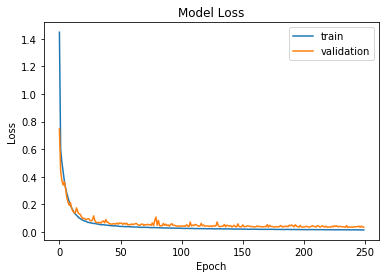

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Podemos ver en el gráfico que tanto la pérdida de entrenamiento como la de validación son muy buenos, y bajan constante y considerablemente mientras avanzan las epoch, claramente llegando un límite donde empieza a ser constante. Cabe destacar también que la función que representa el RMS para ambos sets son bastante parecidas, por lo que la red posee buenos valores para entrenamiento y validación.

### 1.c.  Red feedfoward: ReLu

Ahora realizaremos el mismo entrenamiento pero ocupando la función de activación ReLu

In [26]:
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
model.compile(optimizer=SGD(lr=0.01),loss='mean_squared_error')
history = model.fit(a, y_train, epochs=250, verbose=1, validation_data=(a_val_scaled, y_val))

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 2s 178us/step - loss: nan - val_loss: nan
Epoch 2/250
9745/9745 [==============================] - 1s 148us/step - loss: nan - val_loss: nan
Epoch 3/250
9745/9745 [==============================] - 1s 150us/step - loss: nan - val_loss: nan
Epoch 4/250
9745/9745 [==============================] - 1s 147us/step - loss: nan - val_loss: nan
Epoch 5/250
9745/9745 [==============================] - 1s 148us/step - loss: nan - val_loss: nan
Epoch 6/250
9745/9745 [==============================] - 1s 147us/step - loss: nan - val_loss: nan
Epoch 7/250
9745/9745 [==============================] - 1s 148us/step - loss: nan - val_loss: nan
Epoch 8/250
9745/9745 [==============================] - 1s 149us/step - loss: nan - val_loss: nan
Epoch 9/250
9745/9745 [==============================] - 1s 145us/step - loss: nan - val_loss: nan
Epoch 10/250
9745/9745 [==============================] - 1s 

9745/9745 [==============================] - 1s 149us/step - loss: nan - val_loss: nan
Epoch 164/250
9745/9745 [==============================] - 1s 145us/step - loss: nan - val_loss: nan
Epoch 165/250
9745/9745 [==============================] - 1s 147us/step - loss: nan - val_loss: nan
Epoch 166/250
9745/9745 [==============================] - 1s 147us/step - loss: nan - val_loss: nan
Epoch 167/250
9745/9745 [==============================] - 1s 150us/step - loss: nan - val_loss: nan
Epoch 168/250
9745/9745 [==============================] - 1s 149us/step - loss: nan - val_loss: nan
Epoch 169/250
9745/9745 [==============================] - 1s 149us/step - loss: nan - val_loss: nan
Epoch 170/250
9745/9745 [==============================] - 1s 150us/step - loss: nan - val_loss: nan
Epoch 171/250
9745/9745 [==============================] - 1s 148us/step - loss: nan - val_loss: nan
Epoch 172/250
9745/9745 [==============================] - 1s 147us/step - loss: nan - val_loss: nan
Epoc

Lamentablemente el entrenamiento diverge, sin importar las veces que se ejecute. 

### 1.d Cambiando learning rate

Ahora repetiremos los pasos anteriores variando el rate de aprendizaje, comenzando con una función de activación sigmoid para las capas ocultas 

In [23]:
n_lr = 20
lear_rate = np.linspace(0,1,n_lr)

In [24]:
### Para la funcion de activacion sigmoid. Se comienza desde el segundo elemento ya que el primero tiene valor 0.

for i in range(1,20):
    print("Para learning rate = " + str(lear_rate[i]) + "\n")
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
    model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    model.compile(optimizer=SGD(lr=lear_rate[i]),loss='mean_squared_error')
    history = model.fit(a, y_train, epochs=250, verbose=1, validation_data=(a_val_scaled, y_val), callbacks=[TerminateOnNaN()])

Para learning rate = 0.05263157894736842

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
 384/9745 [>.............................] - ETA: 21s - loss: 12686143975457301582577664.0000Batch 17: Invalid loss, terminating training
Para learning rate = 0.10526315789473684

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
 384/9745 [>.............................] - ETA: 21s - loss: 624345267312391589938069504.0000Batch 15: Invalid loss, terminating training
Para learning rate = 0.15789473684210525

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
 352/9745 [>.............................] - ETA: 23s - loss: 77475417192750716551168.0000Batch 15: Invalid loss, terminating training
Para learning rate = 0.21052631578947367

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
 384/9745 [>.............................] - ETA: 22s - loss: 49998979917842429028679548928.0000Batch 14: Invalid loss, terminating training
Para learning rate = 0.2631578947368421

In [25]:
### Para la funcion de activacion ReLu

## lear_rate[1]
for i in range(1,20):
    print("Para learning rate = " + str(lear_rate[i]) + "\n")
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
    model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    model.compile(optimizer=SGD(lr=lear_rate[i]),loss='mean_squared_error')
    history = model.fit(a, y_train, epochs=250, verbose=1, validation_data=(a_val_scaled, y_val), callbacks=[TerminateOnNaN()])

Para learning rate = 0.05263157894736842

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
  32/9745 [..............................] - ETA: 5:28 - loss: 106.6165Batch 4: Invalid loss, terminating training
Para learning rate = 0.10526315789473684

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
  32/9745 [..............................] - ETA: 5:36 - loss: 140.4356Batch 3: Invalid loss, terminating training
Para learning rate = 0.15789473684210525

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
  32/9745 [..............................] - ETA: 5:38 - loss: 136.9181Batch 3: Invalid loss, terminating training
Para learning rate = 0.21052631578947367

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
  32/9745 [..............................] - ETA: 5:40 - loss: 138.6590Batch 3: Invalid loss, terminating training
Para learning rate = 0.2631578947368421

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
  32/9745 [....................

Lamentablemente se repite la divergencia para ambas funciones de activación. En el inciso anterior vimos que para un mismo learning rate, una función de activación funcionaba y otra no, por lo que es un factor a considerar, pero en este caso para distintos valores de learning rate (19 para ser exactos) se produce divergencia sin importar el método, por lo que hasta ahora vemos que este parámetro es más fuerte (o influyente) que la función de activación en el loss function de la red feedforward

### 1.e Aplicando Progressive Decay

Repetiremos los dos modelos pero aplicando progressive decay. Este método hace que no se mantega fijo el learning rate durante el entrenamiento, reduciendolo respecto a un factor en cada iteracion. Al ser aplicado son SGD, se espera que obtengamos mejores valores. Al usar fit en el modelo, se agrego un argumento llamado callbacks, el cual se le asigna la funcion TerminateOnNaN(). Esta función hace que, al entrenar, al obtener un valor NaN en el error, detiene el entrenamiento, ya que al ser backpropagation, será ese mismo valor para todos los epoch restantes, por lo que no es necesario continuar hasta el último.

In [36]:
n_decay = 10
lear_decay = np.logspace(-6,0,n_decay)

In [123]:
historySigDecay = list()
for i in range(0,10):
    print("Para learning rate: " + str(lear_decay[i]) + "\n")
    sgd = SGD(lr=0.2, decay=lear_decay[i])
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
    model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    model.compile(optimizer=sgd,loss='mean_squared_error')
    historySigDecay.append(model.fit(a, y_train, epochs=250, verbose=1, validation_data=(a_val_scaled, y_val), callbacks=[TerminateOnNaN()]))

Para learning rate: 1e-06

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
 256/9745 [..............................] - ETA: 3:21 - loss: 341416404393949790208.0000Batch 13: Invalid loss, terminating training
Para learning rate: 4.641588833612782e-06

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
 480/9745 [>.............................] - ETA: 1:46 - loss: inf                      Batch 14: Invalid loss, terminating training
Para learning rate: 2.1544346900318823e-05

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
 448/9745 [>.............................] - ETA: 1:54 - loss: 68686056425234199817728001193279488.0000Batch 14: Invalid loss, terminating training
Para learning rate: 0.0001

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
 448/9745 [>.............................] - ETA: 1:54 - loss: 2105317873186539754112201433022464.0000Batch 14: Invalid loss, terminating training
Para learning rate: 0.00046415888336127773

Train on 974

Epoch 52/250
9745/9745 [==============================] - 3s 316us/step - loss: 1151657.2684 - val_loss: 1366394.6831
Epoch 53/250
9745/9745 [==============================] - 3s 317us/step - loss: 1147675.5672 - val_loss: 1365038.3741
Epoch 54/250
9745/9745 [==============================] - 3s 313us/step - loss: 1147738.7872 - val_loss: 1365864.4892
Epoch 55/250
9745/9745 [==============================] - 3s 308us/step - loss: 1143461.1784 - val_loss: 1360987.6181
Epoch 56/250
9745/9745 [==============================] - 3s 321us/step - loss: 1140089.9149 - val_loss: 1359129.2767
Epoch 57/250
9745/9745 [==============================] - 3s 320us/step - loss: 1138530.3999 - val_loss: 1355266.9765
Epoch 58/250
9745/9745 [==============================] - 3s 319us/step - loss: 1140993.9520 - val_loss: 1354371.5974
Epoch 59/250
9745/9745 [==============================] - 3s 319us/step - loss: 1132741.8452 - val_loss: 1349372.2398
Epoch 60/250
9745/9745 [==============================] 

Epoch 190/250
9745/9745 [==============================] - 3s 315us/step - loss: 1047229.6406 - val_loss: 1257365.7312
Epoch 191/250
9745/9745 [==============================] - 3s 319us/step - loss: 1046926.9855 - val_loss: 1257007.7962
Epoch 192/250
9745/9745 [==============================] - 3s 317us/step - loss: 1046628.8308 - val_loss: 1256643.9358
Epoch 193/250
9745/9745 [==============================] - 3s 314us/step - loss: 1046328.8869 - val_loss: 1256291.2164
Epoch 194/250
9745/9745 [==============================] - 3s 318us/step - loss: 1046032.1725 - val_loss: 1255943.0129
Epoch 195/250
9745/9745 [==============================] - 3s 317us/step - loss: 1045734.9605 - val_loss: 1255620.9059
Epoch 196/250
9745/9745 [==============================] - 3s 314us/step - loss: 1045442.1921 - val_loss: 1255248.7147
Epoch 197/250
9745/9745 [==============================] - 3s 315us/step - loss: 1045150.8151 - val_loss: 1254898.4744
Epoch 198/250
9745/9745 [=======================

Vemos que aunque usemos progressive decay no se soluciona el problema, solo cuando el valor del factor de progressive decay es 1. Es evidente que el problema sigue siendo definir un buen valor para el learning rate, pero esto nos da una evidencia que el valor del learning rate debe ser mas bajo, por lo menos, a 0.2. Al usar el factor de 1, hace que el decaimiento del learning rate sea mas rápido, haciendo que la actualización de los pesos durante el entrenamiento sea menos fuerte, es decir, el valor del gradiente obtenido en cada iteración no sea tan rápido. A pesar que con valor decay 1 el error sigue siendo disparatado, no obtenemos un NaN como las ocasiones anteriores, lo que nos da un indicio a que los learning rate deben ser muy pequeños. Para eso, usaremos progresive decay fijando su factor en 1-e6, el cual es bastante pequeño, por lo que en cada iteración el learning rate disminuirá lentamente, pero usaremos la misma lista que usamos para variar el progressive decay anteriormente, para variar el learning rate.

In [8]:
historySigDecay = list()
for i in range(0,10):
    print("Para learning rate: " + str(lear_decay[i]) + "\n")
    sgd = SGD(lr=lear_decay[i], decay=1e-6)
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
    model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    model.compile(optimizer=sgd,loss='mean_squared_error')
    historySigDecay.append(model.fit(a, y_train, epochs=250, verbose=1, validation_data=(a_val_scaled, y_val), callbacks=[TerminateOnNaN()]))

Para learning rate: 4.641588833612782e-06

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 2s 156us/step - loss: 109.9939 - val_loss: 108.6744
Epoch 2/250
9745/9745 [==============================] - 1s 141us/step - loss: 79.9304 - val_loss: 81.0864
Epoch 3/250
9745/9745 [==============================] - 1s 142us/step - loss: 58.9203 - val_loss: 61.3206
Epoch 4/250
9745/9745 [==============================] - 1s 141us/step - loss: 44.1079 - val_loss: 46.9724
Epoch 5/250
9745/9745 [==============================] - 1s 142us/step - loss: 33.5404 - val_loss: 36.4092
Epoch 6/250
9745/9745 [==============================] - 1s 143us/step - loss: 25.9016 - val_loss: 28.5371
Epoch 7/250
9745/9745 [==============================] - 1s 142us/step - loss: 20.3081 - val_loss: 22.5984
Epoch 8/250
9745/9745 [==============================] - 1s 139us/step - loss: 16.1556 - val_loss: 18.0677
Epoch 9/250
9745/9745 [============================

Epoch 154/250
9745/9745 [==============================] - 1s 143us/step - loss: 1.4317 - val_loss: 1.2796
Epoch 155/250
9745/9745 [==============================] - 1s 143us/step - loss: 1.4296 - val_loss: 1.2774
Epoch 156/250
9745/9745 [==============================] - 1s 141us/step - loss: 1.4275 - val_loss: 1.2752
Epoch 157/250
9745/9745 [==============================] - 1s 143us/step - loss: 1.4254 - val_loss: 1.2730
Epoch 158/250
9745/9745 [==============================] - 1s 141us/step - loss: 1.4233 - val_loss: 1.2708
Epoch 159/250
9745/9745 [==============================] - 1s 143us/step - loss: 1.4212 - val_loss: 1.2686
Epoch 160/250
9745/9745 [==============================] - 1s 142us/step - loss: 1.4191 - val_loss: 1.2665
Epoch 161/250
9745/9745 [==============================] - 1s 141us/step - loss: 1.4170 - val_loss: 1.2644
Epoch 162/250
9745/9745 [==============================] - 1s 142us/step - loss: 1.4150 - val_loss: 1.2623
Epoch 163/250
9745/9745 [============

9745/9745 [==============================] - 1s 143us/step - loss: 1.2629 - val_loss: 1.0978
Epoch 57/250
9745/9745 [==============================] - 1s 144us/step - loss: 1.2559 - val_loss: 1.0912
Epoch 58/250
9745/9745 [==============================] - 1s 146us/step - loss: 1.2491 - val_loss: 1.0844
Epoch 59/250
9745/9745 [==============================] - 1s 144us/step - loss: 1.2424 - val_loss: 1.0780
Epoch 60/250
9745/9745 [==============================] - 1s 143us/step - loss: 1.2358 - val_loss: 1.0708
Epoch 61/250
9745/9745 [==============================] - 1s 144us/step - loss: 1.2293 - val_loss: 1.0644
Epoch 62/250
9745/9745 [==============================] - 1s 144us/step - loss: 1.2229 - val_loss: 1.0585
Epoch 63/250
9745/9745 [==============================] - 1s 144us/step - loss: 1.2166 - val_loss: 1.0523
Epoch 64/250
9745/9745 [==============================] - 1s 144us/step - loss: 1.2104 - val_loss: 1.0464
Epoch 65/250
9745/9745 [==============================] - 1

9745/9745 [==============================] - 1s 145us/step - loss: 0.9300 - val_loss: 0.7770
Epoch 134/250
9745/9745 [==============================] - 1s 144us/step - loss: 0.9274 - val_loss: 0.7745
Epoch 135/250
9745/9745 [==============================] - 1s 145us/step - loss: 0.9248 - val_loss: 0.7721
Epoch 136/250
9745/9745 [==============================] - 1s 146us/step - loss: 0.9222 - val_loss: 0.7698
Epoch 137/250
9745/9745 [==============================] - 1s 143us/step - loss: 0.9197 - val_loss: 0.7676
Epoch 138/250
9745/9745 [==============================] - 1s 144us/step - loss: 0.9172 - val_loss: 0.7654
Epoch 139/250
9745/9745 [==============================] - 1s 143us/step - loss: 0.9148 - val_loss: 0.7635
Epoch 140/250
9745/9745 [==============================] - 1s 144us/step - loss: 0.9123 - val_loss: 0.7609
Epoch 141/250
9745/9745 [==============================] - 1s 145us/step - loss: 0.9099 - val_loss: 0.7582
Epoch 142/250
9745/9745 [==========================

9745/9745 [==============================] - 1s 145us/step - loss: 0.8660 - val_loss: 0.7162
Epoch 36/250
9745/9745 [==============================] - 1s 149us/step - loss: 0.8577 - val_loss: 0.7095
Epoch 37/250
9745/9745 [==============================] - 1s 143us/step - loss: 0.8494 - val_loss: 0.7011
Epoch 38/250
9745/9745 [==============================] - 1s 146us/step - loss: 0.8417 - val_loss: 0.6941
Epoch 39/250
9745/9745 [==============================] - 1s 143us/step - loss: 0.8341 - val_loss: 0.6871
Epoch 40/250
9745/9745 [==============================] - 1s 145us/step - loss: 0.8271 - val_loss: 0.6814
Epoch 41/250
9745/9745 [==============================] - 1s 144us/step - loss: 0.8203 - val_loss: 0.6776
Epoch 42/250
9745/9745 [==============================] - 1s 144us/step - loss: 0.8137 - val_loss: 0.6709
Epoch 43/250
9745/9745 [==============================] - 1s 145us/step - loss: 0.8073 - val_loss: 0.6655
Epoch 44/250
9745/9745 [==============================] - 1

9745/9745 [==============================] - 1s 146us/step - loss: 0.5301 - val_loss: 0.4446
Epoch 189/250
9745/9745 [==============================] - 1s 144us/step - loss: 0.5291 - val_loss: 0.4460
Epoch 190/250
9745/9745 [==============================] - 1s 144us/step - loss: 0.5284 - val_loss: 0.4443
Epoch 191/250
9745/9745 [==============================] - 1s 144us/step - loss: 0.5275 - val_loss: 0.4439
Epoch 192/250
9745/9745 [==============================] - 1s 146us/step - loss: 0.5268 - val_loss: 0.4433
Epoch 193/250
9745/9745 [==============================] - 1s 144us/step - loss: 0.5259 - val_loss: 0.4418
Epoch 194/250
9745/9745 [==============================] - 1s 146us/step - loss: 0.5251 - val_loss: 0.4425
Epoch 195/250
9745/9745 [==============================] - 1s 147us/step - loss: 0.5243 - val_loss: 0.4411
Epoch 196/250
9745/9745 [==============================] - 1s 145us/step - loss: 0.5235 - val_loss: 0.4399
Epoch 197/250
9745/9745 [==========================

9745/9745 [==============================] - 1s 146us/step - loss: 0.7219 - val_loss: 0.5911
Epoch 15/250
9745/9745 [==============================] - 1s 147us/step - loss: 0.7051 - val_loss: 0.5794
Epoch 16/250
9745/9745 [==============================] - 1s 147us/step - loss: 0.6917 - val_loss: 0.5657
Epoch 17/250
9745/9745 [==============================] - 1s 145us/step - loss: 0.6789 - val_loss: 0.5546
Epoch 18/250
9745/9745 [==============================] - 1s 144us/step - loss: 0.6676 - val_loss: 0.5465
Epoch 19/250
9745/9745 [==============================] - 1s 147us/step - loss: 0.6567 - val_loss: 0.5480
Epoch 20/250
9745/9745 [==============================] - 1s 148us/step - loss: 0.6463 - val_loss: 0.5279
Epoch 21/250
9745/9745 [==============================] - 1s 145us/step - loss: 0.6366 - val_loss: 0.5318
Epoch 22/250
9745/9745 [==============================] - 1s 149us/step - loss: 0.6280 - val_loss: 0.5145
Epoch 23/250
9745/9745 [==============================] - 1

Epoch 168/250
9745/9745 [==============================] - 1s 147us/step - loss: 0.2200 - val_loss: 0.2107
Epoch 169/250
9745/9745 [==============================] - 1s 147us/step - loss: 0.2185 - val_loss: 0.2093
Epoch 170/250
9745/9745 [==============================] - 1s 147us/step - loss: 0.2174 - val_loss: 0.2093
Epoch 171/250
9745/9745 [==============================] - 1s 146us/step - loss: 0.2159 - val_loss: 0.2086
Epoch 172/250
9745/9745 [==============================] - 1s 146us/step - loss: 0.2147 - val_loss: 0.2066
Epoch 173/250
9745/9745 [==============================] - 1s 144us/step - loss: 0.2132 - val_loss: 0.2055
Epoch 174/250
9745/9745 [==============================] - 1s 144us/step - loss: 0.2119 - val_loss: 0.2049
Epoch 175/250
9745/9745 [==============================] - 1s 145us/step - loss: 0.2109 - val_loss: 0.2045
Epoch 176/250
9745/9745 [==============================] - 1s 146us/step - loss: 0.2096 - val_loss: 0.2026
Epoch 177/250
9745/9745 [============

9745/9745 [==============================] - 1s 147us/step - loss: 0.1033 - val_loss: 0.1189
Epoch 71/250
9745/9745 [==============================] - 1s 146us/step - loss: 0.1013 - val_loss: 0.1177
Epoch 72/250
9745/9745 [==============================] - 1s 149us/step - loss: 0.0990 - val_loss: 0.1142
Epoch 73/250
9745/9745 [==============================] - 1s 146us/step - loss: 0.0977 - val_loss: 0.1176
Epoch 74/250
9745/9745 [==============================] - 1s 144us/step - loss: 0.0961 - val_loss: 0.1111
Epoch 75/250
9745/9745 [==============================] - 1s 149us/step - loss: 0.0936 - val_loss: 0.1134
Epoch 76/250
9745/9745 [==============================] - 1s 148us/step - loss: 0.0923 - val_loss: 0.1100
Epoch 77/250
9745/9745 [==============================] - 1s 147us/step - loss: 0.0914 - val_loss: 0.1079
Epoch 78/250
9745/9745 [==============================] - 1s 146us/step - loss: 0.0893 - val_loss: 0.1118
Epoch 79/250
9745/9745 [==============================] - 1

Epoch 147/250
9745/9745 [==============================] - 1s 145us/step - loss: 0.0467 - val_loss: 0.0633
Epoch 148/250
9745/9745 [==============================] - 1s 148us/step - loss: 0.0463 - val_loss: 0.0653
Epoch 149/250
9745/9745 [==============================] - 1s 149us/step - loss: 0.0462 - val_loss: 0.0666
Epoch 150/250
9745/9745 [==============================] - 1s 149us/step - loss: 0.0458 - val_loss: 0.0638
Epoch 151/250
9745/9745 [==============================] - 1s 148us/step - loss: 0.0455 - val_loss: 0.0640
Epoch 152/250
9745/9745 [==============================] - 1s 148us/step - loss: 0.0454 - val_loss: 0.0658
Epoch 153/250
9745/9745 [==============================] - 1s 149us/step - loss: 0.0452 - val_loss: 0.0623
Epoch 154/250
9745/9745 [==============================] - 1s 146us/step - loss: 0.0448 - val_loss: 0.0624
Epoch 155/250
9745/9745 [==============================] - 1s 146us/step - loss: 0.0446 - val_loss: 0.0624
Epoch 156/250
9745/9745 [============

9745/9745 [==============================] - 1s 146us/step - loss: 0.0397 - val_loss: 0.0581
Epoch 50/250
9745/9745 [==============================] - 1s 143us/step - loss: 0.0386 - val_loss: 0.0526
Epoch 51/250
9745/9745 [==============================] - 1s 145us/step - loss: 0.0383 - val_loss: 0.0737
Epoch 52/250
9745/9745 [==============================] - 1s 147us/step - loss: 0.0378 - val_loss: 0.0676
Epoch 53/250
9745/9745 [==============================] - 1s 145us/step - loss: 0.0369 - val_loss: 0.0574
Epoch 54/250
9745/9745 [==============================] - 1s 144us/step - loss: 0.0366 - val_loss: 0.0575
Epoch 55/250
9745/9745 [==============================] - 1s 148us/step - loss: 0.0364 - val_loss: 0.0656
Epoch 56/250
9745/9745 [==============================] - 1s 144us/step - loss: 0.0362 - val_loss: 0.0568
Epoch 57/250
9745/9745 [==============================] - 1s 144us/step - loss: 0.0362 - val_loss: 0.0535
Epoch 58/250
9745/9745 [==============================] - 1

9745/9745 [==============================] - 1s 145us/step - loss: 0.0164 - val_loss: 0.0388
Epoch 203/250
9745/9745 [==============================] - 1s 146us/step - loss: 0.0161 - val_loss: 0.0395
Epoch 204/250
9745/9745 [==============================] - 1s 143us/step - loss: 0.0157 - val_loss: 0.0481
Epoch 205/250
9745/9745 [==============================] - 1s 145us/step - loss: 0.0158 - val_loss: 0.0380
Epoch 206/250
9745/9745 [==============================] - 1s 148us/step - loss: 0.0155 - val_loss: 0.0465
Epoch 207/250
9745/9745 [==============================] - 1s 143us/step - loss: 0.0159 - val_loss: 0.0378
Epoch 208/250
9745/9745 [==============================] - 1s 143us/step - loss: 0.0162 - val_loss: 0.0385
Epoch 209/250
9745/9745 [==============================] - 1s 146us/step - loss: 0.0155 - val_loss: 0.0449
Epoch 210/250
9745/9745 [==============================] - 1s 144us/step - loss: 0.0156 - val_loss: 0.0399
Epoch 211/250
9745/9745 [==========================

Epoch 30/250
9745/9745 [==============================] - 1s 147us/step - loss: nan - val_loss: nan
Epoch 31/250
9745/9745 [==============================] - 1s 150us/step - loss: nan - val_loss: nan
Epoch 32/250
9745/9745 [==============================] - 1s 147us/step - loss: nan - val_loss: nan
Epoch 33/250
9745/9745 [==============================] - 1s 148us/step - loss: nan - val_loss: nan
Epoch 34/250
9745/9745 [==============================] - 1s 149us/step - loss: nan - val_loss: nan
Epoch 35/250
9745/9745 [==============================] - 1s 148us/step - loss: nan - val_loss: nan
Epoch 36/250
9745/9745 [==============================] - 1s 150us/step - loss: nan - val_loss: nan
Epoch 37/250
9745/9745 [==============================] - 1s 148us/step - loss: nan - val_loss: nan
Epoch 38/250
9745/9745 [==============================] - 1s 146us/step - loss: nan - val_loss: nan
Epoch 39/250
9745/9745 [==============================] - 1s 147us/step - loss: nan - val_loss: nan


Epoch 112/250
9745/9745 [==============================] - 1s 144us/step - loss: nan - val_loss: nan
Epoch 113/250
9745/9745 [==============================] - 1s 148us/step - loss: nan - val_loss: nan
Epoch 114/250
9745/9745 [==============================] - 1s 147us/step - loss: nan - val_loss: nan
Epoch 115/250
9745/9745 [==============================] - 1s 150us/step - loss: nan - val_loss: nan
Epoch 116/250
9745/9745 [==============================] - 1s 147us/step - loss: nan - val_loss: nan
Epoch 117/250
9745/9745 [==============================] - 1s 149us/step - loss: nan - val_loss: nan
Epoch 118/250
9745/9745 [==============================] - 1s 148us/step - loss: nan - val_loss: nan
Epoch 119/250
9745/9745 [==============================] - 1s 147us/step - loss: nan - val_loss: nan
Epoch 120/250
9745/9745 [==============================] - 1s 147us/step - loss: nan - val_loss: nan
Epoch 121/250
9745/9745 [==============================] - 1s 147us/step - loss: nan - val_

9745/9745 [==============================] - 1s 146us/step - loss: nan - val_loss: nan
Epoch 194/250
9745/9745 [==============================] - 1s 150us/step - loss: nan - val_loss: nan
Epoch 195/250
9745/9745 [==============================] - 1s 149us/step - loss: nan - val_loss: nan
Epoch 196/250
9745/9745 [==============================] - 1s 147us/step - loss: nan - val_loss: nan
Epoch 197/250
9745/9745 [==============================] - 1s 147us/step - loss: nan - val_loss: nan
Epoch 198/250
9745/9745 [==============================] - 1s 147us/step - loss: nan - val_loss: nan
Epoch 199/250
9745/9745 [==============================] - 1s 148us/step - loss: nan - val_loss: nan
Epoch 200/250
9745/9745 [==============================] - 1s 148us/step - loss: nan - val_loss: nan
Epoch 201/250
9745/9745 [==============================] - 1s 148us/step - loss: nan - val_loss: nan
Epoch 202/250
9745/9745 [==============================] - 1s 148us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 1s 146us/step - loss: nan - val_loss: nan
Epoch 106/250
9745/9745 [==============================] - 1s 144us/step - loss: nan - val_loss: nan
Epoch 107/250
9745/9745 [==============================] - 1s 144us/step - loss: nan - val_loss: nan
Epoch 108/250
9745/9745 [==============================] - 1s 147us/step - loss: nan - val_loss: nan
Epoch 109/250
9745/9745 [==============================] - 1s 148us/step - loss: nan - val_loss: nan
Epoch 110/250
9745/9745 [==============================] - 1s 144us/step - loss: nan - val_loss: nan
Epoch 111/250
9745/9745 [==============================] - 1s 147us/step - loss: nan - val_loss: nan
Epoch 112/250
9745/9745 [==============================] - 1s 146us/step - loss: nan - val_loss: nan
Epoch 113/250
9745/9745 [==============================] - 1s 146us/step - loss: nan - val_loss: nan
Epoch 114/250
9745/9745 [==============================] - 1s 145us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 1s 148us/step - loss: nan - val_loss: nan
Epoch 17/250
9745/9745 [==============================] - 1s 147us/step - loss: nan - val_loss: nan
Epoch 18/250
9745/9745 [==============================] - 1s 147us/step - loss: nan - val_loss: nan
Epoch 19/250
9745/9745 [==============================] - 1s 149us/step - loss: nan - val_loss: nan
Epoch 20/250
9745/9745 [==============================] - 1s 145us/step - loss: nan - val_loss: nan
Epoch 21/250
9745/9745 [==============================] - 1s 145us/step - loss: nan - val_loss: nan
Epoch 22/250
9745/9745 [==============================] - 1s 150us/step - loss: nan - val_loss: nan
Epoch 23/250
9745/9745 [==============================] - 1s 147us/step - loss: nan - val_loss: nan
Epoch 24/250
9745/9745 [==============================] - 1s 150us/step - loss: nan - val_loss: nan
Epoch 25/250
9745/9745 [==============================] - 1s 149us/step - loss: nan - val_loss: nan
Epoch 26/250


9745/9745 [==============================] - 1s 145us/step - loss: nan - val_loss: nan
Epoch 99/250
9745/9745 [==============================] - 1s 147us/step - loss: nan - val_loss: nan
Epoch 100/250
9745/9745 [==============================] - 1s 147us/step - loss: nan - val_loss: nan
Epoch 101/250
9745/9745 [==============================] - 1s 147us/step - loss: nan - val_loss: nan
Epoch 102/250
9745/9745 [==============================] - 1s 148us/step - loss: nan - val_loss: nan
Epoch 103/250
9745/9745 [==============================] - 1s 148us/step - loss: nan - val_loss: nan
Epoch 104/250
9745/9745 [==============================] - 1s 148us/step - loss: nan - val_loss: nan
Epoch 105/250
9745/9745 [==============================] - 1s 144us/step - loss: nan - val_loss: nan
Epoch 106/250
9745/9745 [==============================] - 1s 146us/step - loss: nan - val_loss: nan
Epoch 107/250
9745/9745 [==============================] - 1s 149us/step - loss: nan - val_loss: nan
Epoch

Vemos que en esta ocasión si converge, pero para los últimos tres obtenemos nuevamente NaN, confirmando que el parámetro de learning rate es el mas sensible para que la red converga a valores coherentes. Se graficará tanto el error en entrenamiento como en validación por cada valor de learning rate.

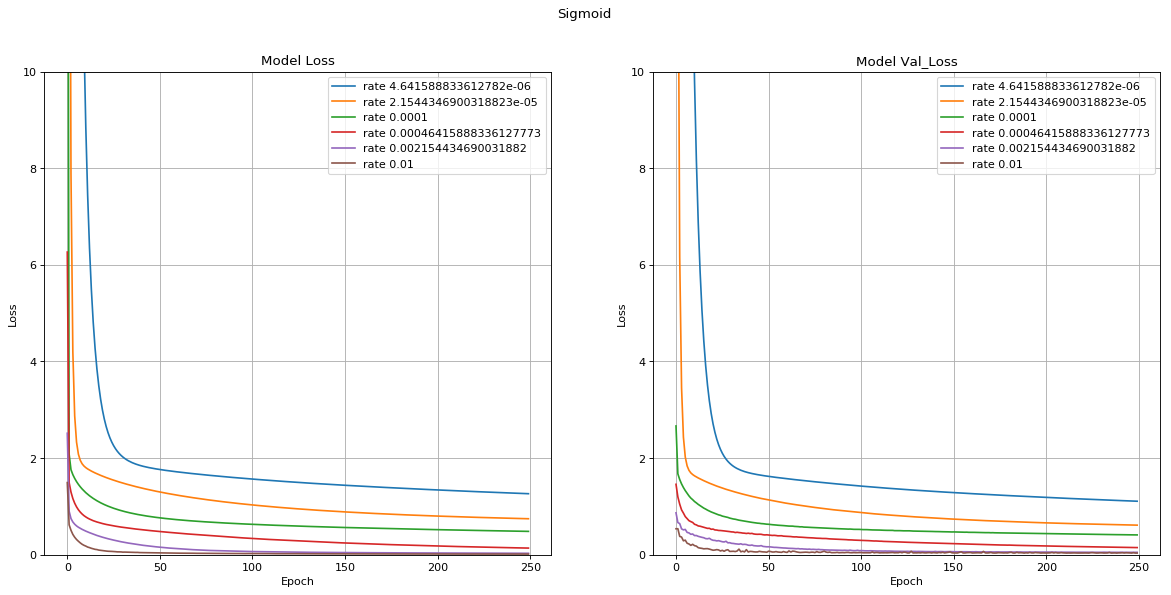

In [42]:
plt.figure(figsize=(18, 8), dpi=80, facecolor='w', edgecolor='b')
plt.suptitle("Sigmoid")
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'])
plt.plot(history2.history['loss'])
plt.plot(history3.history['loss'])
plt.plot(history4.history['loss'])
plt.plot(history5.history['loss'])
plt.plot(history6.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,10)
plt.grid(True)
plt.legend(['rate ' + str(lear_decay[1]), 'rate ' + str(lear_decay[2]), 'rate ' + str(lear_decay[3]),
            'rate ' + str(lear_decay[4]), 'rate ' + str(lear_decay[5]), 'rate ' + str(lear_decay[6])], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history1.history['val_loss'])
plt.plot(history2.history['val_loss'])
plt.plot(history3.history['val_loss'])
plt.plot(history4.history['val_loss'])
plt.plot(history5.history['val_loss'])
plt.plot(history6.history['val_loss'])
plt.title('Model Val_Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,10)
plt.legend(['rate ' + str(lear_decay[1]), 'rate ' + str(lear_decay[2]), 'rate ' + str(lear_decay[3]),
            'rate ' + str(lear_decay[4]), 'rate ' + str(lear_decay[5]), 'rate ' + str(lear_decay[6])], loc='upper right')
plt.grid(True)
plt.show()

Podemos apreciar en el gráfico que el valor de learning rate debe ser pequeño, pero no lo suficiente. Por una parte sabemos que con un valor pequeño de learning rate el entrenamiento no divergera, pero mientras más pequeño sea, menos afectará el gradiente en la actualización de los pesos, por lo que la función de error no bajará tanto. Vemos que para el valor de 0.01 obtenemos valores de error más bajas, tal cual como lo comprobamos en b usando sigmoid. Por otra parte, vemos que en el set de validación también se obtienen errores casi parecidos a lo de entrenamiento, por lo que se puede decir que la red esta bien entrenada. Ahora, se hará el mismo experimento pero usando la función de activación ReLu

In [124]:
for i in range(0,10):
    print("Para learning rate: " + str(lear_decay[i]) + "\n")
    sgd = SGD(lr=0.2, decay=lear_decay[i])
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
    model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    model.compile(optimizer=sgd,loss='mean_squared_error')
    model.fit(a, y_train, epochs=250, verbose=1, validation_data=(a_val_scaled, y_val), callbacks=[TerminateOnNaN()])

Para learning rate: 1e-06

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
  32/9745 [..............................] - ETA: 27:59 - loss: 125.5880Batch 3: Invalid loss, terminating training
Para learning rate: 4.641588833612782e-06

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
  32/9745 [..............................] - ETA: 28:00 - loss: 135.8452Batch 3: Invalid loss, terminating training
Para learning rate: 2.1544346900318823e-05

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
  32/9745 [..............................] - ETA: 28:09 - loss: 124.0993Batch 3: Invalid loss, terminating training
Para learning rate: 0.0001

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
  32/9745 [..............................] - ETA: 28:11 - loss: 142.4445Batch 3: Invalid loss, terminating training
Para learning rate: 0.00046415888336127773

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
  32/9745 [..............................] - ETA: 

Se esperaba que con esta función de activación tampoco funcionara, debido al recorrido que tiene la función. Al ser una función lineal desde 0 a +inf, implica que sus resultados son mas grandes, lo que puede producir estimaciones con mas error en el principio. Probando el otro caso utilizado en sigmoid:

In [39]:
historyReluDecay = list()
for i in range(0,10):
    print("Para learning rate: " + str(lear_decay[i]) + "\n")
    sgd = SGD(lr=lear_decay[i], decay=1e-6)
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
    model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    model.compile(optimizer=sgd,loss='mean_squared_error')
    historyReluDecay.append(model.fit(a, y_train, epochs=250, verbose=1, validation_data=(a_val_scaled, y_val), callbacks=[TerminateOnNaN()]))

Para learning rate: 1e-06

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 3s 357us/step - loss: 136.3856 - val_loss: 152.2006
Epoch 2/250
9745/9745 [==============================] - 2s 197us/step - loss: 130.2239 - val_loss: 144.8600
Epoch 3/250
9745/9745 [==============================] - 2s 197us/step - loss: 124.5484 - val_loss: 138.0928
Epoch 4/250
9745/9745 [==============================] - 2s 198us/step - loss: 119.2222 - val_loss: 131.7804
Epoch 5/250
9745/9745 [==============================] - 2s 197us/step - loss: 114.1921 - val_loss: 125.8488
Epoch 6/250
9745/9745 [==============================] - 2s 196us/step - loss: 109.4077 - val_loss: 120.2623
Epoch 7/250
9745/9745 [==============================] - 2s 200us/step - loss: 104.8495 - val_loss: 114.9940
Epoch 8/250
9745/9745 [==============================] - 2s 198us/step - loss: 100.5113 - val_loss: 110.0591
Epoch 9/250
9745/9745 [==============================

9745/9745 [==============================] - 2s 200us/step - loss: 15.5910 - val_loss: 20.1259
Epoch 77/250
9745/9745 [==============================] - 2s 196us/step - loss: 15.4245 - val_loss: 19.9290
Epoch 78/250
9745/9745 [==============================] - 2s 197us/step - loss: 15.2637 - val_loss: 19.7366
Epoch 79/250
9745/9745 [==============================] - 2s 197us/step - loss: 15.1076 - val_loss: 19.5513
Epoch 80/250
9745/9745 [==============================] - 2s 198us/step - loss: 14.9555 - val_loss: 19.3717
Epoch 81/250
9745/9745 [==============================] - 2s 197us/step - loss: 14.8085 - val_loss: 19.1948
Epoch 82/250
9745/9745 [==============================] - 2s 196us/step - loss: 14.6653 - val_loss: 19.0222
Epoch 83/250
9745/9745 [==============================] - 2s 195us/step - loss: 14.5265 - val_loss: 18.8553
Epoch 84/250
9745/9745 [==============================] - 2s 198us/step - loss: 14.3914 - val_loss: 18.6923
Epoch 85/250
9745/9745 [=================

9745/9745 [==============================] - 2s 196us/step - loss: 5.9120 - val_loss: 8.3632
Epoch 228/250
9745/9745 [==============================] - 2s 197us/step - loss: 5.8801 - val_loss: 8.3245
Epoch 229/250
9745/9745 [==============================] - 2s 197us/step - loss: 5.8485 - val_loss: 8.2872
Epoch 230/250
9745/9745 [==============================] - 2s 197us/step - loss: 5.8173 - val_loss: 8.2487
Epoch 231/250
9745/9745 [==============================] - 2s 196us/step - loss: 5.7860 - val_loss: 8.2102
Epoch 232/250
9745/9745 [==============================] - 2s 196us/step - loss: 5.7552 - val_loss: 8.1738
Epoch 233/250
9745/9745 [==============================] - 2s 197us/step - loss: 5.7246 - val_loss: 8.1375
Epoch 234/250
9745/9745 [==============================] - 2s 197us/step - loss: 5.6943 - val_loss: 8.0993
Epoch 235/250
9745/9745 [==============================] - 2s 200us/step - loss: 5.6639 - val_loss: 8.0639
Epoch 236/250
9745/9745 [==========================

9745/9745 [==============================] - 2s 197us/step - loss: 1.6837 - val_loss: 3.1771
Epoch 130/250
9745/9745 [==============================] - 2s 198us/step - loss: 1.6717 - val_loss: 3.1563
Epoch 131/250
9745/9745 [==============================] - 2s 196us/step - loss: 1.6591 - val_loss: 3.1417
Epoch 132/250
9745/9745 [==============================] - 2s 197us/step - loss: 1.6463 - val_loss: 3.1342
Epoch 133/250
9745/9745 [==============================] - 2s 199us/step - loss: 1.6352 - val_loss: 3.1095
Epoch 134/250
9745/9745 [==============================] - 2s 199us/step - loss: 1.6234 - val_loss: 3.0899
Epoch 135/250
9745/9745 [==============================] - 2s 198us/step - loss: 1.6121 - val_loss: 3.0803
Epoch 136/250
9745/9745 [==============================] - 2s 200us/step - loss: 1.5997 - val_loss: 3.0764
Epoch 137/250
9745/9745 [==============================] - 2s 197us/step - loss: 1.5905 - val_loss: 3.0585
Epoch 138/250
9745/9745 [==========================

9745/9745 [==============================] - 2s 196us/step - loss: 1.4754 - val_loss: 2.9996
Epoch 32/250
9745/9745 [==============================] - 2s 199us/step - loss: 1.4381 - val_loss: 2.9727
Epoch 33/250
9745/9745 [==============================] - 2s 198us/step - loss: 1.3972 - val_loss: 2.8834
Epoch 34/250
9745/9745 [==============================] - 2s 196us/step - loss: 1.3591 - val_loss: 2.8386
Epoch 35/250
9745/9745 [==============================] - 2s 197us/step - loss: 1.3240 - val_loss: 2.8042
Epoch 36/250
9745/9745 [==============================] - 2s 200us/step - loss: 1.2905 - val_loss: 2.7879
Epoch 37/250
9745/9745 [==============================] - 2s 199us/step - loss: 1.2611 - val_loss: 2.7262
Epoch 38/250
9745/9745 [==============================] - 2s 196us/step - loss: 1.2336 - val_loss: 2.6881
Epoch 39/250
9745/9745 [==============================] - 2s 196us/step - loss: 1.2068 - val_loss: 2.6649
Epoch 40/250
9745/9745 [==============================] - 2

9745/9745 [==============================] - 2s 199us/step - loss: 0.3858 - val_loss: 1.5505
Epoch 185/250
9745/9745 [==============================] - 2s 200us/step - loss: 0.3843 - val_loss: 1.5422
Epoch 186/250
9745/9745 [==============================] - 2s 199us/step - loss: 0.3827 - val_loss: 1.5328
Epoch 187/250
9745/9745 [==============================] - 2s 196us/step - loss: 0.3810 - val_loss: 1.5278
Epoch 188/250
9745/9745 [==============================] - 2s 199us/step - loss: 0.3795 - val_loss: 1.5307
Epoch 189/250
9745/9745 [==============================] - 2s 197us/step - loss: 0.3782 - val_loss: 1.5211
Epoch 190/250
9745/9745 [==============================] - 2s 197us/step - loss: 0.3767 - val_loss: 1.5109
Epoch 191/250
9745/9745 [==============================] - 2s 196us/step - loss: 0.3750 - val_loss: 1.5222
Epoch 192/250
9745/9745 [==============================] - 2s 197us/step - loss: 0.3735 - val_loss: 1.5138
Epoch 193/250
9745/9745 [==========================

9745/9745 [==============================] - 2s 198us/step - loss: 0.2074 - val_loss: 1.3806
Epoch 88/250
9745/9745 [==============================] - 2s 197us/step - loss: 0.2057 - val_loss: 1.3995
Epoch 89/250
9745/9745 [==============================] - 2s 196us/step - loss: 0.2038 - val_loss: 1.3843
Epoch 90/250
9745/9745 [==============================] - 2s 199us/step - loss: 0.2021 - val_loss: 1.3564
Epoch 91/250
9745/9745 [==============================] - 2s 199us/step - loss: 0.1987 - val_loss: 1.3663
Epoch 92/250
9745/9745 [==============================] - 2s 199us/step - loss: 0.1976 - val_loss: 1.3953
Epoch 93/250
9745/9745 [==============================] - 2s 199us/step - loss: 0.1968 - val_loss: 1.3789
Epoch 94/250
9745/9745 [==============================] - 2s 198us/step - loss: 0.1949 - val_loss: 1.3366
Epoch 95/250
9745/9745 [==============================] - 2s 198us/step - loss: 0.1922 - val_loss: 1.3599
Epoch 96/250
9745/9745 [==============================] - 2

Epoch 164/250
9745/9745 [==============================] - 2s 198us/step - loss: 0.1197 - val_loss: 1.0644
Epoch 165/250
9745/9745 [==============================] - 2s 200us/step - loss: 0.1191 - val_loss: 1.0793
Epoch 166/250
9745/9745 [==============================] - 2s 200us/step - loss: 0.1185 - val_loss: 1.0679
Epoch 167/250
9745/9745 [==============================] - 2s 200us/step - loss: 0.1182 - val_loss: 1.0883
Epoch 168/250
9745/9745 [==============================] - 2s 197us/step - loss: 0.1176 - val_loss: 1.1288
Epoch 169/250
9745/9745 [==============================] - 2s 197us/step - loss: 0.1166 - val_loss: 1.0716
Epoch 170/250
9745/9745 [==============================] - 2s 197us/step - loss: 0.1162 - val_loss: 1.0889
Epoch 171/250
9745/9745 [==============================] - 2s 200us/step - loss: 0.1156 - val_loss: 1.0829
Epoch 172/250
9745/9745 [==============================] - 2s 197us/step - loss: 0.1144 - val_loss: 1.0500
Epoch 173/250
9745/9745 [============

9745/9745 [==============================] - 2s 199us/step - loss: 0.1015 - val_loss: 0.6149
Epoch 67/250
9745/9745 [==============================] - 2s 198us/step - loss: 0.0932 - val_loss: 0.6758
Epoch 68/250
9745/9745 [==============================] - 2s 199us/step - loss: 0.0931 - val_loss: 0.5916
Epoch 69/250
9745/9745 [==============================] - 2s 197us/step - loss: 0.0876 - val_loss: 0.5951
Epoch 70/250
9745/9745 [==============================] - 2s 199us/step - loss: 0.0888 - val_loss: 0.6270
Epoch 71/250
9745/9745 [==============================] - 2s 199us/step - loss: 0.0908 - val_loss: 0.5933
Epoch 72/250
9745/9745 [==============================] - 2s 199us/step - loss: 0.0833 - val_loss: 0.5879
Epoch 73/250
9745/9745 [==============================] - 2s 200us/step - loss: 0.0866 - val_loss: 0.6006
Epoch 74/250
9745/9745 [==============================] - 2s 197us/step - loss: 0.0840 - val_loss: 0.5945
Epoch 75/250
9745/9745 [==============================] - 2

9745/9745 [==============================] - 2s 197us/step - loss: 0.0556 - val_loss: 0.4501
Epoch 144/250
9745/9745 [==============================] - 2s 199us/step - loss: 0.0475 - val_loss: 0.4369
Epoch 145/250
9745/9745 [==============================] - 2s 197us/step - loss: 0.0477 - val_loss: 0.4499
Epoch 146/250
9745/9745 [==============================] - 2s 197us/step - loss: 0.0472 - val_loss: 0.4668
Epoch 147/250
9745/9745 [==============================] - 2s 199us/step - loss: 0.0474 - val_loss: 0.4210
Epoch 148/250
9745/9745 [==============================] - 2s 196us/step - loss: 0.0573 - val_loss: 0.4285
Epoch 149/250
9745/9745 [==============================] - 2s 199us/step - loss: 0.0543 - val_loss: 0.4654
Epoch 150/250
9745/9745 [==============================] - 2s 199us/step - loss: 0.0482 - val_loss: 0.4571
Epoch 151/250
9745/9745 [==============================] - 2s 197us/step - loss: 0.0456 - val_loss: 0.4199
Epoch 152/250
9745/9745 [==========================

9745/9745 [==============================] - 2s 195us/step - loss: 0.0902 - val_loss: 0.2339
Epoch 46/250
9745/9745 [==============================] - 2s 198us/step - loss: 0.0803 - val_loss: 0.1963
Epoch 47/250
9745/9745 [==============================] - 2s 196us/step - loss: 0.0691 - val_loss: 0.8259
Epoch 48/250
9745/9745 [==============================] - 2s 202us/step - loss: 0.0896 - val_loss: 0.2100
Epoch 49/250
9745/9745 [==============================] - 2s 199us/step - loss: 0.0815 - val_loss: 0.1742
Epoch 50/250
9745/9745 [==============================] - 2s 200us/step - loss: 0.0739 - val_loss: 0.2840
Epoch 51/250
9745/9745 [==============================] - 2s 199us/step - loss: 0.0837 - val_loss: 0.1811
Epoch 52/250
9745/9745 [==============================] - 2s 198us/step - loss: 0.0687 - val_loss: 0.2025
Epoch 53/250
9745/9745 [==============================] - 2s 198us/step - loss: 0.0853 - val_loss: 0.1659
Epoch 54/250
9745/9745 [==============================] - 2

9745/9745 [==============================] - 2s 199us/step - loss: 0.0335 - val_loss: 0.1230
Epoch 199/250
9745/9745 [==============================] - 2s 198us/step - loss: 0.0245 - val_loss: 0.1377
Epoch 200/250
9745/9745 [==============================] - 2s 199us/step - loss: 0.0271 - val_loss: 0.1318
Epoch 201/250
9745/9745 [==============================] - 2s 197us/step - loss: 0.0302 - val_loss: 0.1378
Epoch 202/250
9745/9745 [==============================] - 2s 195us/step - loss: 0.0261 - val_loss: 0.1258
Epoch 203/250
9745/9745 [==============================] - 2s 198us/step - loss: 0.0265 - val_loss: 0.1247
Epoch 204/250
9745/9745 [==============================] - 2s 188us/step - loss: 0.0251 - val_loss: 0.1340
Epoch 205/250
9745/9745 [==============================] - 2s 194us/step - loss: 0.0280 - val_loss: 0.1295
Epoch 206/250
9745/9745 [==============================] - 2s 197us/step - loss: 0.0283 - val_loss: 0.1228
Epoch 207/250
9745/9745 [==========================

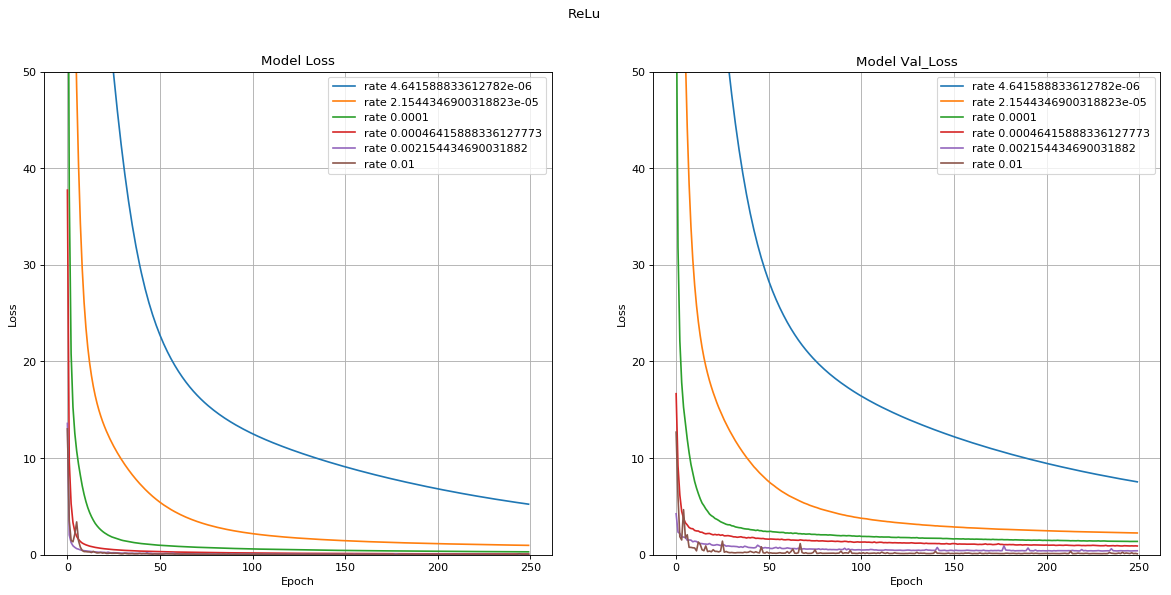

In [46]:
plt.figure(figsize=(18, 8), dpi=80, facecolor='w', edgecolor='b')
plt.subplot(1, 2, 1)
plt.suptitle("ReLu")
plt.plot(historyReluDecay[0].history['loss'])
plt.plot(historyReluDecay[1].history['loss'])
plt.plot(historyReluDecay[2].history['loss'])
plt.plot(historyReluDecay[3].history['loss'])
plt.plot(historyReluDecay[4].history['loss'])
plt.plot(historyReluDecay[5].history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,50)
plt.grid(True)
plt.legend(['rate ' + str(lear_decay[1]), 'rate ' + str(lear_decay[2]), 'rate ' + str(lear_decay[3]),
            'rate ' + str(lear_decay[4]), 'rate ' + str(lear_decay[5]), 'rate ' + str(lear_decay[6])], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(historyReluDecay[0].history['val_loss'])
plt.plot(historyReluDecay[1].history['val_loss'])
plt.plot(historyReluDecay[2].history['val_loss'])
plt.plot(historyReluDecay[3].history['val_loss'])
plt.plot(historyReluDecay[4].history['val_loss'])
plt.plot(historyReluDecay[5].history['val_loss'])
plt.title('Model Val_Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,50)
plt.legend(['rate ' + str(lear_decay[1]), 'rate ' + str(lear_decay[2]), 'rate ' + str(lear_decay[3]),
            'rate ' + str(lear_decay[4]), 'rate ' + str(lear_decay[5]), 'rate ' + str(lear_decay[6])], loc='upper right')
plt.grid(True)
plt.show()

Vemos que el modelo converge igual que en sigmoid, lo que reafirma la influencia del learning rate en el entrenamiento. Cabe destacar eso si que mientras aumenta el learning rate, el error de validación tiende a ser mas difuso.

### 1.f Mini-Batch

Se usazará mini-batch, alternando en 20 valores distintos de batch, los cuales fueron extraídos de un rango de 0 a 9745, que son la cantidad de muestras en entrenamiento. Se comienza con la función de activación sigmoid. Se incluye progressive decay pero con un factor muy pequeño, por lo que el valor del training rate no disminuye tanto al avanzar el algoritmo.

In [53]:
n_batches = 21
batch_sizes = np.round(np.linspace(1,X_train_scaled.shape[0],n_batches))

In [61]:
historySigMini = list()
for i in range(0,21):
    print("Para tamano de mini batch: " + str(int(batch_sizes[i])) + "\n")
    sgd = SGD(lr=0.01, decay=1e-6)
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
    model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    model.compile(optimizer=sgd,loss='mean_squared_error')
    historySigMini.append(model.fit(X_train_scaled,y_train,batch_size=int(batch_sizes[i]),epochs=250,validation_data=(X_val_scaled, y_val), callbacks=[TerminateOnNaN()]))

Para tamano de mini batch: 1

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
 725/9745 [=>............................] - ETA: 1:10 - loss: 122385093503349349910458568087175168.0000Batch 732: Invalid loss, terminating training
Para tamano de mini batch: 488

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 3s 344us/step - loss: 9.9879 - val_loss: 1.2744
Epoch 2/250
9745/9745 [==============================] - 1s 57us/step - loss: 1.3175 - val_loss: 1.0355
Epoch 3/250
9745/9745 [==============================] - 1s 57us/step - loss: 1.1172 - val_loss: 0.8842
Epoch 4/250
9745/9745 [==============================] - 1s 56us/step - loss: 0.9968 - val_loss: 0.8287
Epoch 5/250
9745/9745 [==============================] - 1s 56us/step - loss: 0.9104 - val_loss: 0.7256
Epoch 6/250
9745/9745 [==============================] - 1s 58us/step - loss: 0.8459 - val_loss: 0.6736
Epoch 7/250
9745/9745 [==============================] 

9745/9745 [==============================] - 1s 57us/step - loss: 0.3261 - val_loss: 0.2936
Epoch 77/250
9745/9745 [==============================] - 1s 57us/step - loss: 0.3221 - val_loss: 0.2876
Epoch 78/250
9745/9745 [==============================] - 1s 57us/step - loss: 0.3204 - val_loss: 0.2862
Epoch 79/250
9745/9745 [==============================] - 1s 56us/step - loss: 0.3168 - val_loss: 0.2966
Epoch 80/250
9745/9745 [==============================] - 1s 56us/step - loss: 0.3137 - val_loss: 0.2862
Epoch 81/250
9745/9745 [==============================] - 1s 57us/step - loss: 0.3106 - val_loss: 0.2777
Epoch 82/250
9745/9745 [==============================] - 1s 56us/step - loss: 0.3072 - val_loss: 0.2758
Epoch 83/250
9745/9745 [==============================] - 1s 58us/step - loss: 0.3046 - val_loss: 0.2838
Epoch 84/250
9745/9745 [==============================] - 1s 59us/step - loss: 0.3025 - val_loss: 0.2749
Epoch 85/250
9745/9745 [==============================] - 1s 57us/st

9745/9745 [==============================] - 1s 57us/step - loss: 0.0930 - val_loss: 0.1078
Epoch 231/250
9745/9745 [==============================] - 1s 57us/step - loss: 0.0927 - val_loss: 0.1068
Epoch 232/250
9745/9745 [==============================] - 1s 57us/step - loss: 0.0925 - val_loss: 0.1068
Epoch 233/250
9745/9745 [==============================] - 1s 55us/step - loss: 0.0918 - val_loss: 0.1060
Epoch 234/250
9745/9745 [==============================] - 1s 58us/step - loss: 0.0910 - val_loss: 0.1076
Epoch 235/250
9745/9745 [==============================] - 1s 56us/step - loss: 0.0904 - val_loss: 0.1066
Epoch 236/250
9745/9745 [==============================] - 1s 56us/step - loss: 0.0899 - val_loss: 0.1054
Epoch 237/250
9745/9745 [==============================] - 1s 57us/step - loss: 0.0897 - val_loss: 0.1051
Epoch 238/250
9745/9745 [==============================] - 1s 56us/step - loss: 0.0901 - val_loss: 0.1044
Epoch 239/250
9745/9745 [==============================] - 1

Epoch 135/250
9745/9745 [==============================] - 0s 47us/step - loss: 0.3653 - val_loss: 0.3179
Epoch 136/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.3628 - val_loss: 0.3167
Epoch 137/250
9745/9745 [==============================] - 0s 47us/step - loss: 0.3599 - val_loss: 0.3163
Epoch 138/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.3587 - val_loss: 0.3158
Epoch 139/250
9745/9745 [==============================] - 0s 47us/step - loss: 0.3576 - val_loss: 0.3130
Epoch 140/250
9745/9745 [==============================] - 0s 47us/step - loss: 0.3549 - val_loss: 0.3155
Epoch 141/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.3533 - val_loss: 0.3105
Epoch 142/250
9745/9745 [==============================] - 0s 47us/step - loss: 0.3508 - val_loss: 0.3098
Epoch 143/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.3495 - val_loss: 0.3101
Epoch 144/250
9745/9745 [=====================

9745/9745 [==============================] - 0s 45us/step - loss: 0.6511 - val_loss: 0.5439
Epoch 40/250
9745/9745 [==============================] - 0s 44us/step - loss: 0.6463 - val_loss: 0.5361
Epoch 41/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.6422 - val_loss: 0.5264
Epoch 42/250
9745/9745 [==============================] - 0s 44us/step - loss: 0.6380 - val_loss: 0.5234
Epoch 43/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.6340 - val_loss: 0.5222
Epoch 44/250
9745/9745 [==============================] - 0s 44us/step - loss: 0.6298 - val_loss: 0.5230
Epoch 45/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.6249 - val_loss: 0.5149
Epoch 46/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.6217 - val_loss: 0.5140
Epoch 47/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.6184 - val_loss: 0.5052
Epoch 48/250
9745/9745 [==============================] - 0s 45us/st

Epoch 117/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.4641 - val_loss: 0.3918
Epoch 118/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.4617 - val_loss: 0.3940
Epoch 119/250
9745/9745 [==============================] - 0s 44us/step - loss: 0.4614 - val_loss: 0.3891
Epoch 120/250
9745/9745 [==============================] - 0s 44us/step - loss: 0.4592 - val_loss: 0.3928
Epoch 121/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.4587 - val_loss: 0.3926
Epoch 122/250
9745/9745 [==============================] - 0s 44us/step - loss: 0.4561 - val_loss: 0.3878
Epoch 123/250
9745/9745 [==============================] - 0s 44us/step - loss: 0.4542 - val_loss: 0.3833
Epoch 124/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.4529 - val_loss: 0.3812
Epoch 125/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.4513 - val_loss: 0.3795
Epoch 126/250
9745/9745 [=====================

Epoch 21/250
9745/9745 [==============================] - 0s 43us/step - loss: 0.8932 - val_loss: 0.7334
Epoch 22/250
9745/9745 [==============================] - 0s 43us/step - loss: 0.8801 - val_loss: 0.7127
Epoch 23/250
9745/9745 [==============================] - 0s 43us/step - loss: 0.8659 - val_loss: 0.7090
Epoch 24/250
9745/9745 [==============================] - 0s 42us/step - loss: 0.8535 - val_loss: 0.6985
Epoch 25/250
9745/9745 [==============================] - 0s 43us/step - loss: 0.8406 - val_loss: 0.6847
Epoch 26/250
9745/9745 [==============================] - 0s 43us/step - loss: 0.8322 - val_loss: 0.6743
Epoch 27/250
9745/9745 [==============================] - 0s 43us/step - loss: 0.8206 - val_loss: 0.6650
Epoch 28/250
9745/9745 [==============================] - 0s 43us/step - loss: 0.8093 - val_loss: 0.6622
Epoch 29/250
9745/9745 [==============================] - 0s 43us/step - loss: 0.7997 - val_loss: 0.6568
Epoch 30/250
9745/9745 [==============================]

9745/9745 [==============================] - 0s 43us/step - loss: 0.5607 - val_loss: 0.4689
Epoch 100/250
9745/9745 [==============================] - 0s 42us/step - loss: 0.5592 - val_loss: 0.4667
Epoch 101/250
9745/9745 [==============================] - 0s 43us/step - loss: 0.5579 - val_loss: 0.4647
Epoch 102/250
9745/9745 [==============================] - 0s 42us/step - loss: 0.5556 - val_loss: 0.4714
Epoch 103/250
9745/9745 [==============================] - 0s 43us/step - loss: 0.5549 - val_loss: 0.4677
Epoch 104/250
9745/9745 [==============================] - 0s 42us/step - loss: 0.5528 - val_loss: 0.4616
Epoch 105/250
9745/9745 [==============================] - 0s 43us/step - loss: 0.5508 - val_loss: 0.4639
Epoch 106/250
9745/9745 [==============================] - 0s 43us/step - loss: 0.5507 - val_loss: 0.4627
Epoch 107/250
9745/9745 [==============================] - 0s 43us/step - loss: 0.5481 - val_loss: 0.4586
Epoch 108/250
9745/9745 [==============================] - 0

9745/9745 [==============================] - 0s 41us/step - loss: 1.7858 - val_loss: 1.5392
Epoch 3/250
9745/9745 [==============================] - 0s 42us/step - loss: 1.6677 - val_loss: 1.4289
Epoch 4/250
9745/9745 [==============================] - 0s 41us/step - loss: 1.5763 - val_loss: 1.3564
Epoch 5/250
9745/9745 [==============================] - 0s 42us/step - loss: 1.5043 - val_loss: 1.2856
Epoch 6/250
9745/9745 [==============================] - 0s 41us/step - loss: 1.4424 - val_loss: 1.2334
Epoch 7/250
9745/9745 [==============================] - 0s 41us/step - loss: 1.3885 - val_loss: 1.1695
Epoch 8/250
9745/9745 [==============================] - 0s 41us/step - loss: 1.3388 - val_loss: 1.1380
Epoch 9/250
9745/9745 [==============================] - 0s 41us/step - loss: 1.2975 - val_loss: 1.0899
Epoch 10/250
9745/9745 [==============================] - 0s 40us/step - loss: 1.2554 - val_loss: 1.0627
Epoch 11/250
9745/9745 [==============================] - 0s 42us/step - lo

9745/9745 [==============================] - 0s 40us/step - loss: 0.5075 - val_loss: 0.4296
Epoch 158/250
9745/9745 [==============================] - 0s 40us/step - loss: 0.5061 - val_loss: 0.4282
Epoch 159/250
9745/9745 [==============================] - 0s 41us/step - loss: 0.5053 - val_loss: 0.4276
Epoch 160/250
9745/9745 [==============================] - 0s 41us/step - loss: 0.5043 - val_loss: 0.4269
Epoch 161/250
9745/9745 [==============================] - 0s 41us/step - loss: 0.5033 - val_loss: 0.4256
Epoch 162/250
9745/9745 [==============================] - 0s 41us/step - loss: 0.5018 - val_loss: 0.4262
Epoch 163/250
9745/9745 [==============================] - 0s 41us/step - loss: 0.5009 - val_loss: 0.4252
Epoch 164/250
9745/9745 [==============================] - 0s 41us/step - loss: 0.4999 - val_loss: 0.4237
Epoch 165/250
9745/9745 [==============================] - 0s 41us/step - loss: 0.4984 - val_loss: 0.4219
Epoch 166/250
9745/9745 [==============================] - 0

9745/9745 [==============================] - 0s 41us/step - loss: 0.6708 - val_loss: 0.5510
Epoch 62/250
9745/9745 [==============================] - 0s 41us/step - loss: 0.6686 - val_loss: 0.5510
Epoch 63/250
9745/9745 [==============================] - 0s 41us/step - loss: 0.6649 - val_loss: 0.5600
Epoch 64/250
9745/9745 [==============================] - 0s 41us/step - loss: 0.6623 - val_loss: 0.5540
Epoch 65/250
9745/9745 [==============================] - 0s 42us/step - loss: 0.6596 - val_loss: 0.5530
Epoch 66/250
9745/9745 [==============================] - 0s 41us/step - loss: 0.6571 - val_loss: 0.5417
Epoch 67/250
9745/9745 [==============================] - 0s 41us/step - loss: 0.6536 - val_loss: 0.5461
Epoch 68/250
9745/9745 [==============================] - 0s 41us/step - loss: 0.6513 - val_loss: 0.5395
Epoch 69/250
9745/9745 [==============================] - 0s 41us/step - loss: 0.6484 - val_loss: 0.5322
Epoch 70/250
9745/9745 [==============================] - 0s 41us/st

Epoch 139/250
9745/9745 [==============================] - 0s 42us/step - loss: 0.5285 - val_loss: 0.4439
Epoch 140/250
9745/9745 [==============================] - 0s 41us/step - loss: 0.5275 - val_loss: 0.4415
Epoch 141/250
9745/9745 [==============================] - 0s 42us/step - loss: 0.5260 - val_loss: 0.4399
Epoch 142/250
9745/9745 [==============================] - 0s 41us/step - loss: 0.5247 - val_loss: 0.4388
Epoch 143/250
9745/9745 [==============================] - 0s 41us/step - loss: 0.5234 - val_loss: 0.4387
Epoch 144/250
9745/9745 [==============================] - 0s 41us/step - loss: 0.5228 - val_loss: 0.4378
Epoch 145/250
9745/9745 [==============================] - 0s 41us/step - loss: 0.5214 - val_loss: 0.4360
Epoch 146/250
9745/9745 [==============================] - 0s 41us/step - loss: 0.5199 - val_loss: 0.4358
Epoch 147/250
9745/9745 [==============================] - 0s 41us/step - loss: 0.5194 - val_loss: 0.4353
Epoch 148/250
9745/9745 [=====================

9745/9745 [==============================] - 0s 46us/step - loss: 0.8106 - val_loss: 0.6733
Epoch 44/250
9745/9745 [==============================] - 0s 43us/step - loss: 0.8044 - val_loss: 0.6682
Epoch 45/250
9745/9745 [==============================] - 0s 41us/step - loss: 0.7989 - val_loss: 0.6661
Epoch 46/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.7931 - val_loss: 0.6632
Epoch 47/250
9745/9745 [==============================] - 0s 44us/step - loss: 0.7882 - val_loss: 0.6569
Epoch 48/250
9745/9745 [==============================] - 0s 41us/step - loss: 0.7820 - val_loss: 0.6483
Epoch 49/250
9745/9745 [==============================] - 0s 46us/step - loss: 0.7771 - val_loss: 0.6438
Epoch 50/250
9745/9745 [==============================] - 0s 43us/step - loss: 0.7723 - val_loss: 0.6424
Epoch 51/250
9745/9745 [==============================] - 0s 41us/step - loss: 0.7679 - val_loss: 0.6358
Epoch 52/250
9745/9745 [==============================] - 0s 46us/st

Epoch 121/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.5978 - val_loss: 0.4955
Epoch 122/250
9745/9745 [==============================] - 0s 42us/step - loss: 0.5955 - val_loss: 0.4988
Epoch 123/250
9745/9745 [==============================] - 0s 41us/step - loss: 0.5945 - val_loss: 0.4970
Epoch 124/250
9745/9745 [==============================] - 0s 46us/step - loss: 0.5939 - val_loss: 0.4915
Epoch 125/250
9745/9745 [==============================] - 0s 43us/step - loss: 0.5916 - val_loss: 0.4935
Epoch 126/250
9745/9745 [==============================] - 0s 41us/step - loss: 0.5902 - val_loss: 0.4916
Epoch 127/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.5895 - val_loss: 0.4902
Epoch 128/250
9745/9745 [==============================] - 0s 44us/step - loss: 0.5883 - val_loss: 0.4903
Epoch 129/250
9745/9745 [==============================] - 0s 41us/step - loss: 0.5864 - val_loss: 0.4884
Epoch 130/250
9745/9745 [=====================

Epoch 25/250
9745/9745 [==============================] - 0s 40us/step - loss: 0.9946 - val_loss: 0.8341
Epoch 26/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.9816 - val_loss: 0.8111
Epoch 27/250
9745/9745 [==============================] - 0s 43us/step - loss: 0.9675 - val_loss: 0.8014
Epoch 28/250
9745/9745 [==============================] - 0s 40us/step - loss: 0.9544 - val_loss: 0.7997
Epoch 29/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.9420 - val_loss: 0.7836
Epoch 30/250
9745/9745 [==============================] - 0s 44us/step - loss: 0.9303 - val_loss: 0.7682
Epoch 31/250
9745/9745 [==============================] - 0s 41us/step - loss: 0.9193 - val_loss: 0.7564
Epoch 32/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.9083 - val_loss: 0.7532
Epoch 33/250
9745/9745 [==============================] - 0s 43us/step - loss: 0.8982 - val_loss: 0.7418
Epoch 34/250
9745/9745 [==============================]

Epoch 103/250
9745/9745 [==============================] - 0s 41us/step - loss: 0.6243 - val_loss: 0.5177
Epoch 104/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.6224 - val_loss: 0.5154
Epoch 105/250
9745/9745 [==============================] - 0s 43us/step - loss: 0.6203 - val_loss: 0.5159
Epoch 106/250
9745/9745 [==============================] - 0s 41us/step - loss: 0.6187 - val_loss: 0.5083
Epoch 107/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.6172 - val_loss: 0.5118
Epoch 108/250
9745/9745 [==============================] - 0s 44us/step - loss: 0.6155 - val_loss: 0.5107
Epoch 109/250
9745/9745 [==============================] - 0s 41us/step - loss: 0.6137 - val_loss: 0.5076
Epoch 110/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.6121 - val_loss: 0.5041
Epoch 111/250
9745/9745 [==============================] - 0s 43us/step - loss: 0.6108 - val_loss: 0.5089
Epoch 112/250
9745/9745 [=====================

9745/9745 [==============================] - 0s 45us/step - loss: 1.4765 - val_loss: 1.2596
Epoch 7/250
9745/9745 [==============================] - 0s 46us/step - loss: 1.4298 - val_loss: 1.2234
Epoch 8/250
9745/9745 [==============================] - 0s 46us/step - loss: 1.3858 - val_loss: 1.1944
Epoch 9/250
9745/9745 [==============================] - 0s 46us/step - loss: 1.3470 - val_loss: 1.1608
Epoch 10/250
9745/9745 [==============================] - 0s 46us/step - loss: 1.3144 - val_loss: 1.1163
Epoch 11/250
9745/9745 [==============================] - 0s 46us/step - loss: 1.2797 - val_loss: 1.0842
Epoch 12/250
9745/9745 [==============================] - 0s 45us/step - loss: 1.2481 - val_loss: 1.0486
Epoch 13/250
9745/9745 [==============================] - 0s 46us/step - loss: 1.2214 - val_loss: 1.0332
Epoch 14/250
9745/9745 [==============================] - 0s 46us/step - loss: 1.1926 - val_loss: 1.0246
Epoch 15/250
9745/9745 [==============================] - 0s 46us/step 

9745/9745 [==============================] - 0s 45us/step - loss: 0.5537 - val_loss: 0.4637
Epoch 162/250
9745/9745 [==============================] - 0s 46us/step - loss: 0.5529 - val_loss: 0.4634
Epoch 163/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.5524 - val_loss: 0.4625
Epoch 164/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.5510 - val_loss: 0.4628
Epoch 165/250
9745/9745 [==============================] - 0s 46us/step - loss: 0.5499 - val_loss: 0.4610
Epoch 166/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.5491 - val_loss: 0.4627
Epoch 167/250
9745/9745 [==============================] - 0s 46us/step - loss: 0.5481 - val_loss: 0.4595
Epoch 168/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.5471 - val_loss: 0.4583
Epoch 169/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.5464 - val_loss: 0.4576
Epoch 170/250
9745/9745 [==============================] - 0

9745/9745 [==============================] - 0s 45us/step - loss: 0.8088 - val_loss: 0.6680
Epoch 66/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.8047 - val_loss: 0.6643
Epoch 67/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.8002 - val_loss: 0.6636
Epoch 68/250
9745/9745 [==============================] - 0s 46us/step - loss: 0.7963 - val_loss: 0.6576
Epoch 69/250
9745/9745 [==============================] - 0s 46us/step - loss: 0.7925 - val_loss: 0.6547
Epoch 70/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.7885 - val_loss: 0.6537
Epoch 71/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.7853 - val_loss: 0.6514
Epoch 72/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.7813 - val_loss: 0.6461
Epoch 73/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.7780 - val_loss: 0.6416
Epoch 74/250
9745/9745 [==============================] - 0s 45us/st

9745/9745 [==============================] - 0s 45us/step - loss: 0.5618 - val_loss: 0.4681
Epoch 220/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.5611 - val_loss: 0.4689
Epoch 221/250
9745/9745 [==============================] - 0s 46us/step - loss: 0.5602 - val_loss: 0.4674
Epoch 222/250
9745/9745 [==============================] - 0s 46us/step - loss: 0.5595 - val_loss: 0.4672
Epoch 223/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.5588 - val_loss: 0.4660
Epoch 224/250
9745/9745 [==============================] - 0s 46us/step - loss: 0.5584 - val_loss: 0.4646
Epoch 225/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.5573 - val_loss: 0.4661
Epoch 226/250
9745/9745 [==============================] - 0s 46us/step - loss: 0.5565 - val_loss: 0.4646
Epoch 227/250
9745/9745 [==============================] - 0s 46us/step - loss: 0.5557 - val_loss: 0.4641
Epoch 228/250
9745/9745 [==============================] - 0

Epoch 124/250
9745/9745 [==============================] - 0s 46us/step - loss: 0.6568 - val_loss: 0.5444
Epoch 125/250
9745/9745 [==============================] - 0s 46us/step - loss: 0.6554 - val_loss: 0.5461
Epoch 126/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.6542 - val_loss: 0.5445
Epoch 127/250
9745/9745 [==============================] - 0s 46us/step - loss: 0.6524 - val_loss: 0.5409
Epoch 128/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.6509 - val_loss: 0.5423
Epoch 129/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.6501 - val_loss: 0.5418
Epoch 130/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.6488 - val_loss: 0.5403
Epoch 131/250
9745/9745 [==============================] - 0s 46us/step - loss: 0.6475 - val_loss: 0.5394
Epoch 132/250
9745/9745 [==============================] - 0s 47us/step - loss: 0.6459 - val_loss: 0.5379
Epoch 133/250
9745/9745 [=====================

Epoch 28/250
9745/9745 [==============================] - 0s 48us/step - loss: 1.0987 - val_loss: 0.9286
Epoch 29/250
9745/9745 [==============================] - 0s 48us/step - loss: 1.0858 - val_loss: 0.9164
Epoch 30/250
9745/9745 [==============================] - 0s 47us/step - loss: 1.0726 - val_loss: 0.9001
Epoch 31/250
9745/9745 [==============================] - 0s 48us/step - loss: 1.0602 - val_loss: 0.8920
Epoch 32/250
9745/9745 [==============================] - 0s 48us/step - loss: 1.0489 - val_loss: 0.8837
Epoch 33/250
9745/9745 [==============================] - 0s 47us/step - loss: 1.0368 - val_loss: 0.8639
Epoch 34/250
9745/9745 [==============================] - 0s 47us/step - loss: 1.0264 - val_loss: 0.8550
Epoch 35/250
9745/9745 [==============================] - 0s 47us/step - loss: 1.0150 - val_loss: 0.8490
Epoch 36/250
9745/9745 [==============================] - 0s 48us/step - loss: 1.0049 - val_loss: 0.8401
Epoch 37/250
9745/9745 [==============================]

Epoch 106/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.6973 - val_loss: 0.5726
Epoch 107/250
9745/9745 [==============================] - 0s 47us/step - loss: 0.6952 - val_loss: 0.5776
Epoch 108/250
9745/9745 [==============================] - 0s 47us/step - loss: 0.6943 - val_loss: 0.5747
Epoch 109/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.6915 - val_loss: 0.5684
Epoch 110/250
9745/9745 [==============================] - 0s 47us/step - loss: 0.6892 - val_loss: 0.5667
Epoch 111/250
9745/9745 [==============================] - 0s 47us/step - loss: 0.6875 - val_loss: 0.5655
Epoch 112/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.6857 - val_loss: 0.5659
Epoch 113/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.6840 - val_loss: 0.5633
Epoch 114/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.6825 - val_loss: 0.5609
Epoch 115/250
9745/9745 [=====================

Epoch 10/250
9745/9745 [==============================] - 0s 47us/step - loss: 1.4614 - val_loss: 1.2684
Epoch 11/250
9745/9745 [==============================] - 0s 47us/step - loss: 1.4286 - val_loss: 1.2399
Epoch 12/250
9745/9745 [==============================] - 0s 48us/step - loss: 1.3976 - val_loss: 1.2090
Epoch 13/250
9745/9745 [==============================] - 0s 48us/step - loss: 1.3694 - val_loss: 1.1842
Epoch 14/250
9745/9745 [==============================] - 0s 48us/step - loss: 1.3439 - val_loss: 1.1519
Epoch 15/250
9745/9745 [==============================] - 0s 48us/step - loss: 1.3216 - val_loss: 1.1307
Epoch 16/250
9745/9745 [==============================] - 0s 47us/step - loss: 1.2971 - val_loss: 1.1104
Epoch 17/250
9745/9745 [==============================] - 0s 48us/step - loss: 1.2745 - val_loss: 1.0897
Epoch 18/250
9745/9745 [==============================] - 0s 48us/step - loss: 1.2538 - val_loss: 1.0765
Epoch 19/250
9745/9745 [==============================]

9745/9745 [==============================] - 0s 48us/step - loss: 0.7422 - val_loss: 0.6077
Epoch 89/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.7399 - val_loss: 0.6091
Epoch 90/250
9745/9745 [==============================] - 0s 47us/step - loss: 0.7372 - val_loss: 0.6013
Epoch 91/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.7345 - val_loss: 0.6030
Epoch 92/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.7322 - val_loss: 0.6005
Epoch 93/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.7299 - val_loss: 0.5993
Epoch 94/250
9745/9745 [==============================] - 0s 47us/step - loss: 0.7275 - val_loss: 0.5955
Epoch 95/250
9745/9745 [==============================] - 0s 47us/step - loss: 0.7252 - val_loss: 0.5947
Epoch 96/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.7229 - val_loss: 0.5936
Epoch 97/250
9745/9745 [==============================] - 0s 47us/st

9745/9745 [==============================] - 0s 47us/step - loss: 0.5533 - val_loss: 0.4604
Epoch 243/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.5533 - val_loss: 0.4597
Epoch 244/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.5519 - val_loss: 0.4607
Epoch 245/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.5511 - val_loss: 0.4605
Epoch 246/250
9745/9745 [==============================] - 0s 49us/step - loss: 0.5503 - val_loss: 0.4583
Epoch 247/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.5501 - val_loss: 0.4571
Epoch 248/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.5500 - val_loss: 0.4564
Epoch 249/250
9745/9745 [==============================] - 0s 47us/step - loss: 0.5493 - val_loss: 0.4557
Epoch 250/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.5484 - val_loss: 0.4564
Para tamano de mini batch: 6822

Train on 9745 samples, vali

9745/9745 [==============================] - 0s 48us/step - loss: 0.6440 - val_loss: 0.5305
Epoch 147/250
9745/9745 [==============================] - 0s 47us/step - loss: 0.6428 - val_loss: 0.5276
Epoch 148/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.6416 - val_loss: 0.5272
Epoch 149/250
9745/9745 [==============================] - 0s 47us/step - loss: 0.6405 - val_loss: 0.5254
Epoch 150/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.6395 - val_loss: 0.5286
Epoch 151/250
9745/9745 [==============================] - 0s 47us/step - loss: 0.6392 - val_loss: 0.5294
Epoch 152/250
9745/9745 [==============================] - 0s 47us/step - loss: 0.6382 - val_loss: 0.5262
Epoch 153/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.6364 - val_loss: 0.5248
Epoch 154/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.6350 - val_loss: 0.5223
Epoch 155/250
9745/9745 [==============================] - 0

9745/9745 [==============================] - 0s 46us/step - loss: 0.8683 - val_loss: 0.7212
Epoch 51/250
9745/9745 [==============================] - 0s 47us/step - loss: 0.8622 - val_loss: 0.7040
Epoch 52/250
9745/9745 [==============================] - 0s 46us/step - loss: 0.8571 - val_loss: 0.7085
Epoch 53/250
9745/9745 [==============================] - 0s 46us/step - loss: 0.8510 - val_loss: 0.6975
Epoch 54/250
9745/9745 [==============================] - 0s 46us/step - loss: 0.8459 - val_loss: 0.6956
Epoch 55/250
9745/9745 [==============================] - 0s 46us/step - loss: 0.8402 - val_loss: 0.6927
Epoch 56/250
9745/9745 [==============================] - 0s 46us/step - loss: 0.8351 - val_loss: 0.6850
Epoch 57/250
9745/9745 [==============================] - 0s 46us/step - loss: 0.8305 - val_loss: 0.6784
Epoch 58/250
9745/9745 [==============================] - 0s 46us/step - loss: 0.8272 - val_loss: 0.6757
Epoch 59/250
9745/9745 [==============================] - 0s 45us/st

Epoch 128/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.6510 - val_loss: 0.5363
Epoch 129/250
9745/9745 [==============================] - 0s 46us/step - loss: 0.6492 - val_loss: 0.5341
Epoch 130/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.6477 - val_loss: 0.5341
Epoch 131/250
9745/9745 [==============================] - 0s 46us/step - loss: 0.6464 - val_loss: 0.5359
Epoch 132/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.6454 - val_loss: 0.5319
Epoch 133/250
9745/9745 [==============================] - 0s 46us/step - loss: 0.6437 - val_loss: 0.5299
Epoch 134/250
9745/9745 [==============================] - 0s 45us/step - loss: 0.6420 - val_loss: 0.5290
Epoch 135/250
9745/9745 [==============================] - 0s 46us/step - loss: 0.6407 - val_loss: 0.5288
Epoch 136/250
9745/9745 [==============================] - 0s 46us/step - loss: 0.6398 - val_loss: 0.5307
Epoch 137/250
9745/9745 [=====================

9745/9745 [==============================] - 0s 48us/step - loss: 1.0526 - val_loss: 0.8617
Epoch 33/250
9745/9745 [==============================] - 0s 48us/step - loss: 1.0416 - val_loss: 0.8638
Epoch 34/250
9745/9745 [==============================] - 0s 48us/step - loss: 1.0272 - val_loss: 0.8436
Epoch 35/250
9745/9745 [==============================] - 0s 47us/step - loss: 1.0182 - val_loss: 0.8406
Epoch 36/250
9745/9745 [==============================] - 0s 49us/step - loss: 1.0058 - val_loss: 0.8270
Epoch 37/250
9745/9745 [==============================] - 0s 47us/step - loss: 0.9958 - val_loss: 0.8241
Epoch 38/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.9858 - val_loss: 0.8151
Epoch 39/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.9763 - val_loss: 0.8041
Epoch 40/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.9672 - val_loss: 0.7991
Epoch 41/250
9745/9745 [==============================] - 0s 47us/st

9745/9745 [==============================] - 0s 48us/step - loss: 0.6869 - val_loss: 0.5612
Epoch 111/250
9745/9745 [==============================] - 0s 47us/step - loss: 0.6849 - val_loss: 0.5642
Epoch 112/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.6831 - val_loss: 0.5617
Epoch 113/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.6814 - val_loss: 0.5592
Epoch 114/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.6797 - val_loss: 0.5585
Epoch 115/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.6780 - val_loss: 0.5544
Epoch 116/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.6765 - val_loss: 0.5660
Epoch 117/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.6766 - val_loss: 0.5569
Epoch 118/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.6732 - val_loss: 0.5545
Epoch 119/250
9745/9745 [==============================] - 0

Epoch 14/250
9745/9745 [==============================] - 0s 50us/step - loss: 1.3669 - val_loss: 1.1702
Epoch 15/250
9745/9745 [==============================] - 0s 50us/step - loss: 1.3406 - val_loss: 1.1433
Epoch 16/250
9745/9745 [==============================] - 0s 48us/step - loss: 1.3169 - val_loss: 1.1316
Epoch 17/250
9745/9745 [==============================] - 0s 49us/step - loss: 1.2946 - val_loss: 1.1136
Epoch 18/250
9745/9745 [==============================] - 0s 50us/step - loss: 1.2723 - val_loss: 1.0743
Epoch 19/250
9745/9745 [==============================] - 0s 49us/step - loss: 1.2566 - val_loss: 1.0673
Epoch 20/250
9745/9745 [==============================] - 0s 49us/step - loss: 1.2326 - val_loss: 1.0491
Epoch 21/250
9745/9745 [==============================] - 0s 49us/step - loss: 1.2136 - val_loss: 1.0225
Epoch 22/250
9745/9745 [==============================] - 0s 49us/step - loss: 1.1968 - val_loss: 1.0001
Epoch 23/250
9745/9745 [==============================]

9745/9745 [==============================] - 0s 50us/step - loss: 0.7233 - val_loss: 0.5950
Epoch 93/250
9745/9745 [==============================] - 0s 49us/step - loss: 0.7206 - val_loss: 0.5890
Epoch 94/250
9745/9745 [==============================] - 0s 49us/step - loss: 0.7192 - val_loss: 0.5887
Epoch 95/250
9745/9745 [==============================] - 0s 50us/step - loss: 0.7162 - val_loss: 0.5901
Epoch 96/250
9745/9745 [==============================] - 0s 49us/step - loss: 0.7139 - val_loss: 0.5856
Epoch 97/250
9745/9745 [==============================] - 0s 49us/step - loss: 0.7125 - val_loss: 0.5787
Epoch 98/250
9745/9745 [==============================] - 0s 50us/step - loss: 0.7117 - val_loss: 0.5859
Epoch 99/250
9745/9745 [==============================] - 0s 49us/step - loss: 0.7073 - val_loss: 0.5831
Epoch 100/250
9745/9745 [==============================] - 0s 51us/step - loss: 0.7052 - val_loss: 0.5867
Epoch 101/250
9745/9745 [==============================] - 0s 50us/

9745/9745 [==============================] - 0s 50us/step - loss: 0.5405 - val_loss: 0.4518
Epoch 247/250
9745/9745 [==============================] - 0s 50us/step - loss: 0.5388 - val_loss: 0.4518
Epoch 248/250
9745/9745 [==============================] - 0s 50us/step - loss: 0.5383 - val_loss: 0.4503
Epoch 249/250
9745/9745 [==============================] - 0s 49us/step - loss: 0.5376 - val_loss: 0.4487
Epoch 250/250
9745/9745 [==============================] - 0s 50us/step - loss: 0.5376 - val_loss: 0.4494
Para tamano de mini batch: 8771

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 4s 370us/step - loss: 117.6477 - val_loss: 6.1509
Epoch 2/250
9745/9745 [==============================] - 0s 49us/step - loss: 5.0911 - val_loss: 1.7682
Epoch 3/250
9745/9745 [==============================] - 0s 49us/step - loss: 1.8850 - val_loss: 1.5876
Epoch 4/250
9745/9745 [==============================] - 0s 49us/step - loss: 1.7468 - v

9745/9745 [==============================] - 0s 50us/step - loss: 0.6301 - val_loss: 0.5204
Epoch 151/250
9745/9745 [==============================] - 0s 49us/step - loss: 0.6284 - val_loss: 0.5202
Epoch 152/250
9745/9745 [==============================] - 0s 50us/step - loss: 0.6282 - val_loss: 0.5237
Epoch 153/250
9745/9745 [==============================] - 0s 49us/step - loss: 0.6261 - val_loss: 0.5259
Epoch 154/250
9745/9745 [==============================] - 0s 49us/step - loss: 0.6255 - val_loss: 0.5285
Epoch 155/250
9745/9745 [==============================] - 0s 50us/step - loss: 0.6250 - val_loss: 0.5254
Epoch 156/250
9745/9745 [==============================] - 0s 49us/step - loss: 0.6245 - val_loss: 0.5204
Epoch 157/250
9745/9745 [==============================] - 0s 49us/step - loss: 0.6216 - val_loss: 0.5158
Epoch 158/250
9745/9745 [==============================] - 0s 49us/step - loss: 0.6207 - val_loss: 0.5162
Epoch 159/250
9745/9745 [==============================] - 0

9745/9745 [==============================] - 0s 50us/step - loss: 0.8844 - val_loss: 0.7488
Epoch 55/250
9745/9745 [==============================] - 0s 49us/step - loss: 0.8793 - val_loss: 0.7285
Epoch 56/250
9745/9745 [==============================] - 0s 51us/step - loss: 0.8705 - val_loss: 0.7164
Epoch 57/250
9745/9745 [==============================] - 0s 50us/step - loss: 0.8750 - val_loss: 0.7120
Epoch 58/250
9745/9745 [==============================] - 0s 49us/step - loss: 0.8591 - val_loss: 0.7068
Epoch 59/250
9745/9745 [==============================] - 0s 49us/step - loss: 0.8529 - val_loss: 0.7359
Epoch 60/250
9745/9745 [==============================] - 0s 49us/step - loss: 0.8574 - val_loss: 0.6979
Epoch 61/250
9745/9745 [==============================] - 0s 50us/step - loss: 0.8467 - val_loss: 0.6973
Epoch 62/250
9745/9745 [==============================] - 0s 49us/step - loss: 0.8374 - val_loss: 0.6879
Epoch 63/250
9745/9745 [==============================] - 0s 49us/st

Epoch 132/250
9745/9745 [==============================] - 0s 49us/step - loss: 0.6592 - val_loss: 0.5377
Epoch 133/250
9745/9745 [==============================] - 0s 49us/step - loss: 0.6593 - val_loss: 0.5387
Epoch 134/250
9745/9745 [==============================] - 0s 51us/step - loss: 0.6571 - val_loss: 0.5368
Epoch 135/250
9745/9745 [==============================] - 0s 49us/step - loss: 0.6537 - val_loss: 0.5355
Epoch 136/250
9745/9745 [==============================] - 0s 49us/step - loss: 0.6555 - val_loss: 0.5356
Epoch 137/250
9745/9745 [==============================] - 0s 49us/step - loss: 0.6512 - val_loss: 0.5389
Epoch 138/250
9745/9745 [==============================] - 0s 49us/step - loss: 0.6503 - val_loss: 0.5341
Epoch 139/250
9745/9745 [==============================] - 0s 49us/step - loss: 0.6482 - val_loss: 0.5481
Epoch 140/250
9745/9745 [==============================] - 0s 51us/step - loss: 0.6499 - val_loss: 0.5491
Epoch 141/250
9745/9745 [=====================

9745/9745 [==============================] - 0s 48us/step - loss: 1.2370 - val_loss: 1.0598
Epoch 37/250
9745/9745 [==============================] - 0s 48us/step - loss: 1.2275 - val_loss: 1.0507
Epoch 38/250
9745/9745 [==============================] - 0s 48us/step - loss: 1.2181 - val_loss: 1.0418
Epoch 39/250
9745/9745 [==============================] - 0s 48us/step - loss: 1.2090 - val_loss: 1.0331
Epoch 40/250
9745/9745 [==============================] - 0s 48us/step - loss: 1.2000 - val_loss: 1.0246
Epoch 41/250
9745/9745 [==============================] - 0s 48us/step - loss: 1.1913 - val_loss: 1.0163
Epoch 42/250
9745/9745 [==============================] - 0s 48us/step - loss: 1.1827 - val_loss: 1.0081
Epoch 43/250
9745/9745 [==============================] - 0s 48us/step - loss: 1.1744 - val_loss: 1.0002
Epoch 44/250
9745/9745 [==============================] - 0s 48us/step - loss: 1.1662 - val_loss: 0.9924
Epoch 45/250
9745/9745 [==============================] - 0s 48us/st

9745/9745 [==============================] - 0s 49us/step - loss: 0.8443 - val_loss: 0.6956
Epoch 115/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.8418 - val_loss: 0.6934
Epoch 116/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.8393 - val_loss: 0.6913
Epoch 117/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.8369 - val_loss: 0.6892
Epoch 118/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.8345 - val_loss: 0.6871
Epoch 119/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.8321 - val_loss: 0.6850
Epoch 120/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.8298 - val_loss: 0.6830
Epoch 121/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.8275 - val_loss: 0.6810
Epoch 122/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.8252 - val_loss: 0.6790
Epoch 123/250
9745/9745 [==============================] - 0

Epoch 192/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.7164 - val_loss: 0.5877
Epoch 193/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.7153 - val_loss: 0.5869
Epoch 194/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.7143 - val_loss: 0.5860
Epoch 195/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.7132 - val_loss: 0.5851
Epoch 196/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.7122 - val_loss: 0.5843
Epoch 197/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.7111 - val_loss: 0.5835
Epoch 198/250
9745/9745 [==============================] - 0s 49us/step - loss: 0.7101 - val_loss: 0.5826
Epoch 199/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.7091 - val_loss: 0.5818
Epoch 200/250
9745/9745 [==============================] - 0s 48us/step - loss: 0.7081 - val_loss: 0.5810
Epoch 201/250
9745/9745 [=====================

Converge para todos los valores de batch (menos para 1 batch). Se grafica para una mejor comprensión:

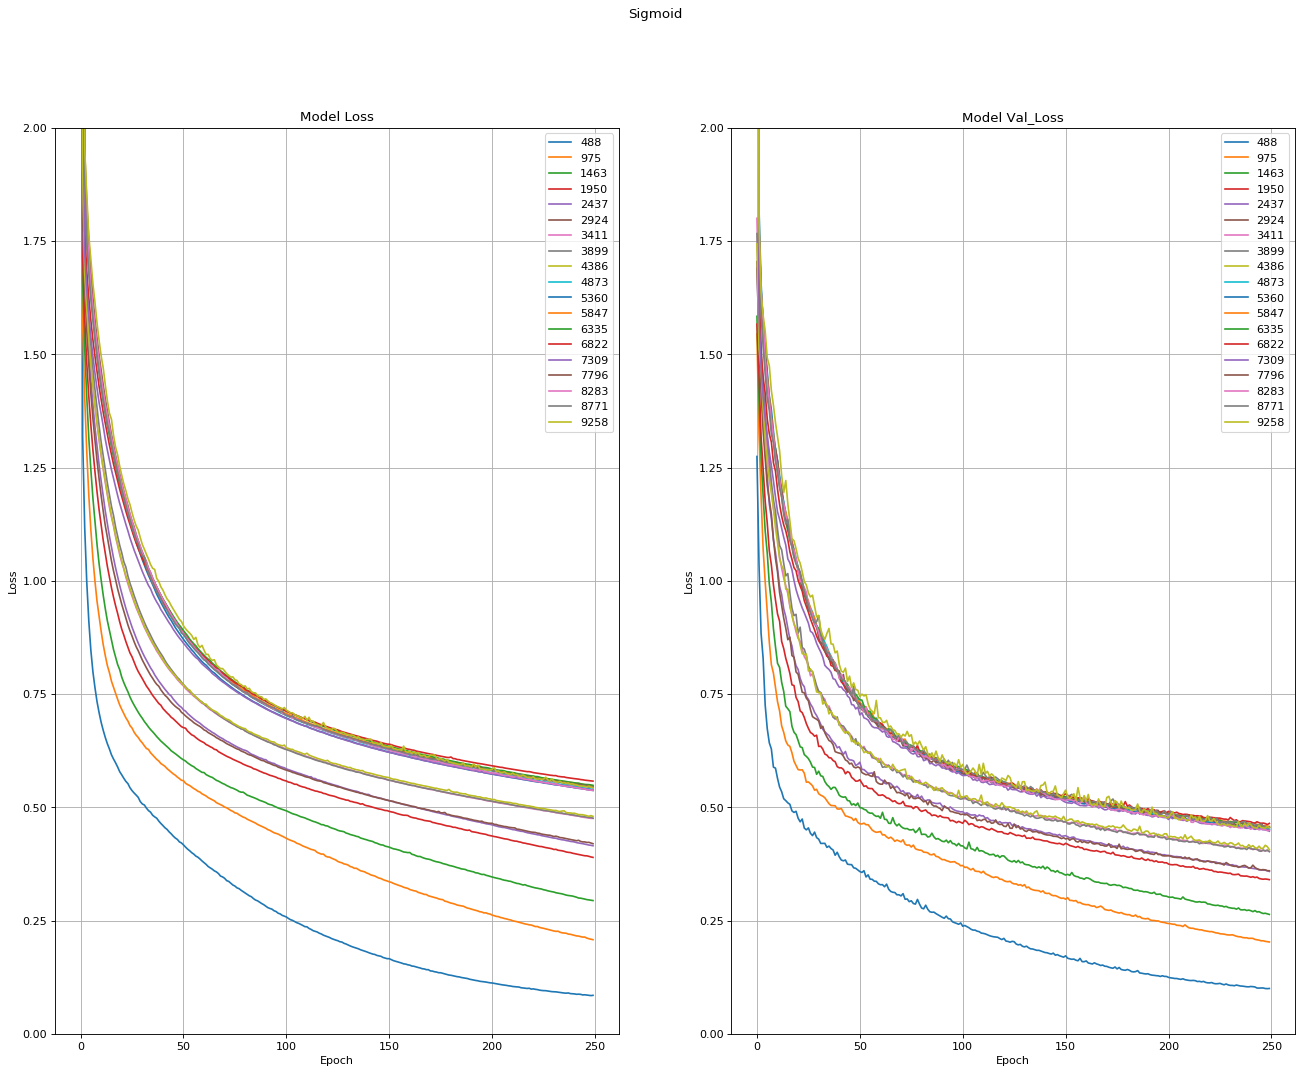

In [73]:
plt.figure(figsize=(20, 15), dpi=80, facecolor='w', edgecolor='b')
plt.subplot(1, 2, 1)
plt.suptitle("Sigmoid")

for i in range(1,20):
    plt.plot(historySigMini[i].history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,2)
plt.grid(True)
plt.legend([str(int(batch_sizes[1])), str(int(batch_sizes[2])), str(int(batch_sizes[3])), str(int(batch_sizes[4])), 
            str(int(batch_sizes[5])), str(int(batch_sizes[6])), str(int(batch_sizes[7])), str(int(batch_sizes[8])),
            str(int(batch_sizes[9])), str(int(batch_sizes[10])),str(int(batch_sizes[11])), str(int(batch_sizes[12])),
            str(int(batch_sizes[13])), str(int(batch_sizes[14])), str(int(batch_sizes[15])), str(int(batch_sizes[16])),
            str(int(batch_sizes[17])), str(int(batch_sizes[18])), str(int(batch_sizes[19]))])

plt.subplot(1, 2, 2)
for i in range(1,20):
    plt.plot(historySigMini[i].history['val_loss'])
plt.title('Model Val_Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,2)
plt.grid(True)
plt.legend([str(int(batch_sizes[1])), str(int(batch_sizes[2])), str(int(batch_sizes[3])), str(int(batch_sizes[4])), 
            str(int(batch_sizes[5])), str(int(batch_sizes[6])), str(int(batch_sizes[7])), str(int(batch_sizes[8])),
            str(int(batch_sizes[9])), str(int(batch_sizes[10])),str(int(batch_sizes[11])), str(int(batch_sizes[12])),
            str(int(batch_sizes[13])), str(int(batch_sizes[14])), str(int(batch_sizes[15])), str(int(batch_sizes[16])),
            str(int(batch_sizes[17])), str(int(batch_sizes[18])), str(int(batch_sizes[19]))])

Podemos apreciar que mientras mas cantidad de batch ocupemos obtenemos un peor desempeño: la función de pérdida no disminuye tanto y el error en el conjunto de validación es mucho mas difuso. Esto es debido a que mientras mas batch utilizemos, mas segmentaremos la función de error por cada batch, lo que se perderá generalidad. La idea es elegir valores no tan altos. Se probará ahora con función de activación ReLu.

In [56]:
historyReluMini = list()
for i in range(0,21):
    print("Para tamano de mini batch: " + str(int(batch_sizes[i])) + "\n")
    sgd = SGD(lr=0.01, decay=1e-6)
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
    model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    model.compile(optimizer=sgd,loss='mean_squared_error')
    historyReluMini.append(model.fit(X_train_scaled,y_train,batch_size=int(batch_sizes[i]),epochs=250,validation_data=(X_val_scaled, y_val), callbacks=[TerminateOnNaN()]))

Para tamano de mini batch: 1

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
  13/9745 [..............................] - ETA: 27:32 - loss: 1018219126341875668459978752.0000Batch 13: Invalid loss, terminating training
Para tamano de mini batch: 488

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
1952/9745 [=====>........................] - ETA: 8s - loss: inf      Batch 3: Invalid loss, terminating training
Para tamano de mini batch: 975

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
4875/9745 [==============>...............] - ETA: 2s - loss: inf         Batch 4: Invalid loss, terminating training
Para tamano de mini batch: 1463

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
7315/9745 [=====================>........] - ETA: 0s - loss: inf                               Batch 4: Invalid loss, terminating training
Para tamano de mini batch: 1950

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [=================

9745/9745 [==============================] - 0s 49us/step - loss: 141706625024.0000 - val_loss: 20455254563785252415571692093440.0000
Epoch 4/250
9745/9745 [==============================] - 0s 49us/step - loss: 25412735357905189940422898614272.0000 - val_loss: inf
Epoch 5/250
Batch 0: Invalid loss, terminating training
9745/9745 [==============================] - 0s 38us/step - loss: inf


En el cual lamentablemente no se logró una convergencia para ningun valor del batch.

### 1.g Estrategias modernas

Ahora haremos una comparación de los modelos Adam, RMSprop, Adagrad y Adadelta

In [74]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta

Comenzaremos primero analizando estas estrategias de adaptación de learning rate con la función de activación sigmoid. Se calculara con las diferentes estrategias y luego se graficaran juntas para comparar su desempeño.

In [76]:
# Para metodo Adam

model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
model.compile(optimizer=Adam(lr=0.01),loss='mean_squared_error')
historySigAdam = model.fit(X_train_scaled,y_train,epochs=250,validation_data=(X_val_scaled, y_val), callbacks=[TerminateOnNaN()])

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 6s 608us/step - loss: 2.6975 - val_loss: 0.2577
Epoch 2/250
9745/9745 [==============================] - 3s 277us/step - loss: 0.2275 - val_loss: 0.2087
Epoch 3/250
9745/9745 [==============================] - 3s 277us/step - loss: 0.2086 - val_loss: 0.2326
Epoch 4/250
9745/9745 [==============================] - 3s 275us/step - loss: 0.2059 - val_loss: 0.2165
Epoch 5/250
9745/9745 [==============================] - 3s 274us/step - loss: 0.2273 - val_loss: 0.2692
Epoch 6/250
9745/9745 [==============================] - 3s 277us/step - loss: 0.2247 - val_loss: 0.2332
Epoch 7/250
9745/9745 [==============================] - 3s 275us/step - loss: 0.2455 - val_loss: 0.2643
Epoch 8/250
9745/9745 [==============================] - 3s 277us/step - loss: 0.2402 - val_loss: 0.2783
Epoch 9/250
9745/9745 [==============================] - 3s 279us/step - loss: 0.2603 - val_loss: 0.3201
Epoch 1

Epoch 78/250
9745/9745 [==============================] - 3s 277us/step - loss: 0.1879 - val_loss: 0.1857
Epoch 79/250
9745/9745 [==============================] - 3s 275us/step - loss: 0.1970 - val_loss: 0.2453
Epoch 80/250
9745/9745 [==============================] - 3s 272us/step - loss: 0.1816 - val_loss: 0.1507
Epoch 81/250
9745/9745 [==============================] - 3s 278us/step - loss: 0.1934 - val_loss: 0.1784
Epoch 82/250
9745/9745 [==============================] - 3s 277us/step - loss: 0.1896 - val_loss: 0.2661
Epoch 83/250
9745/9745 [==============================] - 3s 274us/step - loss: 0.2148 - val_loss: 0.1868
Epoch 84/250
9745/9745 [==============================] - 3s 276us/step - loss: 0.1940 - val_loss: 0.3155
Epoch 85/250
9745/9745 [==============================] - 3s 276us/step - loss: 0.2131 - val_loss: 0.2022
Epoch 86/250
9745/9745 [==============================] - 3s 278us/step - loss: 0.2048 - val_loss: 0.2006
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 3s 276us/step - loss: 0.1482 - val_loss: 0.1542
Epoch 156/250
9745/9745 [==============================] - 3s 275us/step - loss: 0.1508 - val_loss: 0.1625
Epoch 157/250
9745/9745 [==============================] - 3s 274us/step - loss: 0.1647 - val_loss: 0.1386
Epoch 158/250
9745/9745 [==============================] - 3s 275us/step - loss: 0.1543 - val_loss: 0.1393
Epoch 159/250
9745/9745 [==============================] - 3s 276us/step - loss: 0.1394 - val_loss: 0.1533
Epoch 160/250
9745/9745 [==============================] - 3s 279us/step - loss: 0.1523 - val_loss: 0.1795
Epoch 161/250
9745/9745 [==============================] - 3s 278us/step - loss: 0.1437 - val_loss: 0.1761
Epoch 162/250
9745/9745 [==============================] - 3s 278us/step - loss: 0.1280 - val_loss: 0.1513
Epoch 163/250
9745/9745 [==============================] - 3s 278us/step - loss: 0.1655 - val_loss: 0.2070
Epoch 164/250
9745/9745 [============

In [78]:
# Para metodo Adagram

model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
model.compile(optimizer=Adagrad(lr=0.01),loss='mean_squared_error')
historySigAdagrad = model.fit(X_train_scaled,y_train,epochs=250,validation_data=(X_val_scaled, y_val), callbacks=[TerminateOnNaN()])

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 6s 574us/step - loss: 6.2377 - val_loss: 1.9693
Epoch 2/250
9745/9745 [==============================] - 2s 257us/step - loss: 0.9092 - val_loss: 0.7379
Epoch 3/250
9745/9745 [==============================] - 2s 256us/step - loss: 0.4189 - val_loss: 0.4132
Epoch 4/250
9745/9745 [==============================] - 2s 251us/step - loss: 0.2676 - val_loss: 0.2880
Epoch 5/250
9745/9745 [==============================] - 2s 254us/step - loss: 0.2028 - val_loss: 0.2232
Epoch 6/250
9745/9745 [==============================] - 2s 254us/step - loss: 0.1666 - val_loss: 0.1863
Epoch 7/250
9745/9745 [==============================] - 2s 256us/step - loss: 0.1433 - val_loss: 0.1635
Epoch 8/250
9745/9745 [==============================] - 3s 259us/step - loss: 0.1292 - val_loss: 0.1752
Epoch 9/250
9745/9745 [==============================] - 2s 255us/step - loss: 0.1179 - val_loss: 0.1382
Epoch 1

Epoch 78/250
9745/9745 [==============================] - 2s 256us/step - loss: 0.0323 - val_loss: 0.0659
Epoch 79/250
9745/9745 [==============================] - 2s 255us/step - loss: 0.0323 - val_loss: 0.0646
Epoch 80/250
9745/9745 [==============================] - 2s 255us/step - loss: 0.0321 - val_loss: 0.0644
Epoch 81/250
9745/9745 [==============================] - 2s 253us/step - loss: 0.0318 - val_loss: 0.0652
Epoch 82/250
9745/9745 [==============================] - 2s 253us/step - loss: 0.0317 - val_loss: 0.0639
Epoch 83/250
9745/9745 [==============================] - 2s 254us/step - loss: 0.0314 - val_loss: 0.0627
Epoch 84/250
9745/9745 [==============================] - 2s 255us/step - loss: 0.0312 - val_loss: 0.0646
Epoch 85/250
9745/9745 [==============================] - 2s 251us/step - loss: 0.0309 - val_loss: 0.0632
Epoch 86/250
9745/9745 [==============================] - 3s 260us/step - loss: 0.0309 - val_loss: 0.0632
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 2s 254us/step - loss: 0.0228 - val_loss: 0.0558
Epoch 156/250
9745/9745 [==============================] - 2s 255us/step - loss: 0.0227 - val_loss: 0.0566
Epoch 157/250
9745/9745 [==============================] - 2s 255us/step - loss: 0.0226 - val_loss: 0.0561
Epoch 158/250
9745/9745 [==============================] - 3s 258us/step - loss: 0.0225 - val_loss: 0.0559
Epoch 159/250
9745/9745 [==============================] - 2s 256us/step - loss: 0.0225 - val_loss: 0.0560
Epoch 160/250
9745/9745 [==============================] - 3s 257us/step - loss: 0.0224 - val_loss: 0.0566
Epoch 161/250
9745/9745 [==============================] - 2s 253us/step - loss: 0.0223 - val_loss: 0.0569
Epoch 162/250
9745/9745 [==============================] - 3s 258us/step - loss: 0.0222 - val_loss: 0.0564
Epoch 163/250
9745/9745 [==============================] - 2s 254us/step - loss: 0.0222 - val_loss: 0.0561
Epoch 164/250
9745/9745 [============

In [80]:
# Para metodo Adadelta

model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
model.compile(optimizer=Adadelta(lr=0.01),loss='mean_squared_error')
historySigAdadelta = model.fit(X_train_scaled,y_train,epochs=250,validation_data=(X_val_scaled, y_val), callbacks=[TerminateOnNaN()])

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 6s 615us/step - loss: 132.5118 - val_loss: 137.9479
Epoch 2/250
9745/9745 [==============================] - 3s 284us/step - loss: 112.3464 - val_loss: 116.4741
Epoch 3/250
9745/9745 [==============================] - 3s 286us/step - loss: 93.2054 - val_loss: 95.7443
Epoch 4/250
9745/9745 [==============================] - 3s 288us/step - loss: 74.9599 - val_loss: 76.4708
Epoch 5/250
9745/9745 [==============================] - 3s 284us/step - loss: 58.2323 - val_loss: 58.8549
Epoch 6/250
9745/9745 [==============================] - 3s 286us/step - loss: 43.6525 - val_loss: 43.7171
Epoch 7/250
9745/9745 [==============================] - 3s 286us/step - loss: 31.5257 - val_loss: 31.4211
Epoch 8/250
9745/9745 [==============================] - 3s 283us/step - loss: 21.9111 - val_loss: 21.7184
Epoch 9/250
9745/9745 [==============================] - 3s 286us/step - loss: 14.6660 - val

Epoch 154/250
9745/9745 [==============================] - 3s 285us/step - loss: 0.1109 - val_loss: 0.1172
Epoch 155/250
9745/9745 [==============================] - 3s 284us/step - loss: 0.1102 - val_loss: 0.1171
Epoch 156/250
9745/9745 [==============================] - 3s 286us/step - loss: 0.1096 - val_loss: 0.1165
Epoch 157/250
9745/9745 [==============================] - 3s 281us/step - loss: 0.1091 - val_loss: 0.1162
Epoch 158/250
9745/9745 [==============================] - 3s 282us/step - loss: 0.1083 - val_loss: 0.1167
Epoch 159/250
9745/9745 [==============================] - 3s 283us/step - loss: 0.1080 - val_loss: 0.1149
Epoch 160/250
9745/9745 [==============================] - 3s 285us/step - loss: 0.1075 - val_loss: 0.1153
Epoch 161/250
9745/9745 [==============================] - 3s 286us/step - loss: 0.1068 - val_loss: 0.1149
Epoch 162/250
9745/9745 [==============================] - 3s 284us/step - loss: 0.1063 - val_loss: 0.1146
Epoch 163/250
9745/9745 [============

In [81]:
# Para metodo RMSprop

model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
model.compile(optimizer=RMSprop(lr=0.01),loss='mean_squared_error')
historySigRMSprop = model.fit(X_train_scaled,y_train,epochs=250,validation_data=(X_val_scaled, y_val), callbacks=[TerminateOnNaN()])

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 6s 598us/step - loss: 2.1977 - val_loss: 0.7075
Epoch 2/250
9745/9745 [==============================] - 3s 267us/step - loss: 0.7263 - val_loss: 0.4652
Epoch 3/250
9745/9745 [==============================] - 3s 266us/step - loss: 0.6390 - val_loss: 0.7780
Epoch 4/250
9745/9745 [==============================] - 3s 268us/step - loss: 0.5761 - val_loss: 0.3171
Epoch 5/250
9745/9745 [==============================] - 3s 269us/step - loss: 0.5256 - val_loss: 0.3408
Epoch 6/250
9745/9745 [==============================] - 3s 267us/step - loss: 0.5264 - val_loss: 0.4645
Epoch 7/250
9745/9745 [==============================] - 3s 267us/step - loss: 0.4893 - val_loss: 1.0931
Epoch 8/250
9745/9745 [==============================] - 3s 267us/step - loss: 0.4691 - val_loss: 0.6736
Epoch 9/250
9745/9745 [==============================] - 3s 267us/step - loss: 0.4533 - val_loss: 0.4529
Epoch 1

Epoch 78/250
9745/9745 [==============================] - 3s 266us/step - loss: 0.2942 - val_loss: 0.5323
Epoch 79/250
9745/9745 [==============================] - 3s 265us/step - loss: 0.2963 - val_loss: 0.1791
Epoch 80/250
9745/9745 [==============================] - 3s 269us/step - loss: 0.2926 - val_loss: 0.1880
Epoch 81/250
9745/9745 [==============================] - 3s 268us/step - loss: 0.2984 - val_loss: 0.9050
Epoch 82/250
9745/9745 [==============================] - 3s 266us/step - loss: 0.3030 - val_loss: 0.1749
Epoch 83/250
9745/9745 [==============================] - 3s 265us/step - loss: 0.2992 - val_loss: 0.2646
Epoch 84/250
9745/9745 [==============================] - 3s 260us/step - loss: 0.2930 - val_loss: 0.1688
Epoch 85/250
9745/9745 [==============================] - 3s 268us/step - loss: 0.2833 - val_loss: 0.2306
Epoch 86/250
9745/9745 [==============================] - 3s 266us/step - loss: 0.2918 - val_loss: 0.3222
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 3s 267us/step - loss: 0.2711 - val_loss: 0.1610
Epoch 156/250
9745/9745 [==============================] - 3s 263us/step - loss: 0.2631 - val_loss: 0.1412
Epoch 157/250
9745/9745 [==============================] - 3s 268us/step - loss: 0.2672 - val_loss: 0.4696
Epoch 158/250
9745/9745 [==============================] - 3s 268us/step - loss: 0.2689 - val_loss: 0.3143
Epoch 159/250
9745/9745 [==============================] - 3s 268us/step - loss: 0.2581 - val_loss: 0.2863
Epoch 160/250
9745/9745 [==============================] - 3s 268us/step - loss: 0.2615 - val_loss: 0.5957
Epoch 161/250
9745/9745 [==============================] - 3s 268us/step - loss: 0.2643 - val_loss: 0.1803
Epoch 162/250
9745/9745 [==============================] - 3s 267us/step - loss: 0.2660 - val_loss: 0.8803
Epoch 163/250
9745/9745 [==============================] - 3s 266us/step - loss: 0.2615 - val_loss: 0.1532
Epoch 164/250
9745/9745 [============

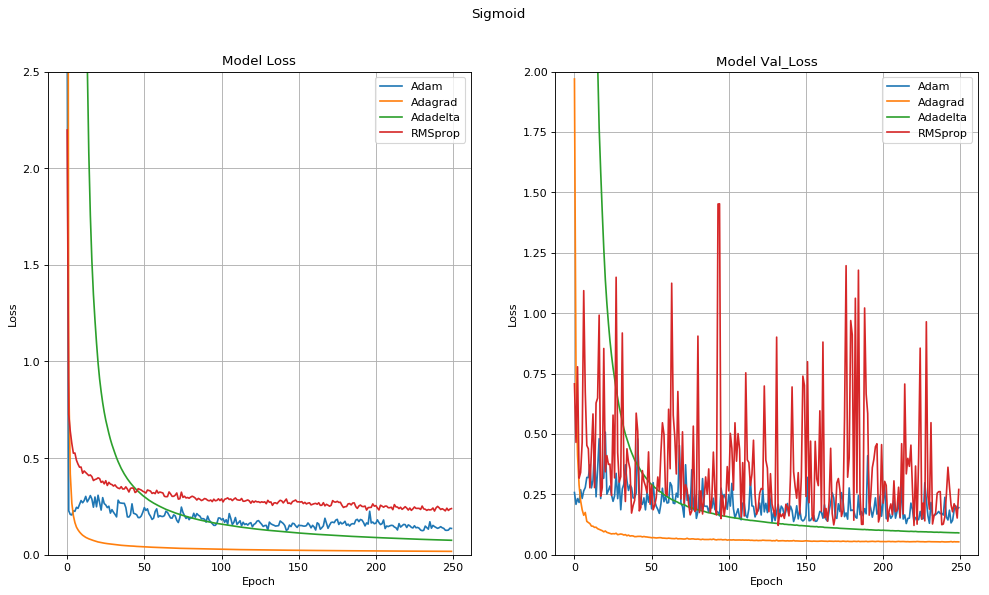

In [126]:
plt.figure(figsize=(15, 8), dpi=80, facecolor='w', edgecolor='b')
plt.subplot(1, 2, 1)
plt.suptitle("Sigmoid")

plt.plot(historySigAdam[0].history['loss'])
plt.plot(historySigAdagrad[0].history['loss'])
plt.plot(historySigAdadelta[0].history['loss'])
plt.plot(historySigRMSprop[0].history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,2.5)
plt.grid(True)
plt.legend(['Adam', 'Adagrad', 'Adadelta', 'RMSprop'])

plt.subplot(1, 2, 2)
plt.plot(historySigAdam[0].history['val_loss'])
plt.plot(historySigAdagrad[0].history['val_loss'])
plt.plot(historySigAdadelta[0].history['val_loss'])
plt.plot(historySigRMSprop[0].history['val_loss'])
plt.title('Model Val_Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,2)
plt.grid(True)
plt.legend(['Adam', 'Adagrad', 'Adadelta', 'RMSprop'])


Vemos que Adragad y Adadelta poseen una mejor estimación del error. Por su parte Adagrad se adapta a los parametros, fijando ciertos learning rate dependiendo de la escasez de los parámetros, por lo que se ve mejor al entrenar la red. Por otra parte Adadelta es una versión de Adragad pero menos agresiva respecto al gradiente, razón por la cual es igual de estable que Adragrad pero refleja mayor loss function que este último. Por otra parte, RMSprop divide estos learning rate dependiendo de pesos, por lo que al parecer no produce una buena aproximación, sobre todo en el conjunto de validación. Adam es una mejora de RMSprop, donde corrige el sesgo en el primer y segundo momento del gradiente, razón por la cual se ve un mejor desempeño respecto a RMSprop.

Mientras que para la función de activación ReLu, obtenemos lo siguiente:

In [87]:
# Para metodo Adam

model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
model.compile(optimizer=Adam(lr=0.01),loss='mean_squared_error')
historyReLuAdam = model.fit(X_train_scaled,y_train,epochs=250,validation_data=(X_val_scaled, y_val), callbacks=[TerminateOnNaN()])

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 6s 620us/step - loss: 25.9117 - val_loss: 7.2248
Epoch 2/250
9745/9745 [==============================] - 3s 285us/step - loss: 3.0915 - val_loss: 1.9954
Epoch 3/250
9745/9745 [==============================] - 3s 282us/step - loss: 4.6619 - val_loss: 4.9749
Epoch 4/250
9745/9745 [==============================] - 3s 283us/step - loss: 4.7964 - val_loss: 1.7487
Epoch 5/250
9745/9745 [==============================] - 3s 282us/step - loss: 4.2545 - val_loss: 1.1330
Epoch 6/250
9745/9745 [==============================] - 3s 282us/step - loss: 4.6187 - val_loss: 4.3752
Epoch 7/250
9745/9745 [==============================] - 3s 281us/step - loss: 4.7715 - val_loss: 0.9146
Epoch 8/250
9745/9745 [==============================] - 3s 285us/step - loss: 0.7855 - val_loss: 1.2562
Epoch 9/250
9745/9745 [==============================] - 3s 283us/step - loss: 0.9137 - val_loss: 1.2835
Epoch 

9745/9745 [==============================] - 3s 282us/step - loss: 54.5328 - val_loss: 4.2314
Epoch 154/250
9745/9745 [==============================] - 3s 283us/step - loss: 92.3850 - val_loss: 51.1022
Epoch 155/250
9745/9745 [==============================] - 3s 282us/step - loss: 19.5857 - val_loss: 2.4709
Epoch 156/250
9745/9745 [==============================] - 3s 280us/step - loss: 9.5604 - val_loss: 1.8758
Epoch 157/250
9745/9745 [==============================] - 3s 284us/step - loss: 7.3403 - val_loss: 1.7781
Epoch 158/250
9745/9745 [==============================] - 3s 281us/step - loss: 4.0310 - val_loss: 1.1841
Epoch 159/250
9745/9745 [==============================] - 3s 284us/step - loss: 11.0582 - val_loss: 25.7427
Epoch 160/250
9745/9745 [==============================] - 3s 282us/step - loss: 8.2323 - val_loss: 1.7214
Epoch 161/250
9745/9745 [==============================] - 3s 282us/step - loss: 10.8997 - val_loss: 9.5628
Epoch 162/250
9745/9745 [===================

9745/9745 [==============================] - 3s 279us/step - loss: 3.8252 - val_loss: 1.0650
Epoch 230/250
9745/9745 [==============================] - 3s 282us/step - loss: 2.2446 - val_loss: 0.6529
Epoch 231/250
9745/9745 [==============================] - 3s 281us/step - loss: 2.6265 - val_loss: 1.1044
Epoch 232/250
9745/9745 [==============================] - 3s 286us/step - loss: 2.5605 - val_loss: 14.1226
Epoch 233/250
9745/9745 [==============================] - 3s 285us/step - loss: 4.4633 - val_loss: 0.9155
Epoch 234/250
9745/9745 [==============================] - 3s 280us/step - loss: 4.2762 - val_loss: 0.6129
Epoch 235/250
9745/9745 [==============================] - 3s 283us/step - loss: 5.3972 - val_loss: 45.6169
Epoch 236/250
9745/9745 [==============================] - 3s 282us/step - loss: 44.5666 - val_loss: 7.7017
Epoch 237/250
9745/9745 [==============================] - 3s 282us/step - loss: 6.3138 - val_loss: 5.3181
Epoch 238/250
9745/9745 [=======================

In [88]:
# Para metodo Adagram

model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
model.compile(optimizer=Adagrad(lr=0.01),loss='mean_squared_error')
historyReLuAdagram = model.fit(X_train_scaled,y_train,epochs=250,validation_data=(X_val_scaled, y_val), callbacks=[TerminateOnNaN()])

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 6s 596us/step - loss: 7.1453 - val_loss: 3.3000
Epoch 2/250
9745/9745 [==============================] - 3s 260us/step - loss: 1.2136 - val_loss: 2.1474
Epoch 3/250
9745/9745 [==============================] - 3s 264us/step - loss: 0.7708 - val_loss: 1.9671
Epoch 4/250
9745/9745 [==============================] - 3s 262us/step - loss: 0.6018 - val_loss: 1.8171
Epoch 5/250
9745/9745 [==============================] - 3s 258us/step - loss: 0.4843 - val_loss: 1.4387
Epoch 6/250
9745/9745 [==============================] - 3s 262us/step - loss: 0.4182 - val_loss: 1.3241
Epoch 7/250
9745/9745 [==============================] - 3s 261us/step - loss: 0.3688 - val_loss: 1.1781
Epoch 8/250
9745/9745 [==============================] - 3s 261us/step - loss: 0.3233 - val_loss: 1.1536
Epoch 9/250
9745/9745 [==============================] - 3s 262us/step - loss: 0.2960 - val_loss: 1.1066
Epoch 1

Epoch 78/250
9745/9745 [==============================] - 2s 255us/step - loss: 0.0663 - val_loss: 0.6254
Epoch 79/250
9745/9745 [==============================] - 3s 263us/step - loss: 0.0664 - val_loss: 0.5560
Epoch 80/250
9745/9745 [==============================] - 3s 261us/step - loss: 0.0651 - val_loss: 0.5415
Epoch 81/250
9745/9745 [==============================] - 3s 261us/step - loss: 0.0648 - val_loss: 0.5627
Epoch 82/250
9745/9745 [==============================] - 3s 262us/step - loss: 0.0641 - val_loss: 0.5867
Epoch 83/250
9745/9745 [==============================] - 3s 259us/step - loss: 0.0637 - val_loss: 0.5802
Epoch 84/250
9745/9745 [==============================] - 3s 258us/step - loss: 0.0627 - val_loss: 0.5556
Epoch 85/250
9745/9745 [==============================] - 3s 257us/step - loss: 0.0627 - val_loss: 0.5663
Epoch 86/250
9745/9745 [==============================] - 3s 261us/step - loss: 0.0616 - val_loss: 0.5568
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 3s 260us/step - loss: 0.0418 - val_loss: 0.5788
Epoch 156/250
9745/9745 [==============================] - 3s 258us/step - loss: 0.0414 - val_loss: 0.5642
Epoch 157/250
9745/9745 [==============================] - 3s 259us/step - loss: 0.0412 - val_loss: 0.5681
Epoch 158/250
9745/9745 [==============================] - 3s 259us/step - loss: 0.0408 - val_loss: 0.6238
Epoch 159/250
9745/9745 [==============================] - 3s 262us/step - loss: 0.0415 - val_loss: 0.5758
Epoch 160/250
9745/9745 [==============================] - 3s 259us/step - loss: 0.0412 - val_loss: 0.5639
Epoch 161/250
9745/9745 [==============================] - 3s 259us/step - loss: 0.0416 - val_loss: 0.5852
Epoch 162/250
9745/9745 [==============================] - 3s 262us/step - loss: 0.0409 - val_loss: 0.5810
Epoch 163/250
9745/9745 [==============================] - 3s 262us/step - loss: 0.0404 - val_loss: 0.5752
Epoch 164/250
9745/9745 [============

In [89]:
# Para metodo Adadelta

model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
model.compile(optimizer=Adadelta(lr=0.01),loss='mean_squared_error')
historyReLuAdadelta = model.fit(X_train_scaled,y_train,epochs=250,validation_data=(X_val_scaled, y_val), callbacks=[TerminateOnNaN()])

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 6s 628us/step - loss: 90.4948 - val_loss: 62.8192
Epoch 2/250
9745/9745 [==============================] - 3s 290us/step - loss: 33.7365 - val_loss: 25.7124
Epoch 3/250
9745/9745 [==============================] - 3s 289us/step - loss: 14.2929 - val_loss: 15.2579
Epoch 4/250
9745/9745 [==============================] - 3s 290us/step - loss: 10.0507 - val_loss: 12.6234
Epoch 5/250
9745/9745 [==============================] - 3s 289us/step - loss: 8.4518 - val_loss: 11.0802
Epoch 6/250
9745/9745 [==============================] - 3s 290us/step - loss: 7.3198 - val_loss: 9.8727
Epoch 7/250
9745/9745 [==============================] - 3s 286us/step - loss: 6.3457 - val_loss: 8.7743
Epoch 8/250
9745/9745 [==============================] - 3s 288us/step - loss: 5.5413 - val_loss: 7.8618
Epoch 9/250
9745/9745 [==============================] - 3s 291us/step - loss: 4.8231 - val_loss: 7.129

Epoch 78/250
9745/9745 [==============================] - 3s 287us/step - loss: 0.4942 - val_loss: 1.5358
Epoch 79/250
9745/9745 [==============================] - 3s 293us/step - loss: 0.4867 - val_loss: 1.4777
Epoch 80/250
9745/9745 [==============================] - 3s 291us/step - loss: 0.4723 - val_loss: 1.4461
Epoch 81/250
9745/9745 [==============================] - 3s 288us/step - loss: 0.4639 - val_loss: 1.4314
Epoch 82/250
9745/9745 [==============================] - 3s 287us/step - loss: 0.4603 - val_loss: 1.4132
Epoch 83/250
9745/9745 [==============================] - 3s 291us/step - loss: 0.4497 - val_loss: 1.4298
Epoch 84/250
9745/9745 [==============================] - 3s 289us/step - loss: 0.4455 - val_loss: 1.3854
Epoch 85/250
9745/9745 [==============================] - 3s 289us/step - loss: 0.4404 - val_loss: 1.3520
Epoch 86/250
9745/9745 [==============================] - 3s 289us/step - loss: 0.4258 - val_loss: 1.3381
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 3s 286us/step - loss: 0.1426 - val_loss: 0.7438
Epoch 156/250
9745/9745 [==============================] - 3s 289us/step - loss: 0.1429 - val_loss: 0.7322
Epoch 157/250
9745/9745 [==============================] - 3s 290us/step - loss: 0.1400 - val_loss: 0.7309
Epoch 158/250
9745/9745 [==============================] - 3s 288us/step - loss: 0.1396 - val_loss: 0.7293
Epoch 159/250
9745/9745 [==============================] - 3s 291us/step - loss: 0.1390 - val_loss: 0.7167
Epoch 160/250
9745/9745 [==============================] - 3s 290us/step - loss: 0.1378 - val_loss: 0.7336
Epoch 161/250
9745/9745 [==============================] - 3s 291us/step - loss: 0.1378 - val_loss: 0.7226
Epoch 162/250
9745/9745 [==============================] - 3s 286us/step - loss: 0.1360 - val_loss: 0.7175
Epoch 163/250
9745/9745 [==============================] - 3s 290us/step - loss: 0.1327 - val_loss: 0.7091
Epoch 164/250
9745/9745 [============

In [90]:
# Para metodo RMSprop

model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
model.compile(optimizer=RMSprop(lr=0.01),loss='mean_squared_error')
historyReLuRMSprop = model.fit(X_train_scaled,y_train,epochs=250,validation_data=(X_val_scaled, y_val), callbacks=[TerminateOnNaN()])

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 6s 610us/step - loss: 152.4532 - val_loss: 33.2791
Epoch 2/250
9745/9745 [==============================] - 3s 272us/step - loss: 150.3234 - val_loss: 45.5309
Epoch 3/250
9745/9745 [==============================] - 3s 271us/step - loss: 88.6915 - val_loss: 343.5745
Epoch 4/250
9745/9745 [==============================] - 3s 271us/step - loss: 101.9492 - val_loss: 178.5324
Epoch 5/250
9745/9745 [==============================] - 3s 273us/step - loss: 86.7699 - val_loss: 10.6833
Epoch 6/250
9745/9745 [==============================] - 3s 270us/step - loss: 199.3779 - val_loss: 16.5917
Epoch 7/250
9745/9745 [==============================] - 3s 270us/step - loss: 98.4075 - val_loss: 21.5786
Epoch 8/250
9745/9745 [==============================] - 3s 267us/step - loss: 97.3316 - val_loss: 297.6616
Epoch 9/250
9745/9745 [==============================] - 3s 268us/step - loss: 210.1649 -

9745/9745 [==============================] - 3s 270us/step - loss: 268.8064 - val_loss: 190.2204
Epoch 150/250
9745/9745 [==============================] - 3s 266us/step - loss: 152.1616 - val_loss: 409.0461
Epoch 151/250
9745/9745 [==============================] - 3s 274us/step - loss: 122.2901 - val_loss: 349.7033
Epoch 152/250
9745/9745 [==============================] - 3s 267us/step - loss: 79.6365 - val_loss: 866.2135
Epoch 153/250
9745/9745 [==============================] - 3s 269us/step - loss: 97.2186 - val_loss: 162.7064
Epoch 154/250
9745/9745 [==============================] - 3s 267us/step - loss: 130.2876 - val_loss: 38.1123
Epoch 155/250
9745/9745 [==============================] - 3s 266us/step - loss: 108.3795 - val_loss: 177.8872
Epoch 156/250
9745/9745 [==============================] - 3s 267us/step - loss: 186.7022 - val_loss: 257.4633
Epoch 157/250
9745/9745 [==============================] - 3s 272us/step - loss: 99.8550 - val_loss: 275.7200
Epoch 158/250
9745/

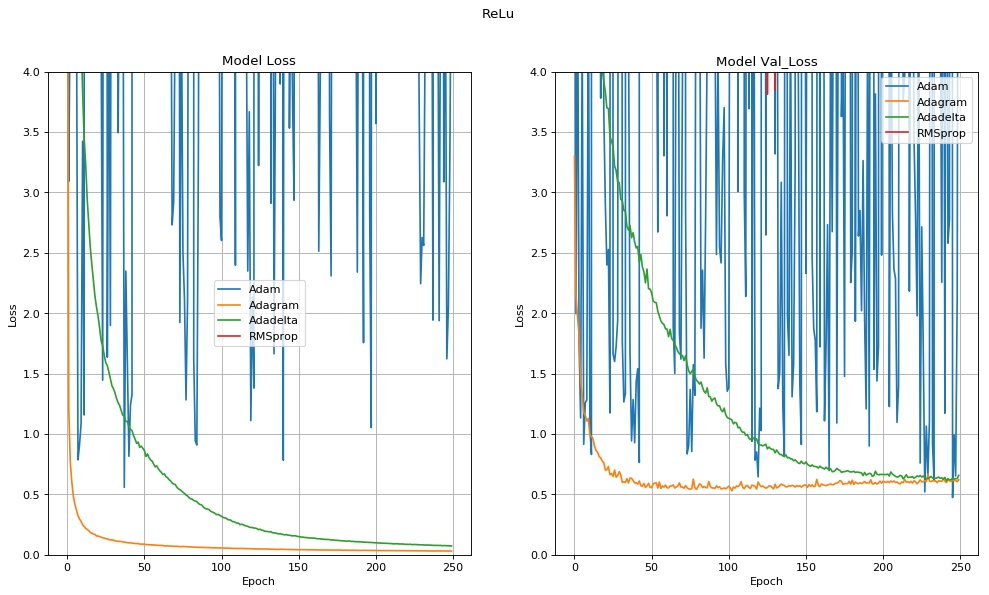

In [93]:
plt.figure(figsize=(15, 8), dpi=80, facecolor='w', edgecolor='b')
plt.subplot(1, 2, 1)
plt.suptitle("ReLu")

plt.plot(historyReLuAdam.history['loss'])
plt.plot(historyReLuAdagram.history['loss'])
plt.plot(historyReLuAdadelta.history['loss'])
plt.plot(historyReLuRMSprop.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,4)
plt.grid(True)
plt.legend(['Adam', 'Adagram', 'Adadelta', 'RMSprop'])

plt.subplot(1, 2, 2)
plt.plot(historyReLuAdam.history['val_loss'])
plt.plot(historyReLuAdagram.history['val_loss'])
plt.plot(historyReLuAdadelta.history['val_loss'])
plt.plot(historyReLuRMSprop.history['val_loss'])
plt.title('Model Val_Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,4)
plt.grid(True)
plt.legend(['Adam', 'Adagram', 'Adadelta', 'RMSprop'])

Las mejoras se ven mucho mas claras, donde definitivamente las estrategias Adam y RMSprop no son viables, mientras que Adagram y Adadelta siguen siendo la que mejor se adapta a la muestra tanto de entrenamiento como de validacion.

### 1.h Weight Decay

Regularizamos con weight decay. Probaremos con 10 valores de weight decay, donde haremos tres pruebas: una regulando las capas ocultas y la de salida, otra con solo las ocultas y por último, solo la de salida. Comenzaremos con la función de activación sigmoid.

In [117]:
from keras.regularizers import l2

In [119]:
# Regularizacion para ambas capas
wdecayValues = np.linspace(0.1,1,5)
wdecaySigBoth = list()
wdecaySigFirst = list()
wdecaySigLast = list()

print("\n Se aplica weight decay para la primera y ultima capa \n\n")

for i in range(0,5):
    print("Valor weight decay: " + str(wdecayValues[i]) + "\n")
    model = Sequential()
    model.add(Dense(256,input_dim=X_train_scaled.shape[1],kernel_initializer='uniform',W_regularizer=l2(0.01)))
    model.add(Activation('sigmoid'))
    model.add(Dense(1, kernel_initializer='uniform',W_regularizer=l2(0.01)))
    model.add(Activation('linear'))
    model.compile(optimizer=SGD(lr=0.01),loss='mean_squared_error')
    wdecaySigBoth.append(model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val), callbacks=[TerminateOnNaN()]))

print("\n\n Se aplica weight decay para la primera capa \n\n")
    
for i in range(0,5):
    print("Valor weight decay: " + str(wdecayValues[i]) + "\n")
    model = Sequential()
    model.add(Dense(256,input_dim=X_train_scaled.shape[1],kernel_initializer='uniform',W_regularizer=l2(0.01)))
    model.add(Activation('sigmoid'))
    model.add(Dense(1, kernel_initializer='uniform'))
    model.add(Activation('linear'))
    model.compile(optimizer=SGD(lr=0.01),loss='mean_squared_error')
    wdecaySigFirst.append(model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val), callbacks=[TerminateOnNaN()]))

print("\n\n Se aplica weight decay para la ultima capa \n")

for i in range(0,5):
    print("Valor weight decay: " + str(wdecayValues[i]) + "\n")
    model = Sequential()
    model.add(Dense(256,input_dim=X_train_scaled.shape[1],kernel_initializer='uniform'))
    model.add(Activation('sigmoid'))
    model.add(Dense(1, kernel_initializer='uniform',W_regularizer=l2(0.01)))
    model.add(Activation('linear'))
    model.compile(optimizer=SGD(lr=0.01),loss='mean_squared_error')
    wdecaySigLast.append(model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val), callbacks=[TerminateOnNaN()]))


 Se aplica weight decay para la primera y ultima capa 


Valor weight decay: 0.1



/home/ivalenzu/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, input_dim=1275, kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
  if sys.path[0] == '':
/home/ivalenzu/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
  


Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 8s 824us/step - loss: 4.1204 - val_loss: 2.9913
Epoch 2/250
9745/9745 [==============================] - 3s 317us/step - loss: 2.9378 - val_loss: 2.6298
Epoch 3/250
9745/9745 [==============================] - 3s 319us/step - loss: 2.5913 - val_loss: 2.3632
Epoch 4/250
9745/9745 [==============================] - 3s 318us/step - loss: 2.3035 - val_loss: 2.1787
Epoch 5/250
9745/9745 [==============================] - 3s 315us/step - loss: 2.0616 - val_loss: 1.9986
Epoch 6/250
9745/9745 [==============================] - 3s 314us/step - loss: 1.8474 - val_loss: 1.7046
Epoch 7/250
9745/9745 [==============================] - 3s 313us/step - loss: 1.6738 - val_loss: 1.5682
Epoch 8/250
9745/9745 [==============================] - 3s 317us/step - loss: 1.5141 - val_loss: 1.5297
Epoch 9/250
9745/9745 [==============================] - 3s 313us/step - loss: 1.3758 - val_loss: 1.2943
Epoch 1

Epoch 78/250
9745/9745 [==============================] - 3s 314us/step - loss: 0.3102 - val_loss: 0.3007
Epoch 79/250
9745/9745 [==============================] - 3s 315us/step - loss: 0.3089 - val_loss: 0.3225
Epoch 80/250
9745/9745 [==============================] - 3s 315us/step - loss: 0.3118 - val_loss: 0.3522
Epoch 81/250
9745/9745 [==============================] - 3s 314us/step - loss: 0.3115 - val_loss: 0.3042
Epoch 82/250
9745/9745 [==============================] - 3s 315us/step - loss: 0.3118 - val_loss: 0.3075
Epoch 83/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.3093 - val_loss: 0.4800
Epoch 84/250
9745/9745 [==============================] - 3s 314us/step - loss: 0.3088 - val_loss: 0.3245
Epoch 85/250
9745/9745 [==============================] - 3s 316us/step - loss: 0.3092 - val_loss: 0.3483
Epoch 86/250
9745/9745 [==============================] - 3s 315us/step - loss: 0.3072 - val_loss: 0.3061
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 3s 314us/step - loss: 0.2919 - val_loss: 0.3040
Epoch 156/250
9745/9745 [==============================] - 3s 310us/step - loss: 0.2924 - val_loss: 0.3342
Epoch 157/250
9745/9745 [==============================] - 3s 316us/step - loss: 0.2927 - val_loss: 0.3310
Epoch 158/250
9745/9745 [==============================] - 3s 316us/step - loss: 0.2874 - val_loss: 0.3036
Epoch 159/250
9745/9745 [==============================] - 3s 315us/step - loss: 0.2904 - val_loss: 0.2998
Epoch 160/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.2889 - val_loss: 0.2931
Epoch 161/250
9745/9745 [==============================] - 3s 316us/step - loss: 0.2906 - val_loss: 0.3205
Epoch 162/250
9745/9745 [==============================] - 3s 315us/step - loss: 0.2876 - val_loss: 0.2930
Epoch 163/250
9745/9745 [==============================] - 3s 315us/step - loss: 0.2875 - val_loss: 0.2963
Epoch 164/250
9745/9745 [============

9745/9745 [==============================] - 3s 313us/step - loss: 0.3136 - val_loss: 0.3418
Epoch 58/250
9745/9745 [==============================] - 3s 312us/step - loss: 0.3168 - val_loss: 0.3299
Epoch 59/250
9745/9745 [==============================] - 3s 315us/step - loss: 0.3163 - val_loss: 0.3481
Epoch 60/250
9745/9745 [==============================] - 3s 316us/step - loss: 0.3160 - val_loss: 0.5361
Epoch 61/250
9745/9745 [==============================] - 3s 314us/step - loss: 0.3139 - val_loss: 0.3186
Epoch 62/250
9745/9745 [==============================] - 3s 315us/step - loss: 0.3155 - val_loss: 0.3380
Epoch 63/250
9745/9745 [==============================] - 3s 312us/step - loss: 0.3142 - val_loss: 0.3141
Epoch 64/250
9745/9745 [==============================] - 3s 312us/step - loss: 0.3116 - val_loss: 0.3181
Epoch 65/250
9745/9745 [==============================] - 3s 317us/step - loss: 0.3148 - val_loss: 0.3091
Epoch 66/250
9745/9745 [==============================] - 3

9745/9745 [==============================] - 3s 313us/step - loss: 0.2904 - val_loss: 0.2951
Epoch 135/250
9745/9745 [==============================] - 3s 314us/step - loss: 0.2921 - val_loss: 0.3417
Epoch 136/250
9745/9745 [==============================] - 3s 315us/step - loss: 0.2943 - val_loss: 0.3155
Epoch 137/250
9745/9745 [==============================] - 3s 312us/step - loss: 0.2936 - val_loss: 0.3573
Epoch 138/250
9745/9745 [==============================] - 3s 311us/step - loss: 0.2871 - val_loss: 0.3087
Epoch 139/250
9745/9745 [==============================] - 3s 317us/step - loss: 0.2881 - val_loss: 0.2938
Epoch 140/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.2873 - val_loss: 0.2977
Epoch 141/250
9745/9745 [==============================] - 3s 313us/step - loss: 0.2885 - val_loss: 0.2855
Epoch 142/250
9745/9745 [==============================] - 3s 314us/step - loss: 0.2881 - val_loss: 0.2966
Epoch 143/250
9745/9745 [==========================

9745/9745 [==============================] - 3s 316us/step - loss: 0.3569 - val_loss: 0.4220
Epoch 37/250
9745/9745 [==============================] - 3s 316us/step - loss: 0.3506 - val_loss: 0.3519
Epoch 38/250
9745/9745 [==============================] - 3s 316us/step - loss: 0.3496 - val_loss: 0.3600
Epoch 39/250
9745/9745 [==============================] - 3s 317us/step - loss: 0.3417 - val_loss: 0.3817
Epoch 40/250
9745/9745 [==============================] - 3s 319us/step - loss: 0.3365 - val_loss: 0.3335
Epoch 41/250
9745/9745 [==============================] - 3s 317us/step - loss: 0.3383 - val_loss: 0.3316
Epoch 42/250
9745/9745 [==============================] - 3s 314us/step - loss: 0.3322 - val_loss: 0.3582
Epoch 43/250
9745/9745 [==============================] - 3s 315us/step - loss: 0.3338 - val_loss: 0.3292
Epoch 44/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.3262 - val_loss: 0.3237
Epoch 45/250
9745/9745 [==============================] - 3

9745/9745 [==============================] - 3s 316us/step - loss: 0.2799 - val_loss: 0.2843
Epoch 190/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.2825 - val_loss: 0.3100
Epoch 191/250
9745/9745 [==============================] - 3s 315us/step - loss: 0.2796 - val_loss: 0.3169
Epoch 192/250
9745/9745 [==============================] - 3s 313us/step - loss: 0.2830 - val_loss: 0.2939
Epoch 193/250
9745/9745 [==============================] - 3s 315us/step - loss: 0.2793 - val_loss: 0.3327
Epoch 194/250
9745/9745 [==============================] - 3s 316us/step - loss: 0.2802 - val_loss: 0.2828
Epoch 195/250
9745/9745 [==============================] - 3s 317us/step - loss: 0.2819 - val_loss: 0.3217
Epoch 196/250
9745/9745 [==============================] - 3s 316us/step - loss: 0.2809 - val_loss: 0.3158
Epoch 197/250
9745/9745 [==============================] - 3s 316us/step - loss: 0.2816 - val_loss: 0.2831
Epoch 198/250
9745/9745 [==========================

9745/9745 [==============================] - 3s 318us/step - loss: 0.3005 - val_loss: 0.3178
Epoch 93/250
9745/9745 [==============================] - 3s 314us/step - loss: 0.2968 - val_loss: 0.2963
Epoch 94/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.3012 - val_loss: 0.2975
Epoch 95/250
9745/9745 [==============================] - 3s 319us/step - loss: 0.2966 - val_loss: 0.3513
Epoch 96/250
9745/9745 [==============================] - 3s 317us/step - loss: 0.2975 - val_loss: 0.3623
Epoch 97/250
9745/9745 [==============================] - 3s 317us/step - loss: 0.2985 - val_loss: 0.2918
Epoch 98/250
9745/9745 [==============================] - 3s 319us/step - loss: 0.2925 - val_loss: 0.2922
Epoch 99/250
9745/9745 [==============================] - 3s 320us/step - loss: 0.2937 - val_loss: 0.3015
Epoch 100/250
9745/9745 [==============================] - 3s 319us/step - loss: 0.2988 - val_loss: 0.3258
Epoch 101/250
9745/9745 [==============================] -

Epoch 169/250
9745/9745 [==============================] - 3s 316us/step - loss: 0.2816 - val_loss: 0.3147
Epoch 170/250
9745/9745 [==============================] - 3s 320us/step - loss: 0.2784 - val_loss: 0.4290
Epoch 171/250
9745/9745 [==============================] - 3s 319us/step - loss: 0.2768 - val_loss: 0.3441
Epoch 172/250
9745/9745 [==============================] - 3s 321us/step - loss: 0.2796 - val_loss: 0.2802
Epoch 173/250
9745/9745 [==============================] - 3s 317us/step - loss: 0.2786 - val_loss: 0.3095
Epoch 174/250
9745/9745 [==============================] - 3s 316us/step - loss: 0.2799 - val_loss: 0.2957
Epoch 175/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.2783 - val_loss: 0.2859
Epoch 176/250
9745/9745 [==============================] - 3s 317us/step - loss: 0.2786 - val_loss: 0.2832
Epoch 177/250
9745/9745 [==============================] - 3s 316us/step - loss: 0.2834 - val_loss: 0.2761
Epoch 178/250
9745/9745 [============

Epoch 72/250
9745/9745 [==============================] - 3s 317us/step - loss: 0.3027 - val_loss: 0.3100
Epoch 73/250
9745/9745 [==============================] - 3s 316us/step - loss: 0.3065 - val_loss: 0.3182
Epoch 74/250
9745/9745 [==============================] - 3s 320us/step - loss: 0.3029 - val_loss: 0.2998
Epoch 75/250
9745/9745 [==============================] - 3s 315us/step - loss: 0.3013 - val_loss: 0.3047
Epoch 76/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.3040 - val_loss: 0.3392
Epoch 77/250
9745/9745 [==============================] - 3s 319us/step - loss: 0.3056 - val_loss: 0.3853
Epoch 78/250
9745/9745 [==============================] - 3s 322us/step - loss: 0.3057 - val_loss: 0.3048
Epoch 79/250
9745/9745 [==============================] - 3s 314us/step - loss: 0.3037 - val_loss: 0.3302
Epoch 80/250
9745/9745 [==============================] - 3s 316us/step - loss: 0.3052 - val_loss: 0.3116
Epoch 81/250
9745/9745 [======================

Epoch 149/250
9745/9745 [==============================] - 3s 316us/step - loss: 0.2872 - val_loss: 0.3109
Epoch 150/250
9745/9745 [==============================] - 3s 317us/step - loss: 0.2840 - val_loss: 0.2944
Epoch 151/250
9745/9745 [==============================] - 3s 317us/step - loss: 0.2822 - val_loss: 0.3652
Epoch 152/250
9745/9745 [==============================] - 3s 317us/step - loss: 0.2844 - val_loss: 0.2899
Epoch 153/250
9745/9745 [==============================] - 3s 314us/step - loss: 0.2861 - val_loss: 0.3082
Epoch 154/250
9745/9745 [==============================] - 3s 315us/step - loss: 0.2821 - val_loss: 0.3229
Epoch 155/250
9745/9745 [==============================] - 3s 317us/step - loss: 0.2890 - val_loss: 0.3761
Epoch 156/250
9745/9745 [==============================] - 3s 315us/step - loss: 0.2846 - val_loss: 0.4001
Epoch 157/250
9745/9745 [==============================] - 3s 315us/step - loss: 0.2862 - val_loss: 0.2980
Epoch 158/250
9745/9745 [============

/home/ivalenzu/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, input_dim=1275, kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`


9745/9745 [==============================] - 8s 838us/step - loss: 4.0043 - val_loss: 3.0903
Epoch 2/250
9745/9745 [==============================] - 3s 316us/step - loss: 2.9257 - val_loss: 2.8003
Epoch 3/250
9745/9745 [==============================] - 3s 315us/step - loss: 2.5898 - val_loss: 2.3552
Epoch 4/250
9745/9745 [==============================] - 3s 317us/step - loss: 2.2996 - val_loss: 2.1371
Epoch 5/250
9745/9745 [==============================] - 3s 316us/step - loss: 2.0492 - val_loss: 1.8749
Epoch 6/250
9745/9745 [==============================] - 3s 315us/step - loss: 1.8258 - val_loss: 1.6834
Epoch 7/250
9745/9745 [==============================] - 3s 317us/step - loss: 1.6346 - val_loss: 1.7074
Epoch 8/250
9745/9745 [==============================] - 3s 316us/step - loss: 1.4650 - val_loss: 1.3377
Epoch 9/250
9745/9745 [==============================] - 3s 319us/step - loss: 1.3144 - val_loss: 1.2715
Epoch 10/250
9745/9745 [==============================] - 3s 316us/

Epoch 155/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.1746 - val_loss: 0.6026
Epoch 156/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.1785 - val_loss: 0.1666
Epoch 157/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.1563 - val_loss: 0.1314
Epoch 158/250
9745/9745 [==============================] - 3s 317us/step - loss: 0.1773 - val_loss: 0.6289
Epoch 159/250
9745/9745 [==============================] - 3s 316us/step - loss: 0.1608 - val_loss: 0.1442
Epoch 160/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.1629 - val_loss: 0.1871
Epoch 161/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.1534 - val_loss: 0.1378
Epoch 162/250
9745/9745 [==============================] - 3s 317us/step - loss: 0.1866 - val_loss: 0.1398
Epoch 163/250
9745/9745 [==============================] - 3s 316us/step - loss: 0.1552 - val_loss: 0.1538
Epoch 164/250
9745/9745 [============

9745/9745 [==============================] - 3s 318us/step - loss: 0.2015 - val_loss: 0.2510
Epoch 58/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.1995 - val_loss: 0.1557
Epoch 59/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.1890 - val_loss: 0.1928
Epoch 60/250
9745/9745 [==============================] - 3s 314us/step - loss: 0.1867 - val_loss: 0.1742
Epoch 61/250
9745/9745 [==============================] - 3s 317us/step - loss: 0.1957 - val_loss: 0.3116
Epoch 62/250
9745/9745 [==============================] - 3s 316us/step - loss: 0.2159 - val_loss: 0.2456
Epoch 63/250
9745/9745 [==============================] - 3s 316us/step - loss: 0.1952 - val_loss: 0.1650
Epoch 64/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.1730 - val_loss: 0.1787
Epoch 65/250
9745/9745 [==============================] - 3s 320us/step - loss: 0.1840 - val_loss: 0.2297
Epoch 66/250
9745/9745 [==============================] - 3

9745/9745 [==============================] - 3s 317us/step - loss: 0.1643 - val_loss: 0.2368
Epoch 135/250
9745/9745 [==============================] - 3s 317us/step - loss: 0.1611 - val_loss: 0.1848
Epoch 136/250
9745/9745 [==============================] - 3s 316us/step - loss: 0.1638 - val_loss: 0.1405
Epoch 137/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.1667 - val_loss: 0.1500
Epoch 138/250
9745/9745 [==============================] - 3s 315us/step - loss: 0.1713 - val_loss: 0.1844
Epoch 139/250
9745/9745 [==============================] - 3s 316us/step - loss: 0.1710 - val_loss: 0.1549
Epoch 140/250
9745/9745 [==============================] - 3s 315us/step - loss: 0.1802 - val_loss: 0.1467
Epoch 141/250
9745/9745 [==============================] - 3s 312us/step - loss: 0.1605 - val_loss: 0.1773
Epoch 142/250
9745/9745 [==============================] - 3s 316us/step - loss: 0.1671 - val_loss: 0.1671
Epoch 143/250
9745/9745 [==========================

9745/9745 [==============================] - 3s 315us/step - loss: 0.2190 - val_loss: 0.2149
Epoch 37/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.2379 - val_loss: 0.2350
Epoch 38/250
9745/9745 [==============================] - 3s 317us/step - loss: 0.2236 - val_loss: 0.2011
Epoch 39/250
9745/9745 [==============================] - 3s 319us/step - loss: 0.2282 - val_loss: 0.3337
Epoch 40/250
9745/9745 [==============================] - 3s 315us/step - loss: 0.2296 - val_loss: 0.3724
Epoch 41/250
9745/9745 [==============================] - 3s 319us/step - loss: 0.2253 - val_loss: 0.1975
Epoch 42/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.2099 - val_loss: 0.2636
Epoch 43/250
9745/9745 [==============================] - 3s 319us/step - loss: 0.2202 - val_loss: 0.2847
Epoch 44/250
9745/9745 [==============================] - 3s 315us/step - loss: 0.1942 - val_loss: 0.1866
Epoch 45/250
9745/9745 [==============================] - 3

9745/9745 [==============================] - 3s 315us/step - loss: 0.1625 - val_loss: 0.1249
Epoch 190/250
9745/9745 [==============================] - 3s 316us/step - loss: 0.1573 - val_loss: 0.3391
Epoch 191/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.1584 - val_loss: 0.1518
Epoch 192/250
9745/9745 [==============================] - 3s 316us/step - loss: 0.1757 - val_loss: 0.1711
Epoch 193/250
9745/9745 [==============================] - 3s 314us/step - loss: 0.2064 - val_loss: 0.1481
Epoch 194/250
9745/9745 [==============================] - 3s 315us/step - loss: 0.1340 - val_loss: 0.1484
Epoch 195/250
9745/9745 [==============================] - 3s 315us/step - loss: 0.1417 - val_loss: 0.3021
Epoch 196/250
9745/9745 [==============================] - 3s 320us/step - loss: 0.1623 - val_loss: 0.2660
Epoch 197/250
9745/9745 [==============================] - 3s 319us/step - loss: 0.1592 - val_loss: 0.1225
Epoch 198/250
9745/9745 [==========================

9745/9745 [==============================] - 3s 319us/step - loss: 0.1841 - val_loss: 0.3603
Epoch 93/250
9745/9745 [==============================] - 3s 319us/step - loss: 0.1673 - val_loss: 0.3008
Epoch 94/250
9745/9745 [==============================] - 3s 316us/step - loss: 0.2026 - val_loss: 0.1600
Epoch 95/250
9745/9745 [==============================] - 3s 320us/step - loss: 0.1923 - val_loss: 0.2326
Epoch 96/250
9745/9745 [==============================] - 3s 317us/step - loss: 0.1722 - val_loss: 0.1477
Epoch 97/250
9745/9745 [==============================] - 3s 317us/step - loss: 0.1960 - val_loss: 0.2739
Epoch 98/250
9745/9745 [==============================] - 3s 317us/step - loss: 0.1944 - val_loss: 0.1857
Epoch 99/250
9745/9745 [==============================] - 3s 315us/step - loss: 0.1974 - val_loss: 0.1736
Epoch 100/250
9745/9745 [==============================] - 3s 321us/step - loss: 0.1755 - val_loss: 0.2367
Epoch 101/250
9745/9745 [==============================] -

Epoch 169/250
9745/9745 [==============================] - 3s 319us/step - loss: 0.1708 - val_loss: 0.1837
Epoch 170/250
9745/9745 [==============================] - 3s 319us/step - loss: 0.1691 - val_loss: 0.2010
Epoch 171/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.2040 - val_loss: 0.1425
Epoch 172/250
9745/9745 [==============================] - 3s 319us/step - loss: 0.1403 - val_loss: 0.1843
Epoch 173/250
9745/9745 [==============================] - 3s 320us/step - loss: 0.1682 - val_loss: 0.1533
Epoch 174/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.1660 - val_loss: 0.2344
Epoch 175/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.1454 - val_loss: 0.1580
Epoch 176/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.1728 - val_loss: 0.1360
Epoch 177/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.1578 - val_loss: 0.1313
Epoch 178/250
9745/9745 [============

Epoch 72/250
9745/9745 [==============================] - 3s 322us/step - loss: 0.1765 - val_loss: 0.1487
Epoch 73/250
9745/9745 [==============================] - 3s 322us/step - loss: 0.2025 - val_loss: 0.1865
Epoch 74/250
9745/9745 [==============================] - 3s 320us/step - loss: 0.1820 - val_loss: 0.3105
Epoch 75/250
9745/9745 [==============================] - 3s 321us/step - loss: 0.1806 - val_loss: 0.2896
Epoch 76/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.2011 - val_loss: 0.2815
Epoch 77/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.1755 - val_loss: 0.2285
Epoch 78/250
9745/9745 [==============================] - 3s 319us/step - loss: 0.1944 - val_loss: 0.2033
Epoch 79/250
9745/9745 [==============================] - 3s 319us/step - loss: 0.1597 - val_loss: 0.1627
Epoch 80/250
9745/9745 [==============================] - 3s 321us/step - loss: 0.1727 - val_loss: 0.1476
Epoch 81/250
9745/9745 [======================

Epoch 149/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.1733 - val_loss: 0.1545
Epoch 150/250
9745/9745 [==============================] - 3s 317us/step - loss: 0.1796 - val_loss: 0.1744
Epoch 151/250
9745/9745 [==============================] - 3s 317us/step - loss: 0.1622 - val_loss: 0.1371
Epoch 152/250
9745/9745 [==============================] - 3s 321us/step - loss: 0.1516 - val_loss: 0.1401
Epoch 153/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.1653 - val_loss: 0.1250
Epoch 154/250
9745/9745 [==============================] - 3s 321us/step - loss: 0.1733 - val_loss: 0.1954
Epoch 155/250
9745/9745 [==============================] - 3s 321us/step - loss: 0.1664 - val_loss: 0.2448
Epoch 156/250
9745/9745 [==============================] - 3s 317us/step - loss: 0.1586 - val_loss: 0.1938
Epoch 157/250
9745/9745 [==============================] - 3s 317us/step - loss: 0.1865 - val_loss: 0.1957
Epoch 158/250
9745/9745 [============

/home/ivalenzu/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`


9745/9745 [==============================] - 8s 821us/step - loss: 1.5344 - val_loss: 0.5625
Epoch 2/250
9745/9745 [==============================] - 3s 290us/step - loss: 0.6462 - val_loss: 0.7815
Epoch 3/250
9745/9745 [==============================] - 3s 296us/step - loss: 0.5427 - val_loss: 0.4117
Epoch 4/250
9745/9745 [==============================] - 3s 293us/step - loss: 0.4713 - val_loss: 0.3708
Epoch 5/250
9745/9745 [==============================] - 3s 293us/step - loss: 0.4172 - val_loss: 0.3420
Epoch 6/250
9745/9745 [==============================] - 3s 294us/step - loss: 0.3813 - val_loss: 0.3153
Epoch 7/250
9745/9745 [==============================] - 3s 295us/step - loss: 0.3426 - val_loss: 0.3091
Epoch 8/250
9745/9745 [==============================] - 3s 294us/step - loss: 0.3176 - val_loss: 0.2902
Epoch 9/250
9745/9745 [==============================] - 3s 293us/step - loss: 0.2944 - val_loss: 0.2701
Epoch 10/250
9745/9745 [==============================] - 3s 294us/

Epoch 155/250
9745/9745 [==============================] - 3s 295us/step - loss: 0.0903 - val_loss: 0.1187
Epoch 156/250
9745/9745 [==============================] - 3s 292us/step - loss: 0.0902 - val_loss: 0.1150
Epoch 157/250
9745/9745 [==============================] - 3s 293us/step - loss: 0.0900 - val_loss: 0.1107
Epoch 158/250
9745/9745 [==============================] - 3s 296us/step - loss: 0.0897 - val_loss: 0.1180
Epoch 159/250
9745/9745 [==============================] - 3s 293us/step - loss: 0.0897 - val_loss: 0.1142
Epoch 160/250
9745/9745 [==============================] - 3s 295us/step - loss: 0.0896 - val_loss: 0.1097
Epoch 161/250
9745/9745 [==============================] - 3s 292us/step - loss: 0.0893 - val_loss: 0.1173
Epoch 162/250
9745/9745 [==============================] - 3s 291us/step - loss: 0.0894 - val_loss: 0.1108
Epoch 163/250
9745/9745 [==============================] - 3s 295us/step - loss: 0.0888 - val_loss: 0.1111
Epoch 164/250
9745/9745 [============

9745/9745 [==============================] - 3s 292us/step - loss: 0.1261 - val_loss: 0.1642
Epoch 58/250
9745/9745 [==============================] - 3s 295us/step - loss: 0.1250 - val_loss: 0.1407
Epoch 59/250
9745/9745 [==============================] - 3s 294us/step - loss: 0.1232 - val_loss: 0.1654
Epoch 60/250
9745/9745 [==============================] - 3s 294us/step - loss: 0.1240 - val_loss: 0.1450
Epoch 61/250
9745/9745 [==============================] - 3s 298us/step - loss: 0.1238 - val_loss: 0.1415
Epoch 62/250
9745/9745 [==============================] - 3s 299us/step - loss: 0.1229 - val_loss: 0.1452
Epoch 63/250
9745/9745 [==============================] - 3s 290us/step - loss: 0.1217 - val_loss: 0.1425
Epoch 64/250
9745/9745 [==============================] - 3s 290us/step - loss: 0.1214 - val_loss: 0.1416
Epoch 65/250
9745/9745 [==============================] - 3s 292us/step - loss: 0.1209 - val_loss: 0.1379
Epoch 66/250
9745/9745 [==============================] - 3

9745/9745 [==============================] - 3s 294us/step - loss: 0.0970 - val_loss: 0.1154
Epoch 135/250
9745/9745 [==============================] - 3s 296us/step - loss: 0.0967 - val_loss: 0.1157
Epoch 136/250
9745/9745 [==============================] - 3s 293us/step - loss: 0.0960 - val_loss: 0.1155
Epoch 137/250
9745/9745 [==============================] - 3s 296us/step - loss: 0.0959 - val_loss: 0.1249
Epoch 138/250
9745/9745 [==============================] - 3s 298us/step - loss: 0.0956 - val_loss: 0.1169
Epoch 139/250
9745/9745 [==============================] - 3s 299us/step - loss: 0.0955 - val_loss: 0.1141
Epoch 140/250
9745/9745 [==============================] - 3s 295us/step - loss: 0.0955 - val_loss: 0.1137
Epoch 141/250
9745/9745 [==============================] - 3s 297us/step - loss: 0.0949 - val_loss: 0.1160
Epoch 142/250
9745/9745 [==============================] - 3s 295us/step - loss: 0.0946 - val_loss: 0.1246
Epoch 143/250
9745/9745 [==========================

9745/9745 [==============================] - 3s 296us/step - loss: 0.1443 - val_loss: 0.1629
Epoch 37/250
9745/9745 [==============================] - 3s 293us/step - loss: 0.1422 - val_loss: 0.1564
Epoch 38/250
9745/9745 [==============================] - 3s 297us/step - loss: 0.1408 - val_loss: 0.1531
Epoch 39/250
9745/9745 [==============================] - 3s 286us/step - loss: 0.1400 - val_loss: 0.1530
Epoch 40/250
9745/9745 [==============================] - 3s 293us/step - loss: 0.1384 - val_loss: 0.1564
Epoch 41/250
9745/9745 [==============================] - 3s 297us/step - loss: 0.1368 - val_loss: 0.1625
Epoch 42/250
9745/9745 [==============================] - 3s 293us/step - loss: 0.1358 - val_loss: 0.1484
Epoch 43/250
9745/9745 [==============================] - 3s 296us/step - loss: 0.1348 - val_loss: 0.1509
Epoch 44/250
9745/9745 [==============================] - 3s 297us/step - loss: 0.1331 - val_loss: 0.1570
Epoch 45/250
9745/9745 [==============================] - 3

9745/9745 [==============================] - 3s 299us/step - loss: 0.0861 - val_loss: 0.1117
Epoch 190/250
9745/9745 [==============================] - 3s 295us/step - loss: 0.0867 - val_loss: 0.1068
Epoch 191/250
9745/9745 [==============================] - 3s 301us/step - loss: 0.0862 - val_loss: 0.1068
Epoch 192/250
9745/9745 [==============================] - 3s 299us/step - loss: 0.0857 - val_loss: 0.1093
Epoch 193/250
9745/9745 [==============================] - 3s 296us/step - loss: 0.0852 - val_loss: 0.1042
Epoch 194/250
9745/9745 [==============================] - 3s 295us/step - loss: 0.0857 - val_loss: 0.1091
Epoch 195/250
9745/9745 [==============================] - 3s 295us/step - loss: 0.0853 - val_loss: 0.1236
Epoch 196/250
9745/9745 [==============================] - 3s 295us/step - loss: 0.0854 - val_loss: 0.1049
Epoch 197/250
9745/9745 [==============================] - 3s 296us/step - loss: 0.0854 - val_loss: 0.1046
Epoch 198/250
9745/9745 [==========================

9745/9745 [==============================] - 3s 295us/step - loss: 0.1054 - val_loss: 0.1354
Epoch 93/250
9745/9745 [==============================] - 3s 294us/step - loss: 0.1052 - val_loss: 0.1207
Epoch 94/250
9745/9745 [==============================] - 3s 296us/step - loss: 0.1051 - val_loss: 0.1202
Epoch 95/250
9745/9745 [==============================] - 3s 297us/step - loss: 0.1050 - val_loss: 0.1208
Epoch 96/250
9745/9745 [==============================] - 3s 295us/step - loss: 0.1041 - val_loss: 0.1209
Epoch 97/250
9745/9745 [==============================] - 3s 295us/step - loss: 0.1044 - val_loss: 0.1192
Epoch 98/250
9745/9745 [==============================] - 3s 295us/step - loss: 0.1039 - val_loss: 0.1216
Epoch 99/250
9745/9745 [==============================] - 3s 291us/step - loss: 0.1037 - val_loss: 0.1200
Epoch 100/250
9745/9745 [==============================] - 3s 296us/step - loss: 0.1034 - val_loss: 0.1282
Epoch 101/250
9745/9745 [==============================] -

Epoch 169/250
9745/9745 [==============================] - 3s 296us/step - loss: 0.0889 - val_loss: 0.1360
Epoch 170/250
9745/9745 [==============================] - 3s 297us/step - loss: 0.0884 - val_loss: 0.1173
Epoch 171/250
9745/9745 [==============================] - 3s 295us/step - loss: 0.0882 - val_loss: 0.1129
Epoch 172/250
9745/9745 [==============================] - 3s 294us/step - loss: 0.0885 - val_loss: 0.1077
Epoch 173/250
9745/9745 [==============================] - 3s 295us/step - loss: 0.0878 - val_loss: 0.1096
Epoch 174/250
9745/9745 [==============================] - 3s 291us/step - loss: 0.0882 - val_loss: 0.1084
Epoch 175/250
9745/9745 [==============================] - 3s 295us/step - loss: 0.0877 - val_loss: 0.1109
Epoch 176/250
9745/9745 [==============================] - 3s 291us/step - loss: 0.0875 - val_loss: 0.1097
Epoch 177/250
9745/9745 [==============================] - 3s 294us/step - loss: 0.0876 - val_loss: 0.1081
Epoch 178/250
9745/9745 [============

Epoch 72/250
9745/9745 [==============================] - 3s 295us/step - loss: 0.1147 - val_loss: 0.1333
Epoch 73/250
9745/9745 [==============================] - 3s 297us/step - loss: 0.1144 - val_loss: 0.1400
Epoch 74/250
9745/9745 [==============================] - 3s 293us/step - loss: 0.1144 - val_loss: 0.1310
Epoch 75/250
9745/9745 [==============================] - 3s 289us/step - loss: 0.1137 - val_loss: 0.1358
Epoch 76/250
9745/9745 [==============================] - 3s 294us/step - loss: 0.1139 - val_loss: 0.1303
Epoch 77/250
9745/9745 [==============================] - 3s 297us/step - loss: 0.1132 - val_loss: 0.1296
Epoch 78/250
9745/9745 [==============================] - 3s 293us/step - loss: 0.1115 - val_loss: 0.1332
Epoch 79/250
9745/9745 [==============================] - 3s 298us/step - loss: 0.1115 - val_loss: 0.1387
Epoch 80/250
9745/9745 [==============================] - 3s 299us/step - loss: 0.1117 - val_loss: 0.1278
Epoch 81/250
9745/9745 [======================

Epoch 149/250
9745/9745 [==============================] - 3s 298us/step - loss: 0.0923 - val_loss: 0.1127
Epoch 150/250
9745/9745 [==============================] - 3s 293us/step - loss: 0.0923 - val_loss: 0.1118
Epoch 151/250
9745/9745 [==============================] - 3s 291us/step - loss: 0.0916 - val_loss: 0.1128
Epoch 152/250
9745/9745 [==============================] - 3s 296us/step - loss: 0.0920 - val_loss: 0.1116
Epoch 153/250
9745/9745 [==============================] - 3s 293us/step - loss: 0.0916 - val_loss: 0.1233
Epoch 154/250
9745/9745 [==============================] - 3s 298us/step - loss: 0.0915 - val_loss: 0.1112
Epoch 155/250
9745/9745 [==============================] - 3s 294us/step - loss: 0.0911 - val_loss: 0.1114
Epoch 156/250
9745/9745 [==============================] - 3s 299us/step - loss: 0.0911 - val_loss: 0.1147
Epoch 157/250
9745/9745 [==============================] - 3s 296us/step - loss: 0.0911 - val_loss: 0.1199
Epoch 158/250
9745/9745 [============

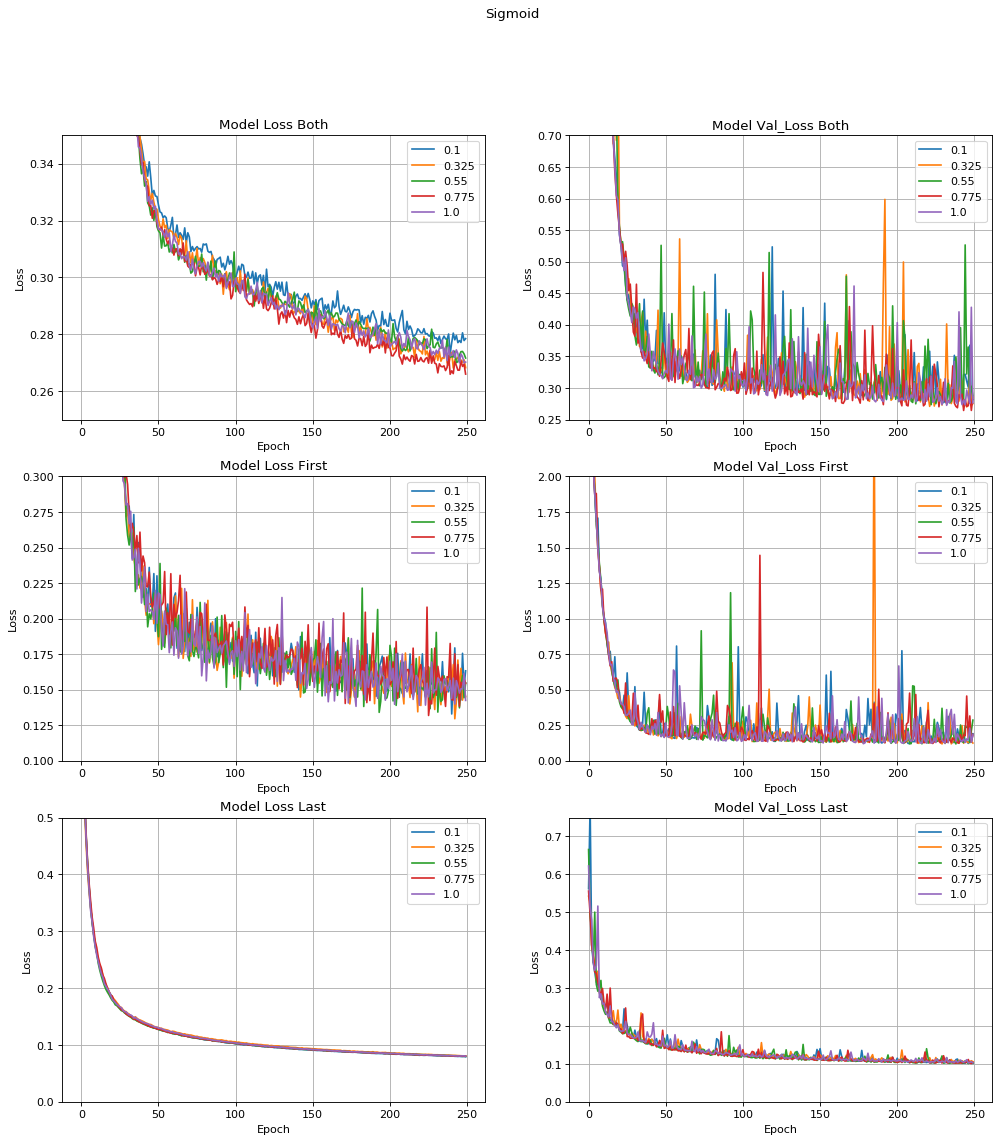

In [161]:
plt.figure(figsize=(15, 16), dpi=80, facecolor='w', edgecolor='b')
plt.subplot(3, 2, 1)
plt.suptitle("Sigmoid")

for i in range(0,5):
    plt.plot(wdecaySigBoth[i].history['loss'])
plt.title('Model Loss Both')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.25,0.35)
plt.grid(True)
plt.legend([str(wdecayValues[0]), str(wdecayValues[1]), str(wdecayValues[2]), str(wdecayValues[3]), str(wdecayValues[4])])

plt.subplot(3, 2, 2)
for i in range(0,5):
    plt.plot(wdecaySigBoth[i].history['val_loss'])
plt.title('Model Val_Loss Both')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.25,0.7)
plt.grid(True)
plt.legend([str(wdecayValues[0]), str(wdecayValues[1]), str(wdecayValues[2]), str(wdecayValues[3]), str(wdecayValues[4])])

plt.subplot(3, 2, 3)
for i in range(0,5):
    plt.plot(wdecaySigFirst[i].history['loss'])
plt.title('Model Loss First')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.1,0.3)
plt.grid(True)
plt.legend([str(wdecayValues[0]), str(wdecayValues[1]), str(wdecayValues[2]), str(wdecayValues[3]), str(wdecayValues[4])])

plt.subplot(3, 2, 4)
for i in range(0,5):
    plt.plot(wdecaySigFirst[i].history['val_loss'])
plt.title('Model Val_Loss First')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,2)
plt.grid(True)
plt.legend([str(wdecayValues[0]), str(wdecayValues[1]), str(wdecayValues[2]), str(wdecayValues[3]), str(wdecayValues[4])])

plt.subplot(3, 2, 5)
for i in range(0,5):
    plt.plot(wdecaySigLast[i].history['loss'])
plt.title('Model Loss Last')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,0.5)
plt.grid(True)
plt.legend([str(wdecayValues[0]), str(wdecayValues[1]), str(wdecayValues[2]), str(wdecayValues[3]), str(wdecayValues[4])])

plt.subplot(3, 2, 6)
for i in range(0,5):
    plt.plot(wdecaySigLast[i].history['val_loss'])
plt.title('Model Val_Loss Last')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,0.75)
plt.grid(True)
plt.legend([str(wdecayValues[0]), str(wdecayValues[1]), str(wdecayValues[2]), str(wdecayValues[3]), str(wdecayValues[4])])

No todos poseen el mismo rango respecto al eje y, esto debido para hacer un zoom a al gráfica y ver mejor su comportamiento. Podemos concluir lo siguiente:

1) Aplicar el regularizador de pesos a la capa de salida no produce mucha diferencia en el conjunto de entrenamiento, en cambio en el set de validación se observan ciertos cambios, pero que en magnitud no son muy significantes como para considerar un peso u otro.

2) Al aplicar los pesos en las capas ocultas vemos que si hay una diferencia respecto a los errores, pero para todos los valores se difumina los resultados de la función error, es decir, no son estrictamente decrecientes y generalmente se solapan, por lo que es muy complicado identificar si mayores o menores valores de weight decay obtenemos resultados mas favorables o no.

3) Respecto a regularizar todas las capas, vemos que tiene un comportamiento similar al de regular las capas ocultas, pero se vuelve mucho mas estable. 

Podriamos decir que en este problema weight decay esta penalizando demasiado los pesos muy grandes, haciendo que varíe constantemente el loss function en las capas ocultas, por lo que no sería un buen regularizador para ocupar en este problema (o probablemente, con esta función de activación).

Ahora hacemos la prueba con ReLu

In [120]:
# Regularizacion para ambas capas
wdecayReLuBoth = list()
wdecayReLuFirst = list()
wdecayReLuLast = list()

print("\n Se aplica weight decay para la primera y ultima capa \n\n")

for i in range(0,5):
    print("Valor weight decay: " + str(wdecayValues[i]) + "\n")
    model = Sequential()
    model.add(Dense(256,input_dim=X_train_scaled.shape[1],kernel_initializer='uniform',W_regularizer=l2(0.01)))
    model.add(Activation('relu'))
    model.add(Dense(1, kernel_initializer='uniform',W_regularizer=l2(0.01)))
    model.add(Activation('linear'))
    model.compile(optimizer=SGD(lr=0.01),loss='mean_squared_error')
    wdecayReLuBoth.append(model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val), callbacks=[TerminateOnNaN()]))

print("\n\n Se aplica weight decay para la primera capa \n\n")    
    
for i in range(0,5):
    print("Valor weight decay: " + str(wdecayValues[i]) + "\n")
    model = Sequential()
    model.add(Dense(256,input_dim=X_train_scaled.shape[1],kernel_initializer='uniform',W_regularizer=l2(0.01)))
    model.add(Activation('relu'))
    model.add(Dense(1, kernel_initializer='uniform'))
    model.add(Activation('linear'))
    model.compile(optimizer=SGD(lr=0.01),loss='mean_squared_error')
    wdecayReLuFirst.append(model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val), callbacks=[TerminateOnNaN()]))
    
print("\n\n Se aplica weight decay para la ultima capa \n")    

for i in range(0,5):
    print("Valor weight decay: " + str(wdecayValues[i]) + "\n")
    model = Sequential()
    model.add(Dense(256,input_dim=X_train_scaled.shape[1],kernel_initializer='uniform'))
    model.add(Activation('relu'))
    model.add(Dense(1, kernel_initializer='uniform',W_regularizer=l2(0.01)))
    model.add(Activation('linear'))
    model.compile(optimizer=SGD(lr=0.01),loss='mean_squared_error')
    wdecayReLuLast.append(model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val), callbacks=[TerminateOnNaN()]))


 Se aplica weight decay para la primera y ultima capa 


Valor weight decay: 0.1



/home/ivalenzu/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, input_dim=1275, kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
  # This is added back by InteractiveShellApp.init_path()
/home/ivalenzu/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
  del sys.path[0]


Train on 9745 samples, validate on 4060 samples
Epoch 1/250
  32/9745 [..............................] - ETA: 23:43 - loss: 137.3350Batch 6: Invalid loss, terminating training
Valor weight decay: 0.325

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
 256/9745 [..............................] - ETA: 2:56 - loss: inf      Batch 7: Invalid loss, terminating training
Valor weight decay: 0.55

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
 224/9745 [..............................] - ETA: 3:23 - loss: 75.9316  Batch 10: Invalid loss, terminating training
Valor weight decay: 0.775

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
 224/9745 [..............................] - ETA: 3:24 - loss: 206.0278 Batch 9: Invalid loss, terminating training
Valor weight decay: 1.0

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
  32/9745 [..............................] - ETA: 24:04 - loss: 160.1517Batch 4: Invalid loss, terminating training


 Se aplica w

/home/ivalenzu/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, input_dim=1275, kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`


  32/9745 [..............................] - ETA: 24:10 - loss: 148.4374Batch 6: Invalid loss, terminating training
Valor weight decay: 0.325

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
 224/9745 [..............................] - ETA: 3:25 - loss: inf      Batch 6: Invalid loss, terminating training
Valor weight decay: 0.55

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
 224/9745 [..............................] - ETA: 3:26 - loss: 22028090939892105216.0000Batch 7: Invalid loss, terminating training
Valor weight decay: 0.775

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
  32/9745 [..............................] - ETA: 24:25 - loss: 155.9133Batch 5: Invalid loss, terminating training
Valor weight decay: 1.0

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
  32/9745 [..............................] - ETA: 24:29 - loss: 118.4118Batch 6: Invalid loss, terminating training


 Se aplica weight decay para la ultima capa 

Valor weigh

/home/ivalenzu/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`


 256/9745 [..............................] - ETA: 3:01 - loss: inf      Batch 7: Invalid loss, terminating training
Valor weight decay: 0.325

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
  32/9745 [..............................] - ETA: 24:37 - loss: 124.7808Batch 4: Invalid loss, terminating training
Valor weight decay: 0.55

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
  32/9745 [..............................] - ETA: 24:43 - loss: 156.4496Batch 5: Invalid loss, terminating training
Valor weight decay: 0.775

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
  32/9745 [..............................] - ETA: 24:43 - loss: 167.0341Batch 4: Invalid loss, terminating training
Valor weight decay: 1.0

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
 480/9745 [>.............................] - ETA: 1:36 - loss: inf    Batch 14: Invalid loss, terminating training


Vemos que para el caso de ReLu no converge.

### 1.i Dropout

Regularizamos usando Dropout

In [106]:
from keras.layers import Dropout

In [121]:
# Se usaran 10 valores para dropout con Sigmoid
dropoutValues= np.linspace(0.1,1,10)
dropoutSig= list()
for i in range(0,10):
    print("Valor dropout: " + str(dropoutValues[i]) + "\n")
    model = Sequential()
    model.add(Dense(256,kernel_initializer='uniform', activation='sigmoid'))
    model.add(Dropout(dropoutValues[i]))
    model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    model.compile(optimizer=SGD(lr=0.01),loss='mean_squared_error')
    dropoutSig.append(model.fit(X_train_scaled.values, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val), callbacks=[TerminateOnNaN()]))

Valor dropout: 0.1

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 9s 880us/step - loss: 1.5209 - val_loss: 0.5427
Epoch 2/250
9745/9745 [==============================] - 3s 306us/step - loss: 0.7196 - val_loss: 0.4589
Epoch 3/250
9745/9745 [==============================] - 3s 311us/step - loss: 0.6351 - val_loss: 0.5695
Epoch 4/250
9745/9745 [==============================] - 3s 312us/step - loss: 0.5923 - val_loss: 0.4772
Epoch 5/250
9745/9745 [==============================] - 3s 311us/step - loss: 0.5478 - val_loss: 0.3845
Epoch 6/250
9745/9745 [==============================] - 3s 310us/step - loss: 0.5093 - val_loss: 0.4626
Epoch 7/250
9745/9745 [==============================] - 3s 311us/step - loss: 0.4793 - val_loss: 0.3663
Epoch 8/250
9745/9745 [==============================] - 3s 311us/step - loss: 0.4624 - val_loss: 0.3095
Epoch 9/250
9745/9745 [==============================] - 3s 309us/step - loss: 0.4466 - val_

Epoch 154/250
9745/9745 [==============================] - 3s 307us/step - loss: 0.1736 - val_loss: 0.1019
Epoch 155/250
9745/9745 [==============================] - 3s 312us/step - loss: 0.1674 - val_loss: 0.1003
Epoch 156/250
9745/9745 [==============================] - 3s 312us/step - loss: 0.1684 - val_loss: 0.0993
Epoch 157/250
9745/9745 [==============================] - 3s 308us/step - loss: 0.1708 - val_loss: 0.1093
Epoch 158/250
9745/9745 [==============================] - 3s 308us/step - loss: 0.1726 - val_loss: 0.1070
Epoch 159/250
9745/9745 [==============================] - 3s 310us/step - loss: 0.1709 - val_loss: 0.1010
Epoch 160/250
9745/9745 [==============================] - 3s 311us/step - loss: 0.1778 - val_loss: 0.1049
Epoch 161/250
9745/9745 [==============================] - 3s 312us/step - loss: 0.1713 - val_loss: 0.1946
Epoch 162/250
9745/9745 [==============================] - 3s 313us/step - loss: 0.1694 - val_loss: 0.1129
Epoch 163/250
9745/9745 [============

9745/9745 [==============================] - 3s 309us/step - loss: 0.3484 - val_loss: 0.1864
Epoch 57/250
9745/9745 [==============================] - 3s 308us/step - loss: 0.3478 - val_loss: 0.2120
Epoch 58/250
9745/9745 [==============================] - 3s 311us/step - loss: 0.3384 - val_loss: 0.1779
Epoch 59/250
9745/9745 [==============================] - 3s 307us/step - loss: 0.3398 - val_loss: 0.2188
Epoch 60/250
9745/9745 [==============================] - 3s 310us/step - loss: 0.3321 - val_loss: 0.1928
Epoch 61/250
9745/9745 [==============================] - 3s 309us/step - loss: 0.3320 - val_loss: 0.1883
Epoch 62/250
9745/9745 [==============================] - 3s 308us/step - loss: 0.3408 - val_loss: 0.1874
Epoch 63/250
9745/9745 [==============================] - 3s 311us/step - loss: 0.3291 - val_loss: 0.2002
Epoch 64/250
9745/9745 [==============================] - 3s 311us/step - loss: 0.3382 - val_loss: 0.1709
Epoch 65/250
9745/9745 [==============================] - 3

9745/9745 [==============================] - 3s 307us/step - loss: 0.2794 - val_loss: 0.1585
Epoch 134/250
9745/9745 [==============================] - 3s 308us/step - loss: 0.2778 - val_loss: 0.2172
Epoch 135/250
9745/9745 [==============================] - 3s 312us/step - loss: 0.2764 - val_loss: 0.1610
Epoch 136/250
9745/9745 [==============================] - 3s 311us/step - loss: 0.2833 - val_loss: 0.1466
Epoch 137/250
9745/9745 [==============================] - 3s 313us/step - loss: 0.2752 - val_loss: 0.2502
Epoch 138/250
9745/9745 [==============================] - 3s 309us/step - loss: 0.2724 - val_loss: 0.1490
Epoch 139/250
9745/9745 [==============================] - 3s 311us/step - loss: 0.2799 - val_loss: 0.1697
Epoch 140/250
9745/9745 [==============================] - 3s 307us/step - loss: 0.2747 - val_loss: 0.2524
Epoch 141/250
9745/9745 [==============================] - 3s 307us/step - loss: 0.2753 - val_loss: 0.1534
Epoch 142/250
9745/9745 [==========================

9745/9745 [==============================] - 3s 311us/step - loss: 0.5038 - val_loss: 0.2766
Epoch 36/250
9745/9745 [==============================] - 3s 305us/step - loss: 0.4759 - val_loss: 0.2583
Epoch 37/250
9745/9745 [==============================] - 3s 306us/step - loss: 0.4838 - val_loss: 0.2315
Epoch 38/250
9745/9745 [==============================] - 3s 308us/step - loss: 0.4794 - val_loss: 0.2310
Epoch 39/250
9745/9745 [==============================] - 3s 310us/step - loss: 0.4684 - val_loss: 0.3220
Epoch 40/250
9745/9745 [==============================] - 3s 310us/step - loss: 0.4599 - val_loss: 0.3264
Epoch 41/250
9745/9745 [==============================] - 3s 309us/step - loss: 0.4680 - val_loss: 0.2638
Epoch 42/250
9745/9745 [==============================] - 3s 305us/step - loss: 0.4576 - val_loss: 0.2272
Epoch 43/250
9745/9745 [==============================] - 3s 308us/step - loss: 0.4571 - val_loss: 0.2636
Epoch 44/250
9745/9745 [==============================] - 3

9745/9745 [==============================] - 3s 311us/step - loss: 0.3373 - val_loss: 0.2030
Epoch 189/250
9745/9745 [==============================] - 3s 313us/step - loss: 0.3385 - val_loss: 0.1936
Epoch 190/250
9745/9745 [==============================] - 3s 309us/step - loss: 0.3378 - val_loss: 0.3059
Epoch 191/250
9745/9745 [==============================] - 3s 309us/step - loss: 0.3331 - val_loss: 0.1757
Epoch 192/250
9745/9745 [==============================] - 3s 311us/step - loss: 0.3374 - val_loss: 0.2104
Epoch 193/250
9745/9745 [==============================] - 3s 308us/step - loss: 0.3541 - val_loss: 0.2090
Epoch 194/250
9745/9745 [==============================] - 3s 313us/step - loss: 0.3415 - val_loss: 0.1924
Epoch 195/250
9745/9745 [==============================] - 3s 313us/step - loss: 0.3438 - val_loss: 0.1802
Epoch 196/250
9745/9745 [==============================] - 3s 309us/step - loss: 0.3385 - val_loss: 0.1687
Epoch 197/250
9745/9745 [==========================

9745/9745 [==============================] - 3s 308us/step - loss: 0.4852 - val_loss: 0.3147
Epoch 92/250
9745/9745 [==============================] - 3s 310us/step - loss: 0.4752 - val_loss: 0.2373
Epoch 93/250
9745/9745 [==============================] - 3s 308us/step - loss: 0.4829 - val_loss: 0.2230
Epoch 94/250
9745/9745 [==============================] - 3s 312us/step - loss: 0.4831 - val_loss: 0.2267
Epoch 95/250
9745/9745 [==============================] - 3s 307us/step - loss: 0.4749 - val_loss: 0.2313
Epoch 96/250
9745/9745 [==============================] - 3s 310us/step - loss: 0.4782 - val_loss: 0.2162
Epoch 97/250
9745/9745 [==============================] - 3s 305us/step - loss: 0.4906 - val_loss: 0.3927
Epoch 98/250
9745/9745 [==============================] - 3s 310us/step - loss: 0.4721 - val_loss: 0.3431
Epoch 99/250
9745/9745 [==============================] - 3s 311us/step - loss: 0.4685 - val_loss: 0.2833
Epoch 100/250
9745/9745 [==============================] - 

Epoch 168/250
9745/9745 [==============================] - 3s 308us/step - loss: 0.4444 - val_loss: 0.2204
Epoch 169/250
9745/9745 [==============================] - 3s 309us/step - loss: 0.4386 - val_loss: 0.3628
Epoch 170/250
9745/9745 [==============================] - 3s 311us/step - loss: 0.4438 - val_loss: 0.2207
Epoch 171/250
9745/9745 [==============================] - 3s 311us/step - loss: 0.4370 - val_loss: 0.2267
Epoch 172/250
9745/9745 [==============================] - 3s 309us/step - loss: 0.4327 - val_loss: 0.2897
Epoch 173/250
9745/9745 [==============================] - 3s 310us/step - loss: 0.4372 - val_loss: 0.2057
Epoch 174/250
9745/9745 [==============================] - 3s 314us/step - loss: 0.4412 - val_loss: 0.3263
Epoch 175/250
9745/9745 [==============================] - 3s 309us/step - loss: 0.4430 - val_loss: 0.1976
Epoch 176/250
9745/9745 [==============================] - 3s 314us/step - loss: 0.4513 - val_loss: 0.2070
Epoch 177/250
9745/9745 [============

Epoch 71/250
9745/9745 [==============================] - 3s 313us/step - loss: 0.6271 - val_loss: 0.2633
Epoch 72/250
9745/9745 [==============================] - 3s 316us/step - loss: 0.6317 - val_loss: 0.4352
Epoch 73/250
9745/9745 [==============================] - 3s 311us/step - loss: 0.6298 - val_loss: 0.2648
Epoch 74/250
9745/9745 [==============================] - 3s 310us/step - loss: 0.6161 - val_loss: 0.4750
Epoch 75/250
9745/9745 [==============================] - 3s 312us/step - loss: 0.6230 - val_loss: 0.4051
Epoch 76/250
9745/9745 [==============================] - 3s 308us/step - loss: 0.6013 - val_loss: 0.4765
Epoch 77/250
9745/9745 [==============================] - 3s 312us/step - loss: 0.6235 - val_loss: 0.2714
Epoch 78/250
9745/9745 [==============================] - 3s 309us/step - loss: 0.6186 - val_loss: 0.2943
Epoch 79/250
9745/9745 [==============================] - 3s 315us/step - loss: 0.6269 - val_loss: 0.2865
Epoch 80/250
9745/9745 [======================

Epoch 148/250
9745/9745 [==============================] - 3s 309us/step - loss: 0.5597 - val_loss: 0.2504
Epoch 149/250
9745/9745 [==============================] - 3s 309us/step - loss: 0.5697 - val_loss: 0.2323
Epoch 150/250
9745/9745 [==============================] - 3s 312us/step - loss: 0.5736 - val_loss: 0.2467
Epoch 151/250
9745/9745 [==============================] - 3s 315us/step - loss: 0.5643 - val_loss: 0.3094
Epoch 152/250
9745/9745 [==============================] - 3s 309us/step - loss: 0.5671 - val_loss: 0.2628
Epoch 153/250
9745/9745 [==============================] - 3s 312us/step - loss: 0.5670 - val_loss: 0.2773
Epoch 154/250
9745/9745 [==============================] - 3s 314us/step - loss: 0.5648 - val_loss: 0.3484
Epoch 155/250
9745/9745 [==============================] - 3s 308us/step - loss: 0.5755 - val_loss: 0.2643
Epoch 156/250
9745/9745 [==============================] - 3s 310us/step - loss: 0.5641 - val_loss: 0.2848
Epoch 157/250
9745/9745 [============

9745/9745 [==============================] - 3s 312us/step - loss: 0.8228 - val_loss: 0.4713
Epoch 51/250
9745/9745 [==============================] - 3s 315us/step - loss: 0.8153 - val_loss: 0.3348
Epoch 52/250
9745/9745 [==============================] - 3s 313us/step - loss: 0.8379 - val_loss: 0.3403
Epoch 53/250
9745/9745 [==============================] - 3s 310us/step - loss: 0.8056 - val_loss: 0.3590
Epoch 54/250
9745/9745 [==============================] - 3s 311us/step - loss: 0.8183 - val_loss: 0.4390
Epoch 55/250
9745/9745 [==============================] - 3s 315us/step - loss: 0.8281 - val_loss: 0.3256
Epoch 56/250
9745/9745 [==============================] - 3s 314us/step - loss: 0.7980 - val_loss: 0.3194
Epoch 57/250
9745/9745 [==============================] - 3s 312us/step - loss: 0.8046 - val_loss: 0.3414
Epoch 58/250
9745/9745 [==============================] - 3s 316us/step - loss: 0.8238 - val_loss: 0.4067
Epoch 59/250
9745/9745 [==============================] - 3

9745/9745 [==============================] - 3s 314us/step - loss: 0.7121 - val_loss: 0.2628
Epoch 204/250
9745/9745 [==============================] - 3s 316us/step - loss: 0.6977 - val_loss: 0.2974
Epoch 205/250
9745/9745 [==============================] - 3s 309us/step - loss: 0.6969 - val_loss: 0.2643
Epoch 206/250
9745/9745 [==============================] - 3s 314us/step - loss: 0.7110 - val_loss: 0.3150
Epoch 207/250
9745/9745 [==============================] - 3s 315us/step - loss: 0.7110 - val_loss: 0.3358
Epoch 208/250
9745/9745 [==============================] - 3s 312us/step - loss: 0.6961 - val_loss: 0.2855
Epoch 209/250
9745/9745 [==============================] - 3s 314us/step - loss: 0.6863 - val_loss: 0.4540
Epoch 210/250
9745/9745 [==============================] - 3s 313us/step - loss: 0.7258 - val_loss: 0.2935
Epoch 211/250
9745/9745 [==============================] - 3s 312us/step - loss: 0.7076 - val_loss: 0.2541
Epoch 212/250
9745/9745 [==========================

9745/9745 [==============================] - 3s 312us/step - loss: 1.0307 - val_loss: 0.3500
Epoch 107/250
9745/9745 [==============================] - 3s 305us/step - loss: 0.9881 - val_loss: 0.3779
Epoch 108/250
9745/9745 [==============================] - 3s 309us/step - loss: 1.0200 - val_loss: 0.3999
Epoch 109/250
9745/9745 [==============================] - 3s 310us/step - loss: 1.0170 - val_loss: 0.5022
Epoch 110/250
9745/9745 [==============================] - 3s 308us/step - loss: 0.9775 - val_loss: 1.0036
Epoch 111/250
9745/9745 [==============================] - 3s 315us/step - loss: 1.0049 - val_loss: 0.5019
Epoch 112/250
9745/9745 [==============================] - 3s 311us/step - loss: 0.9931 - val_loss: 0.4736
Epoch 113/250
9745/9745 [==============================] - 3s 314us/step - loss: 0.9919 - val_loss: 0.3424
Epoch 114/250
9745/9745 [==============================] - 3s 313us/step - loss: 0.9791 - val_loss: 0.3898
Epoch 115/250
9745/9745 [==========================

9745/9745 [==============================] - 3s 315us/step - loss: 2.0174 - val_loss: 0.6800
Epoch 9/250
9745/9745 [==============================] - 3s 313us/step - loss: 1.8764 - val_loss: 0.6131
Epoch 10/250
9745/9745 [==============================] - 3s 312us/step - loss: 1.8178 - val_loss: 1.2549
Epoch 11/250
9745/9745 [==============================] - 3s 308us/step - loss: 1.7681 - val_loss: 0.5806
Epoch 12/250
9745/9745 [==============================] - 3s 313us/step - loss: 1.7413 - val_loss: 0.6190
Epoch 13/250
9745/9745 [==============================] - 3s 308us/step - loss: 1.7343 - val_loss: 0.6510
Epoch 14/250
9745/9745 [==============================] - 3s 311us/step - loss: 1.7327 - val_loss: 0.8336
Epoch 15/250
9745/9745 [==============================] - 3s 308us/step - loss: 1.6787 - val_loss: 0.5592
Epoch 16/250
9745/9745 [==============================] - 3s 312us/step - loss: 1.6910 - val_loss: 0.6205
Epoch 17/250
9745/9745 [==============================] - 3s

Epoch 162/250
9745/9745 [==============================] - 3s 311us/step - loss: 1.4589 - val_loss: 0.4252
Epoch 163/250
9745/9745 [==============================] - 3s 309us/step - loss: 1.4125 - val_loss: 0.4192
Epoch 164/250
9745/9745 [==============================] - 3s 312us/step - loss: 1.4450 - val_loss: 0.4367
Epoch 165/250
9745/9745 [==============================] - 3s 314us/step - loss: 1.3786 - val_loss: 0.5290
Epoch 166/250
9745/9745 [==============================] - 3s 311us/step - loss: 1.4129 - val_loss: 0.4501
Epoch 167/250
9745/9745 [==============================] - 3s 310us/step - loss: 1.4515 - val_loss: 0.8438
Epoch 168/250
9745/9745 [==============================] - 3s 311us/step - loss: 1.4574 - val_loss: 0.4747
Epoch 169/250
9745/9745 [==============================] - 3s 309us/step - loss: 1.3508 - val_loss: 0.4202
Epoch 170/250
9745/9745 [==============================] - 3s 312us/step - loss: 1.3939 - val_loss: 0.4398
Epoch 171/250
9745/9745 [============

9745/9745 [==============================] - 3s 315us/step - loss: 2.9578 - val_loss: 0.9609
Epoch 65/250
9745/9745 [==============================] - 3s 312us/step - loss: 3.0304 - val_loss: 0.5784
Epoch 66/250
9745/9745 [==============================] - 3s 315us/step - loss: 3.0548 - val_loss: 0.8238
Epoch 67/250
9745/9745 [==============================] - 3s 316us/step - loss: 2.9746 - val_loss: 1.4093
Epoch 68/250
9745/9745 [==============================] - 3s 313us/step - loss: 2.9424 - val_loss: 0.5639
Epoch 69/250
9745/9745 [==============================] - 3s 317us/step - loss: 3.1661 - val_loss: 0.5476
Epoch 70/250
9745/9745 [==============================] - 3s 315us/step - loss: 3.1916 - val_loss: 0.5239
Epoch 71/250
9745/9745 [==============================] - 3s 313us/step - loss: 3.0794 - val_loss: 0.5868
Epoch 72/250
9745/9745 [==============================] - 3s 316us/step - loss: 2.9927 - val_loss: 0.7207
Epoch 73/250
9745/9745 [==============================] - 3

9745/9745 [==============================] - 3s 317us/step - loss: 2.8270 - val_loss: 0.7456
Epoch 142/250
9745/9745 [==============================] - 3s 311us/step - loss: 2.9122 - val_loss: 0.4334
Epoch 143/250
9745/9745 [==============================] - 3s 315us/step - loss: 2.7331 - val_loss: 0.6430
Epoch 144/250
9745/9745 [==============================] - 3s 316us/step - loss: 2.7379 - val_loss: 0.6445
Epoch 145/250
9745/9745 [==============================] - 3s 317us/step - loss: 3.1124 - val_loss: 0.6073
Epoch 146/250
9745/9745 [==============================] - 3s 313us/step - loss: 2.9181 - val_loss: 0.9569
Epoch 147/250
9745/9745 [==============================] - 3s 317us/step - loss: 2.8200 - val_loss: 0.6260
Epoch 148/250
9745/9745 [==============================] - 3s 312us/step - loss: 2.8642 - val_loss: 0.9943
Epoch 149/250
9745/9745 [==============================] - 3s 314us/step - loss: 2.9270 - val_loss: 1.2305
Epoch 150/250
9745/9745 [==========================

9745/9745 [==============================] - 3s 304us/step - loss: 0.0444 - val_loss: 0.0578
Epoch 44/250
9745/9745 [==============================] - 3s 303us/step - loss: 0.0453 - val_loss: 0.0559
Epoch 45/250
9745/9745 [==============================] - 3s 305us/step - loss: 0.0444 - val_loss: 0.0629
Epoch 46/250
9745/9745 [==============================] - 3s 302us/step - loss: 0.0425 - val_loss: 0.0604
Epoch 47/250
9745/9745 [==============================] - 3s 308us/step - loss: 0.0426 - val_loss: 0.0632
Epoch 48/250
9745/9745 [==============================] - 3s 307us/step - loss: 0.0429 - val_loss: 0.0601
Epoch 49/250
9745/9745 [==============================] - 3s 303us/step - loss: 0.0420 - val_loss: 0.0548
Epoch 50/250
9745/9745 [==============================] - 3s 305us/step - loss: 0.0402 - val_loss: 0.0533
Epoch 51/250
9745/9745 [==============================] - 3s 305us/step - loss: 0.0422 - val_loss: 0.0588
Epoch 52/250
9745/9745 [==============================] - 3

9745/9745 [==============================] - 3s 309us/step - loss: 0.0158 - val_loss: 0.0408
Epoch 197/250
9745/9745 [==============================] - 3s 309us/step - loss: 0.0162 - val_loss: 0.0376
Epoch 198/250
9745/9745 [==============================] - 3s 307us/step - loss: 0.0162 - val_loss: 0.0349
Epoch 199/250
9745/9745 [==============================] - 3s 298us/step - loss: 0.0164 - val_loss: 0.0399
Epoch 200/250
9745/9745 [==============================] - 3s 304us/step - loss: 0.0163 - val_loss: 0.0361
Epoch 201/250
9745/9745 [==============================] - 3s 305us/step - loss: 0.0167 - val_loss: 0.0373
Epoch 202/250
9745/9745 [==============================] - 3s 304us/step - loss: 0.0159 - val_loss: 0.0352
Epoch 203/250
9745/9745 [==============================] - 3s 306us/step - loss: 0.0157 - val_loss: 0.0382
Epoch 204/250
9745/9745 [==============================] - 3s 305us/step - loss: 0.0157 - val_loss: 0.0416
Epoch 205/250
9745/9745 [==========================

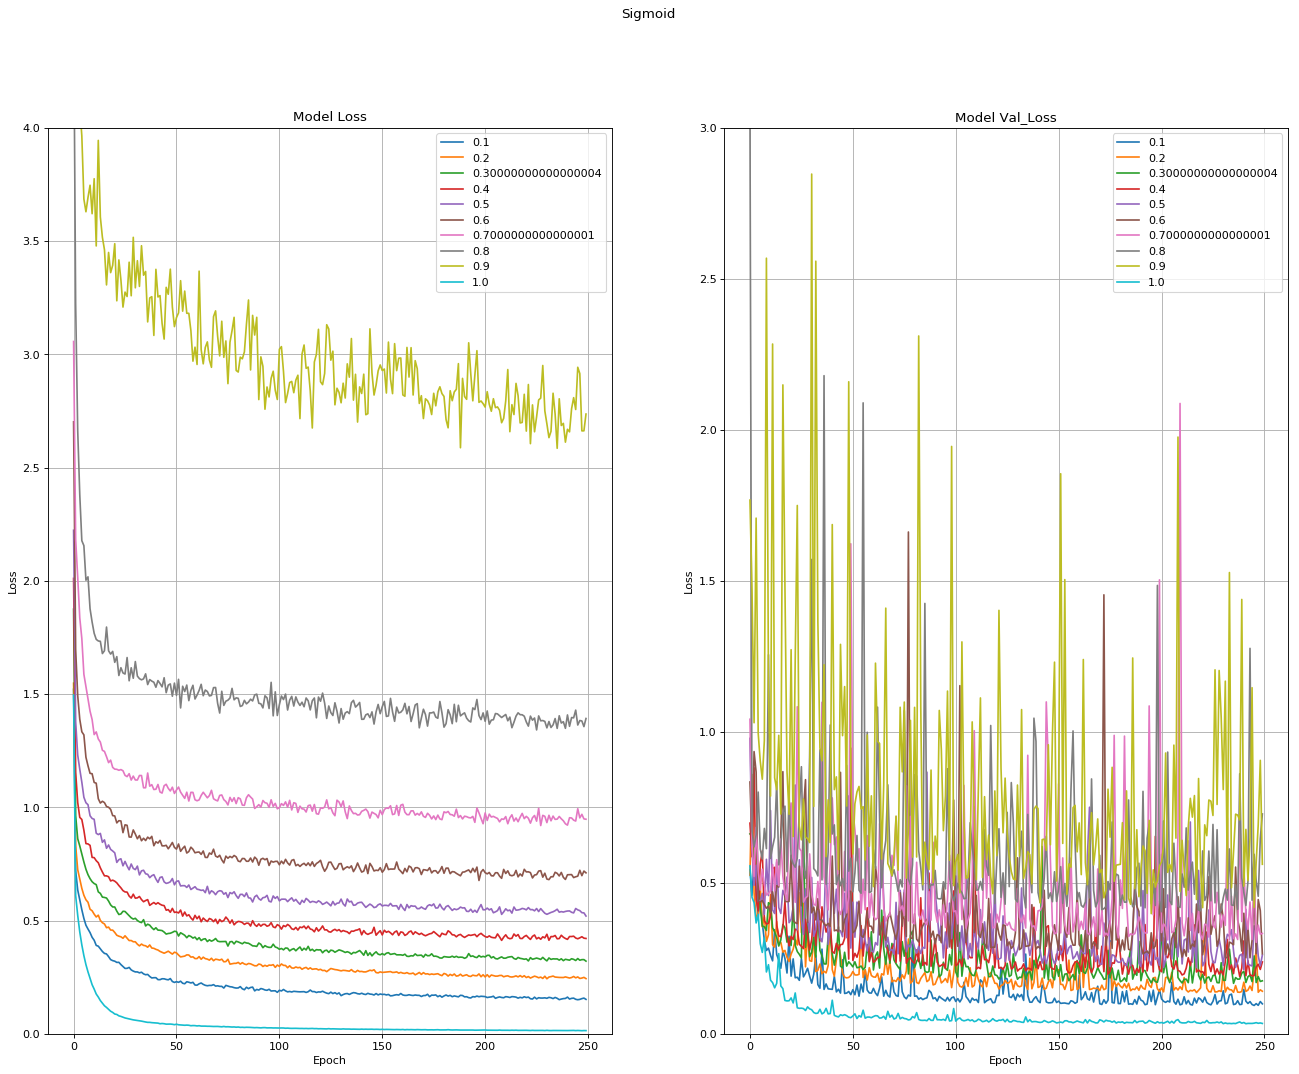

In [164]:
plt.figure(figsize=(20, 15), dpi=80, facecolor='w', edgecolor='b')
plt.subplot(1, 2, 1)
plt.suptitle("Sigmoid")

for i in range(0,10):
    plt.plot(dropoutSig[i].history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,4)
plt.grid(True)
plt.legend([str(dropoutValues[0]), dropoutValues[1], dropoutValues[2], dropoutValues[3], dropoutValues[4],
            dropoutValues[5], dropoutValues[6], dropoutValues[7], dropoutValues[8], dropoutValues[9]])

plt.subplot(1, 2, 2)
for i in range(0,10):
    plt.plot(dropoutSig[i].history['val_loss'])
plt.title('Model Val_Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.grid(True)
plt.legend([str(dropoutValues[0]), dropoutValues[1], dropoutValues[2], dropoutValues[3], dropoutValues[4],
            dropoutValues[5], dropoutValues[6], dropoutValues[7], dropoutValues[8], dropoutValues[9]])

Analizando el set de entrenamiento vemos que mientras menor sea el ratio de dropout (es decir, el porcentaje de neuronas inactivas durante el entrenamiento) obtendremos menor error y con un decrecimiento mas constante. El caso ajeno es cuando el ratio es 1, pero es comprensible ya que eso implica que todas las neuronas esten inactivas, por lo que no habría entrenamiento. El costo de utilizar dropout cuando hay pocos parámetros involucrados en el entrenamiento se ve en el conjunto de validación, donde los errores a pesar de ser bajos, son demasiado inestables y no parece mejorar sustancialmente a través de las epoch. Probablemente con una mayor cantidad de parámetros involucrados ayudaría a reducir el overfitting en la red, pero aún así, el porcentaje de neuronas inactivas no debiese ser mayor al 20%, aunque claramente dependerá del problema a implementar y de los conjuntos de entrenamiento y validación.

Analizando Dropout pero ahora con función de activación ReLu, obtenemos lo siguiente:

In [165]:
# Se usaran 10 valores para dropout con ReLu
dropoutReLu= list()

for i in range(0,10):
    print("Valor dropout: " + str(dropoutValues[i]) + "\n")
    model = Sequential()
    model.add(Dense(256,kernel_initializer='uniform', activation='relu'))
    model.add(Dropout(dropoutValues[i]))
    model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    model.compile(optimizer=SGD(lr=0.001),loss='mean_squared_error')
    dropoutReLu.append(model.fit(X_train_scaled.values, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val), callbacks=[TerminateOnNaN()]))

Valor dropout: 0.1

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 10s 986us/step - loss: 8.2684 - val_loss: 2.6499
Epoch 2/250
9745/9745 [==============================] - 3s 322us/step - loss: 1.9957 - val_loss: 1.5114
Epoch 3/250
9745/9745 [==============================] - 3s 327us/step - loss: 1.1700 - val_loss: 1.5712
Epoch 4/250
9745/9745 [==============================] - 3s 327us/step - loss: 1.0195 - val_loss: 1.2864
Epoch 5/250
9745/9745 [==============================] - 3s 329us/step - loss: 0.8782 - val_loss: 1.3667
Epoch 6/250
9745/9745 [==============================] - 3s 326us/step - loss: 0.9753 - val_loss: 1.2065
Epoch 7/250
9745/9745 [==============================] - 3s 329us/step - loss: 0.9255 - val_loss: 0.9659
Epoch 8/250
9745/9745 [==============================] - 3s 329us/step - loss: 0.7655 - val_loss: 1.4826
Epoch 9/250
9745/9745 [==============================] - 3s 326us/step - loss: 0.6872 - val

Epoch 154/250
9745/9745 [==============================] - 3s 325us/step - loss: 0.1964 - val_loss: 0.6473
Epoch 155/250
9745/9745 [==============================] - 3s 324us/step - loss: 0.1956 - val_loss: 1.0472
Epoch 156/250
9745/9745 [==============================] - 3s 333us/step - loss: 0.1969 - val_loss: 0.5918
Epoch 157/250
9745/9745 [==============================] - 3s 324us/step - loss: 0.1982 - val_loss: 1.1629
Epoch 158/250
9745/9745 [==============================] - 3s 326us/step - loss: 0.2000 - val_loss: 0.6215
Epoch 159/250
9745/9745 [==============================] - 3s 325us/step - loss: 0.1966 - val_loss: 0.6157
Epoch 160/250
9745/9745 [==============================] - 3s 327us/step - loss: 0.2088 - val_loss: 0.7067
Epoch 161/250
9745/9745 [==============================] - 3s 328us/step - loss: 0.1977 - val_loss: 0.6450
Epoch 162/250
9745/9745 [==============================] - 3s 325us/step - loss: 0.2053 - val_loss: 0.6126
Epoch 163/250
9745/9745 [============

9745/9745 [==============================] - 3s 325us/step - loss: 0.4880 - val_loss: 0.5267
Epoch 57/250
9745/9745 [==============================] - 3s 325us/step - loss: 0.4963 - val_loss: 0.7993
Epoch 58/250
9745/9745 [==============================] - 3s 330us/step - loss: 0.4785 - val_loss: 0.4924
Epoch 59/250
9745/9745 [==============================] - 3s 329us/step - loss: 0.5013 - val_loss: 0.5329
Epoch 60/250
9745/9745 [==============================] - 3s 325us/step - loss: 0.4910 - val_loss: 0.9454
Epoch 61/250
9745/9745 [==============================] - 3s 324us/step - loss: 0.4869 - val_loss: 0.5201
Epoch 62/250
9745/9745 [==============================] - 3s 327us/step - loss: 0.4970 - val_loss: 0.7637
Epoch 63/250
9745/9745 [==============================] - 3s 323us/step - loss: 0.4863 - val_loss: 0.5403
Epoch 64/250
9745/9745 [==============================] - 3s 327us/step - loss: 0.4625 - val_loss: 0.5119
Epoch 65/250
9745/9745 [==============================] - 3

9745/9745 [==============================] - 3s 325us/step - loss: 0.3296 - val_loss: 0.5916
Epoch 134/250
9745/9745 [==============================] - 3s 328us/step - loss: 0.3428 - val_loss: 0.5552
Epoch 135/250
9745/9745 [==============================] - 3s 325us/step - loss: 0.3302 - val_loss: 0.5456
Epoch 136/250
9745/9745 [==============================] - 3s 326us/step - loss: 0.3508 - val_loss: 0.5171
Epoch 137/250
9745/9745 [==============================] - 3s 325us/step - loss: 0.3237 - val_loss: 0.5884
Epoch 138/250
9745/9745 [==============================] - 3s 331us/step - loss: 0.3398 - val_loss: 0.5684
Epoch 139/250
9745/9745 [==============================] - 3s 329us/step - loss: 0.3307 - val_loss: 0.5636
Epoch 140/250
9745/9745 [==============================] - 3s 324us/step - loss: 0.3153 - val_loss: 0.5865
Epoch 141/250
9745/9745 [==============================] - 3s 319us/step - loss: 0.3213 - val_loss: 0.6189
Epoch 142/250
9745/9745 [==========================

9745/9745 [==============================] - 3s 331us/step - loss: 0.8593 - val_loss: 0.6066
Epoch 36/250
9745/9745 [==============================] - 3s 329us/step - loss: 0.8009 - val_loss: 0.6559
Epoch 37/250
9745/9745 [==============================] - 3s 329us/step - loss: 0.7891 - val_loss: 1.1010
Epoch 38/250
9745/9745 [==============================] - 3s 329us/step - loss: 0.8682 - val_loss: 0.9605
Epoch 39/250
9745/9745 [==============================] - 3s 328us/step - loss: 0.8327 - val_loss: 0.6533
Epoch 40/250
9745/9745 [==============================] - 3s 329us/step - loss: 0.7409 - val_loss: 0.5524
Epoch 41/250
9745/9745 [==============================] - 3s 330us/step - loss: 0.7989 - val_loss: 0.6683
Epoch 42/250
9745/9745 [==============================] - 3s 326us/step - loss: 0.7897 - val_loss: 0.6236
Epoch 43/250
9745/9745 [==============================] - 3s 326us/step - loss: 0.7727 - val_loss: 0.7581
Epoch 44/250
9745/9745 [==============================] - 3

9745/9745 [==============================] - 3s 329us/step - loss: 0.3529 - val_loss: 0.7216
Epoch 189/250
9745/9745 [==============================] - 3s 330us/step - loss: 0.3507 - val_loss: 0.5781
Epoch 190/250
9745/9745 [==============================] - 3s 323us/step - loss: 0.3554 - val_loss: 0.6074
Epoch 191/250
9745/9745 [==============================] - 3s 324us/step - loss: 0.3481 - val_loss: 0.6229
Epoch 192/250
9745/9745 [==============================] - 3s 329us/step - loss: 0.3459 - val_loss: 0.6486
Epoch 193/250
9745/9745 [==============================] - 3s 327us/step - loss: 0.3431 - val_loss: 0.6544
Epoch 194/250
9745/9745 [==============================] - 3s 333us/step - loss: 0.3353 - val_loss: 0.6901
Epoch 195/250
9745/9745 [==============================] - 3s 330us/step - loss: 0.3310 - val_loss: 0.5969
Epoch 196/250
9745/9745 [==============================] - 3s 328us/step - loss: 0.3463 - val_loss: 0.6024
Epoch 197/250
9745/9745 [==========================

9745/9745 [==============================] - 3s 325us/step - loss: 0.6285 - val_loss: 0.5500
Epoch 92/250
9745/9745 [==============================] - 3s 325us/step - loss: 0.6496 - val_loss: 0.5743
Epoch 93/250
9745/9745 [==============================] - 3s 328us/step - loss: 0.6673 - val_loss: 0.6692
Epoch 94/250
9745/9745 [==============================] - 3s 331us/step - loss: 0.6002 - val_loss: 0.6602
Epoch 95/250
9745/9745 [==============================] - 3s 331us/step - loss: 0.6310 - val_loss: 0.7390
Epoch 96/250
9745/9745 [==============================] - 3s 325us/step - loss: 0.6116 - val_loss: 0.7344
Epoch 97/250
9745/9745 [==============================] - 3s 330us/step - loss: 0.5949 - val_loss: 0.6370
Epoch 98/250
9745/9745 [==============================] - 3s 328us/step - loss: 0.6144 - val_loss: 0.5679
Epoch 99/250
9745/9745 [==============================] - 3s 330us/step - loss: 0.6094 - val_loss: 0.6802
Epoch 100/250
9745/9745 [==============================] - 

Epoch 168/250
9745/9745 [==============================] - 3s 328us/step - loss: 0.4142 - val_loss: 0.6912
Epoch 169/250
9745/9745 [==============================] - 3s 326us/step - loss: 0.4078 - val_loss: 0.6398
Epoch 170/250
9745/9745 [==============================] - 3s 327us/step - loss: 0.3889 - val_loss: 0.7133
Epoch 171/250
9745/9745 [==============================] - 3s 326us/step - loss: 0.4348 - val_loss: 0.7767
Epoch 172/250
9745/9745 [==============================] - 3s 328us/step - loss: 0.4071 - val_loss: 0.6967
Epoch 173/250
9745/9745 [==============================] - 3s 329us/step - loss: 0.3943 - val_loss: 0.6429
Epoch 174/250
9745/9745 [==============================] - 3s 325us/step - loss: 0.4035 - val_loss: 0.7341
Epoch 175/250
9745/9745 [==============================] - 3s 325us/step - loss: 0.3952 - val_loss: 0.6320
Epoch 176/250
9745/9745 [==============================] - 3s 332us/step - loss: 0.4056 - val_loss: 0.7293
Epoch 177/250
9745/9745 [============

Epoch 71/250
9745/9745 [==============================] - 3s 328us/step - loss: 0.8332 - val_loss: 0.6638
Epoch 72/250
9745/9745 [==============================] - 3s 331us/step - loss: 0.7998 - val_loss: 0.5788
Epoch 73/250
9745/9745 [==============================] - 3s 326us/step - loss: 0.8117 - val_loss: 0.7294
Epoch 74/250
9745/9745 [==============================] - 3s 329us/step - loss: 0.9023 - val_loss: 0.6135
Epoch 75/250
9745/9745 [==============================] - 3s 328us/step - loss: 0.7854 - val_loss: 0.6201
Epoch 76/250
9745/9745 [==============================] - 3s 330us/step - loss: 0.8126 - val_loss: 1.6575
Epoch 77/250
9745/9745 [==============================] - 3s 327us/step - loss: 0.7815 - val_loss: 0.6125
Epoch 78/250
9745/9745 [==============================] - 3s 332us/step - loss: 0.8028 - val_loss: 0.8880
Epoch 79/250
9745/9745 [==============================] - 3s 329us/step - loss: 0.8336 - val_loss: 0.6187
Epoch 80/250
9745/9745 [======================

Epoch 148/250
9745/9745 [==============================] - 3s 328us/step - loss: 0.5022 - val_loss: 0.5516
Epoch 149/250
9745/9745 [==============================] - 3s 330us/step - loss: 0.5095 - val_loss: 0.6158
Epoch 150/250
9745/9745 [==============================] - 3s 325us/step - loss: 0.4838 - val_loss: 0.5700
Epoch 151/250
9745/9745 [==============================] - 3s 333us/step - loss: 0.5000 - val_loss: 0.5585
Epoch 152/250
9745/9745 [==============================] - 3s 329us/step - loss: 0.4855 - val_loss: 0.6143
Epoch 153/250
9745/9745 [==============================] - 3s 328us/step - loss: 0.4854 - val_loss: 0.5837
Epoch 154/250
9745/9745 [==============================] - 3s 329us/step - loss: 0.4635 - val_loss: 0.5843
Epoch 155/250
9745/9745 [==============================] - 3s 328us/step - loss: 0.5196 - val_loss: 0.6535
Epoch 156/250
9745/9745 [==============================] - 3s 333us/step - loss: 0.4836 - val_loss: 0.6091
Epoch 157/250
9745/9745 [============

/home/ivalenzu/redesneuronales/lib/python3.6/site-packages/keras/utils/generic_utils.py:338: RuntimeWarning: invalid value encountered in multiply
  self._values[k][0] += v * (current - self._seen_so_far)
/home/ivalenzu/redesneuronales/lib/python3.6/site-packages/keras/utils/generic_utils.py:338: RuntimeWarning: invalid value encountered in double_scalars
  self._values[k][0] += v * (current - self._seen_so_far)


Train on 9745 samples, validate on 4060 samples
Epoch 1/250
6784/9745 [===================>..........] - ETA: 3s - loss: 426.6920Batch 214: Invalid loss, terminating training
Valor dropout: 0.8

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
 640/9745 [>.............................] - ETA: 1:24 - loss: 2242.4937Batch 22: Invalid loss, terminating training
Valor dropout: 0.9

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
 416/9745 [>.............................] - ETA: 2:12 - loss: 6402854189.6595Batch 14: Invalid loss, terminating training
Valor dropout: 1.0

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 10s 996us/step - loss: 9.3936 - val_loss: 3.4871
Epoch 2/250
9745/9745 [==============================] - 3s 322us/step - loss: 1.4771 - val_loss: 1.4893
Epoch 3/250
9745/9745 [==============================] - 3s 324us/step - loss: 0.8100 - val_loss: 1.3263
Epoch 4/250
9745/9745 [==================

Epoch 149/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.0326 - val_loss: 0.2463
Epoch 150/250
9745/9745 [==============================] - 3s 324us/step - loss: 0.0336 - val_loss: 0.2227
Epoch 151/250
9745/9745 [==============================] - 3s 324us/step - loss: 0.0317 - val_loss: 0.2264
Epoch 152/250
9745/9745 [==============================] - 3s 326us/step - loss: 0.0323 - val_loss: 0.2336
Epoch 153/250
9745/9745 [==============================] - 3s 325us/step - loss: 0.0342 - val_loss: 0.2253
Epoch 154/250
9745/9745 [==============================] - 3s 323us/step - loss: 0.0328 - val_loss: 0.2736
Epoch 155/250
9745/9745 [==============================] - 3s 322us/step - loss: 0.0313 - val_loss: 0.2307
Epoch 156/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.0322 - val_loss: 0.2131
Epoch 157/250
9745/9745 [==============================] - 3s 323us/step - loss: 0.0335 - val_loss: 0.2121
Epoch 158/250
9745/9745 [============

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



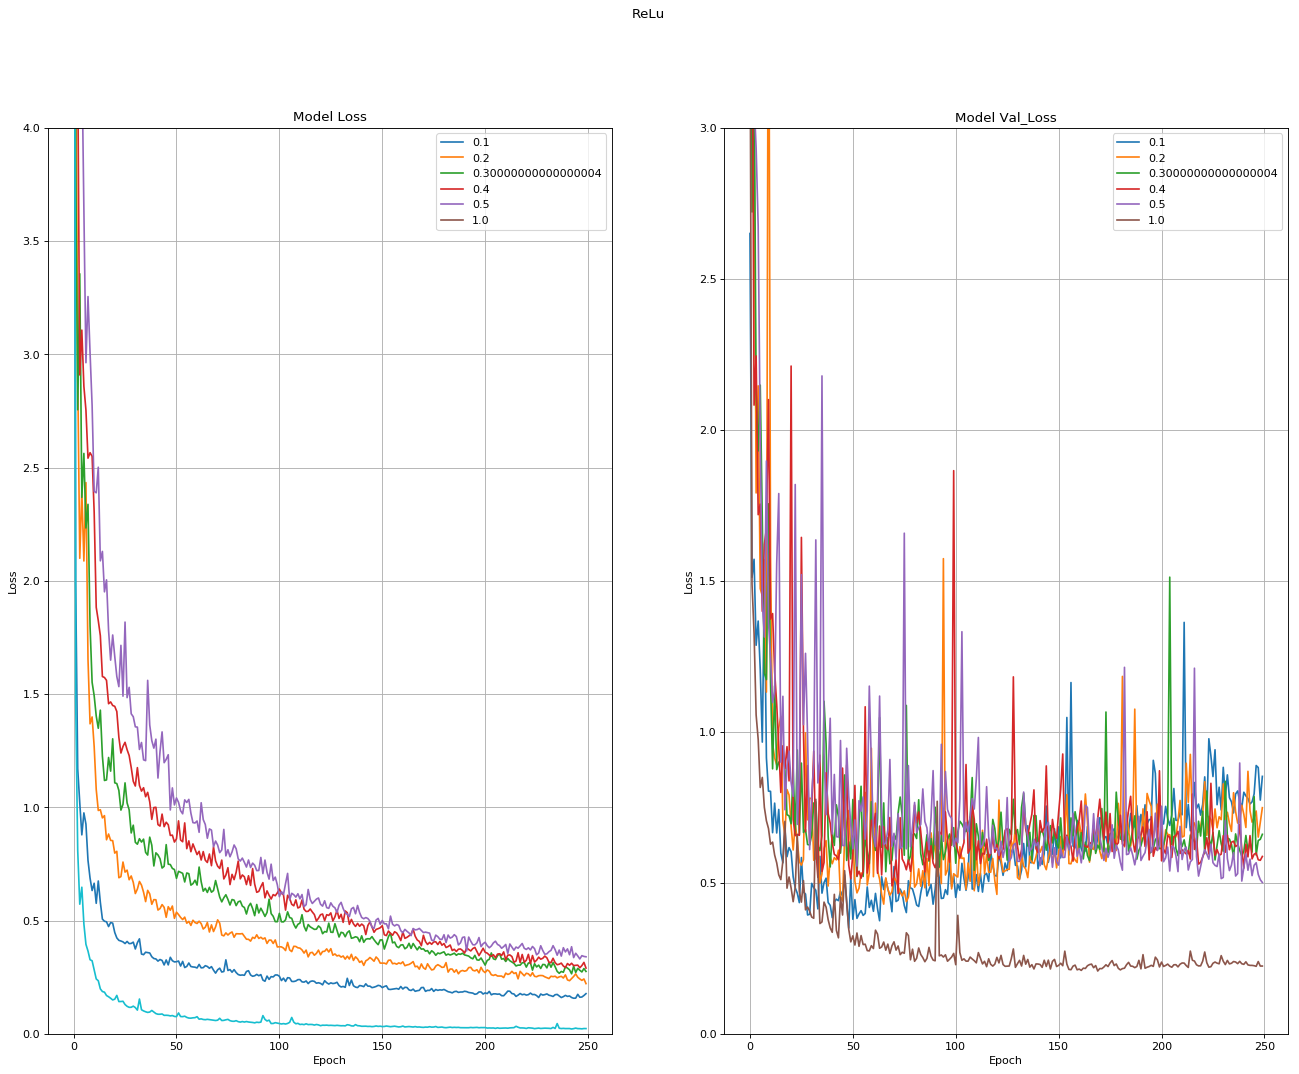

In [178]:
plt.figure(figsize=(20, 15), dpi=80, facecolor='w', edgecolor='b')
plt.subplot(1, 2, 1)
plt.suptitle("ReLu")

for i in range(0,10):
    if(i != 6 or i != 8 or i != 7 or i != 5):
        plt.plot(dropoutReLu[i].history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,4)
plt.grid(True)
plt.legend([str(dropoutValues[0]), dropoutValues[1], dropoutValues[2], dropoutValues[3], dropoutValues[4], dropoutValues[9]])

plt.subplot(1, 2, 2)
for i in range(0,10):
    if(i in [5,6,7,8]):
        continue
    else:
        plt.plot(dropoutReLu[i].history['val_loss'])
plt.title('Model Val_Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.grid(True)
plt.legend([str(dropoutValues[0]), dropoutValues[1], dropoutValues[2], dropoutValues[3], dropoutValues[4], dropoutValues[9]])

## 1.j

In [187]:
Xm = X_train_scaled.values
ym = y_train
kfold = KFold(n_splits=5)
rate = np.logspace(-6,0,5)
cvscores = []
print("5-fold con funcion de activacion sigmoid\n\n")
for i in range(0,4):
    aux = list()
    print("Learning rate de: " + str(rate[i]) + "\n\n")
    for (train, val) in kfold.split(Xm):
        model = Sequential()
        model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
        model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
        model.compile(optimizer=SGD(lr=rate[i]),loss='mean_squared_error')
        model.fit(Xm[train], ym[train], epochs=250, callbacks=[TerminateOnNaN()])
        scores = model.evaluate(Xm[val], ym[val])
        aux.append(scores)
    cvscores.append(aux)
mse_cv = list()
for i in range(0,4):
    mse_cv.append(np.mean(cvscores[i]))

5-fold con funcion de activacion sigmoid


Learning rate de: 1e-06


Epoch 1/250
7796/7796 [==============================] - 8s 1ms/step - loss: 127.5362
Epoch 2/250
7796/7796 [==============================] - 2s 248us/step - loss: 120.5135
Epoch 3/250
7796/7796 [==============================] - 2s 245us/step - loss: 113.9199
Epoch 4/250
7796/7796 [==============================] - 2s 247us/step - loss: 107.7289
Epoch 5/250
7796/7796 [==============================] - 2s 249us/step - loss: 101.9150
Epoch 6/250
7796/7796 [==============================] - 2s 247us/step - loss: 96.4545
Epoch 7/250
7796/7796 [==============================] - 2s 243us/step - loss: 91.3231
Epoch 8/250
7796/7796 [==============================] - 2s 248us/step - loss: 86.5042
Epoch 9/250
7796/7796 [==============================] - 2s 246us/step - loss: 81.9740
Epoch 10/250
7796/7796 [==============================] - 2s 245us/step - loss: 77.7155
Epoch 11/250
7796/7796 [==============================] -

7796/7796 [==============================] - 2s 245us/step - loss: 2.0380
Epoch 187/250
7796/7796 [==============================] - 2s 245us/step - loss: 2.0328
Epoch 188/250
7796/7796 [==============================] - 2s 245us/step - loss: 2.0279
Epoch 189/250
7796/7796 [==============================] - 2s 249us/step - loss: 2.0230
Epoch 190/250
7796/7796 [==============================] - 2s 251us/step - loss: 2.0182
Epoch 191/250
7796/7796 [==============================] - 2s 248us/step - loss: 2.0136
Epoch 192/250
7796/7796 [==============================] - 2s 246us/step - loss: 2.0090
Epoch 193/250
7796/7796 [==============================] - 2s 244us/step - loss: 2.0046
Epoch 194/250
7796/7796 [==============================] - 2s 242us/step - loss: 2.0002
Epoch 195/250
7796/7796 [==============================] - 2s 247us/step - loss: 1.9960
Epoch 196/250
7796/7796 [==============================] - 2s 245us/step - loss: 1.9918
Epoch 197/250
7796/7796 [=====================

7796/7796 [==============================] - 2s 251us/step - loss: 3.2370
Epoch 122/250
7796/7796 [==============================] - 2s 249us/step - loss: 3.2009
Epoch 123/250
7796/7796 [==============================] - 2s 251us/step - loss: 3.1657
Epoch 124/250
7796/7796 [==============================] - 2s 248us/step - loss: 3.1316
Epoch 125/250
7796/7796 [==============================] - 2s 247us/step - loss: 3.0985
Epoch 126/250
7796/7796 [==============================] - 2s 247us/step - loss: 3.0663
Epoch 127/250
7796/7796 [==============================] - 2s 248us/step - loss: 3.0349
Epoch 128/250
7796/7796 [==============================] - 2s 247us/step - loss: 3.0045
Epoch 129/250
7796/7796 [==============================] - 2s 249us/step - loss: 2.9750
Epoch 130/250
7796/7796 [==============================] - 2s 246us/step - loss: 2.9462
Epoch 131/250
7796/7796 [==============================] - 2s 247us/step - loss: 2.9182
Epoch 132/250
7796/7796 [=====================

7796/7796 [==============================] - 2s 248us/step - loss: 11.5174
Epoch 57/250
7796/7796 [==============================] - 2s 248us/step - loss: 11.1458
Epoch 58/250
7796/7796 [==============================] - 2s 250us/step - loss: 10.7904
Epoch 59/250
7796/7796 [==============================] - 2s 252us/step - loss: 10.4499
Epoch 60/250
7796/7796 [==============================] - 2s 248us/step - loss: 10.1241
Epoch 61/250
7796/7796 [==============================] - 2s 249us/step - loss: 9.8115
Epoch 62/250
7796/7796 [==============================] - 2s 250us/step - loss: 9.5124
Epoch 63/250
7796/7796 [==============================] - 2s 246us/step - loss: 9.2255
Epoch 64/250
7796/7796 [==============================] - 2s 248us/step - loss: 8.9506
Epoch 65/250
7796/7796 [==============================] - 2s 246us/step - loss: 8.6867
Epoch 66/250
7796/7796 [==============================] - 2s 247us/step - loss: 8.4332
Epoch 67/250
7796/7796 [===========================

7796/7796 [==============================] - 2s 246us/step - loss: 1.5849
Epoch 243/250
7796/7796 [==============================] - 2s 250us/step - loss: 1.5831
Epoch 244/250
7796/7796 [==============================] - 2s 251us/step - loss: 1.5814
Epoch 245/250
7796/7796 [==============================] - 2s 250us/step - loss: 1.5798
Epoch 246/250
7796/7796 [==============================] - 2s 248us/step - loss: 1.5781
Epoch 247/250
7796/7796 [==============================] - 2s 246us/step - loss: 1.5765
Epoch 248/250
7796/7796 [==============================] - 2s 247us/step - loss: 1.5749
Epoch 249/250
7796/7796 [==============================] - 2s 250us/step - loss: 1.5734
Epoch 250/250
1949/1949 [==============================] - 3s 2ms/step
Epoch 1/250
7796/7796 [==============================] - 8s 1ms/step - loss: 140.7219
Epoch 2/250
7796/7796 [==============================] - 2s 247us/step - loss: 132.8962
Epoch 3/250
7796/7796 [==============================] - 2s 250us

Epoch 85/250
7796/7796 [==============================] - 2s 246us/step - loss: 4.0980
Epoch 86/250
7796/7796 [==============================] - 2s 248us/step - loss: 4.0063
Epoch 87/250
7796/7796 [==============================] - 2s 249us/step - loss: 3.9185
Epoch 88/250
7796/7796 [==============================] - 2s 247us/step - loss: 3.8348
Epoch 89/250
7796/7796 [==============================] - 2s 245us/step - loss: 3.7548
Epoch 90/250
7796/7796 [==============================] - 2s 247us/step - loss: 3.6783
Epoch 91/250
7796/7796 [==============================] - 2s 247us/step - loss: 3.6053
Epoch 92/250
7796/7796 [==============================] - 2s 251us/step - loss: 3.5354
Epoch 93/250
7796/7796 [==============================] - 2s 244us/step - loss: 3.4686
Epoch 94/250
7796/7796 [==============================] - 2s 249us/step - loss: 3.4047
Epoch 95/250
7796/7796 [==============================] - 2s 245us/step - loss: 3.3435
Epoch 96/250
7796/7796 [===================

7796/7796 [==============================] - 2s 250us/step - loss: 49.1780
Epoch 21/250
7796/7796 [==============================] - 2s 247us/step - loss: 46.7181
Epoch 22/250
7796/7796 [==============================] - 2s 247us/step - loss: 44.3966
Epoch 23/250
7796/7796 [==============================] - 2s 250us/step - loss: 42.2048
Epoch 24/250
7796/7796 [==============================] - 2s 250us/step - loss: 40.1347
Epoch 25/250
7796/7796 [==============================] - 2s 253us/step - loss: 38.1786
Epoch 26/250
7796/7796 [==============================] - 2s 248us/step - loss: 36.3311
Epoch 27/250
7796/7796 [==============================] - 2s 248us/step - loss: 34.5841
Epoch 28/250
7796/7796 [==============================] - 2s 251us/step - loss: 32.9317
Epoch 29/250
7796/7796 [==============================] - 2s 251us/step - loss: 31.3691
Epoch 30/250
7796/7796 [==============================] - 2s 246us/step - loss: 29.8906
Epoch 31/250
7796/7796 [=====================

7796/7796 [==============================] - 2s 248us/step - loss: 1.8496
Epoch 207/250
7796/7796 [==============================] - 2s 246us/step - loss: 1.8474
Epoch 208/250
7796/7796 [==============================] - 2s 248us/step - loss: 1.8453
Epoch 209/250
7796/7796 [==============================] - 2s 250us/step - loss: 1.8432
Epoch 210/250
7796/7796 [==============================] - 2s 248us/step - loss: 1.8411
Epoch 211/250
7796/7796 [==============================] - 2s 247us/step - loss: 1.8391
Epoch 212/250
7796/7796 [==============================] - 2s 248us/step - loss: 1.8371
Epoch 213/250
7796/7796 [==============================] - 2s 249us/step - loss: 1.8352
Epoch 214/250
7796/7796 [==============================] - 2s 249us/step - loss: 1.8332
Epoch 215/250
7796/7796 [==============================] - 2s 250us/step - loss: 1.8313
Epoch 216/250
7796/7796 [==============================] - 2s 250us/step - loss: 1.8294
Epoch 217/250
7796/7796 [=====================

7796/7796 [==============================] - 2s 249us/step - loss: 0.8901
Epoch 142/250
7796/7796 [==============================] - 2s 250us/step - loss: 0.8879
Epoch 143/250
7796/7796 [==============================] - 2s 251us/step - loss: 0.8857
Epoch 144/250
7796/7796 [==============================] - 2s 250us/step - loss: 0.8836
Epoch 145/250
7796/7796 [==============================] - 2s 248us/step - loss: 0.8815
Epoch 146/250
7796/7796 [==============================] - 2s 249us/step - loss: 0.8794
Epoch 147/250
7796/7796 [==============================] - 2s 246us/step - loss: 0.8773
Epoch 148/250
7796/7796 [==============================] - 2s 249us/step - loss: 0.8752
Epoch 149/250
7796/7796 [==============================] - 2s 248us/step - loss: 0.8732
Epoch 150/250
7796/7796 [==============================] - 2s 248us/step - loss: 0.8712
Epoch 151/250
7796/7796 [==============================] - 2s 250us/step - loss: 0.8692
Epoch 152/250
7796/7796 [=====================

7796/7796 [==============================] - 2s 248us/step - loss: 1.1513
Epoch 78/250
7796/7796 [==============================] - 2s 249us/step - loss: 1.1462
Epoch 79/250
7796/7796 [==============================] - 2s 250us/step - loss: 1.1412
Epoch 80/250
7796/7796 [==============================] - 2s 252us/step - loss: 1.1363
Epoch 81/250
7796/7796 [==============================] - 2s 248us/step - loss: 1.1315
Epoch 82/250
7796/7796 [==============================] - 2s 247us/step - loss: 1.1267
Epoch 83/250
7796/7796 [==============================] - 2s 247us/step - loss: 1.1221
Epoch 84/250
7796/7796 [==============================] - 2s 250us/step - loss: 1.1174
Epoch 85/250
7796/7796 [==============================] - 2s 247us/step - loss: 1.1128
Epoch 86/250
7796/7796 [==============================] - 2s 248us/step - loss: 1.1084
Epoch 87/250
7796/7796 [==============================] - 2s 248us/step - loss: 1.1039
Epoch 88/250
7796/7796 [==============================] 

7796/7796 [==============================] - 2s 250us/step - loss: 1.5338
Epoch 13/250
7796/7796 [==============================] - 2s 251us/step - loss: 1.5120
Epoch 14/250
7796/7796 [==============================] - 2s 253us/step - loss: 1.4915
Epoch 15/250
7796/7796 [==============================] - 2s 250us/step - loss: 1.4722
Epoch 16/250
7796/7796 [==============================] - 2s 251us/step - loss: 1.4538
Epoch 17/250
7796/7796 [==============================] - 2s 250us/step - loss: 1.4361
Epoch 18/250
7796/7796 [==============================] - 2s 248us/step - loss: 1.4190
Epoch 19/250
7796/7796 [==============================] - 2s 249us/step - loss: 1.4027
Epoch 20/250
7796/7796 [==============================] - 2s 247us/step - loss: 1.3868
Epoch 21/250
7796/7796 [==============================] - 2s 250us/step - loss: 1.3714
Epoch 22/250
7796/7796 [==============================] - 2s 251us/step - loss: 1.3565
Epoch 23/250
7796/7796 [==============================] 

7796/7796 [==============================] - 2s 250us/step - loss: 0.6438
Epoch 200/250
7796/7796 [==============================] - 2s 251us/step - loss: 0.6427
Epoch 201/250
7796/7796 [==============================] - 2s 251us/step - loss: 0.6417
Epoch 202/250
7796/7796 [==============================] - 2s 247us/step - loss: 0.6407
Epoch 203/250
7796/7796 [==============================] - 2s 247us/step - loss: 0.6396
Epoch 204/250
7796/7796 [==============================] - 2s 250us/step - loss: 0.6386
Epoch 205/250
7796/7796 [==============================] - 2s 252us/step - loss: 0.6376
Epoch 206/250
7796/7796 [==============================] - 2s 248us/step - loss: 0.6366
Epoch 207/250
7796/7796 [==============================] - 2s 252us/step - loss: 0.6356
Epoch 208/250
7796/7796 [==============================] - 2s 240us/step - loss: 0.6346
Epoch 209/250
7796/7796 [==============================] - 2s 251us/step - loss: 0.6336
Epoch 210/250
7796/7796 [=====================

7796/7796 [==============================] - 2s 248us/step - loss: 0.8391
Epoch 136/250
7796/7796 [==============================] - 2s 251us/step - loss: 0.8371
Epoch 137/250
7796/7796 [==============================] - 2s 247us/step - loss: 0.8350
Epoch 138/250
7796/7796 [==============================] - 2s 250us/step - loss: 0.8330
Epoch 139/250
7796/7796 [==============================] - 2s 250us/step - loss: 0.8310
Epoch 140/250
7796/7796 [==============================] - 2s 249us/step - loss: 0.8289
Epoch 141/250
7796/7796 [==============================] - 2s 247us/step - loss: 0.8270
Epoch 142/250
7796/7796 [==============================] - 2s 251us/step - loss: 0.8250
Epoch 143/250
7796/7796 [==============================] - 2s 248us/step - loss: 0.8231
Epoch 144/250
7796/7796 [==============================] - 2s 248us/step - loss: 0.8212
Epoch 145/250
7796/7796 [==============================] - 2s 248us/step - loss: 0.8192
Epoch 146/250
7796/7796 [=====================

7796/7796 [==============================] - 2s 249us/step - loss: 1.0668
Epoch 72/250
7796/7796 [==============================] - 2s 249us/step - loss: 1.0617
Epoch 73/250
7796/7796 [==============================] - 2s 248us/step - loss: 1.0566
Epoch 74/250
7796/7796 [==============================] - 2s 252us/step - loss: 1.0517
Epoch 75/250
7796/7796 [==============================] - 2s 248us/step - loss: 1.0468
Epoch 76/250
7796/7796 [==============================] - 2s 248us/step - loss: 1.0420
Epoch 77/250
7796/7796 [==============================] - 2s 249us/step - loss: 1.0372
Epoch 78/250
7796/7796 [==============================] - 2s 249us/step - loss: 1.0325
Epoch 79/250
7796/7796 [==============================] - 2s 252us/step - loss: 1.0279
Epoch 80/250
7796/7796 [==============================] - 2s 249us/step - loss: 1.0233
Epoch 81/250
7796/7796 [==============================] - 2s 248us/step - loss: 1.0188
Epoch 82/250
7796/7796 [==============================] 

7796/7796 [==============================] - 2s 251us/step - loss: 0.8327
Epoch 7/250
7796/7796 [==============================] - 2s 247us/step - loss: 0.7919
Epoch 8/250
7796/7796 [==============================] - 2s 252us/step - loss: 0.7577
Epoch 9/250
7796/7796 [==============================] - 2s 251us/step - loss: 0.7314
Epoch 10/250
7796/7796 [==============================] - 2s 252us/step - loss: 0.7096
Epoch 11/250
7796/7796 [==============================] - 2s 249us/step - loss: 0.6896
Epoch 12/250
7796/7796 [==============================] - 2s 253us/step - loss: 0.6729
Epoch 13/250
7796/7796 [==============================] - 2s 249us/step - loss: 0.6573
Epoch 14/250
7796/7796 [==============================] - 2s 250us/step - loss: 0.6435
Epoch 15/250
7796/7796 [==============================] - 2s 249us/step - loss: 0.6311
Epoch 16/250
7796/7796 [==============================] - 2s 251us/step - loss: 0.6181
Epoch 17/250
7796/7796 [==============================] - 2

7796/7796 [==============================] - 2s 250us/step - loss: 0.0885
Epoch 194/250
7796/7796 [==============================] - 2s 250us/step - loss: 0.0878
Epoch 195/250
7796/7796 [==============================] - 2s 250us/step - loss: 0.0874
Epoch 196/250
7796/7796 [==============================] - 2s 249us/step - loss: 0.0868
Epoch 197/250
7796/7796 [==============================] - 2s 250us/step - loss: 0.0863
Epoch 198/250
7796/7796 [==============================] - 2s 247us/step - loss: 0.0857
Epoch 199/250
7796/7796 [==============================] - 2s 250us/step - loss: 0.0854
Epoch 200/250
7796/7796 [==============================] - 2s 248us/step - loss: 0.0848
Epoch 201/250
7796/7796 [==============================] - 2s 249us/step - loss: 0.0842
Epoch 202/250
7796/7796 [==============================] - 2s 249us/step - loss: 0.0838
Epoch 203/250
7796/7796 [==============================] - 2s 251us/step - loss: 0.0834
Epoch 204/250
7796/7796 [=====================

7796/7796 [==============================] - 2s 250us/step - loss: 0.4763
Epoch 37/250
7796/7796 [==============================] - 2s 250us/step - loss: 0.4684
Epoch 38/250
7796/7796 [==============================] - 2s 251us/step - loss: 0.4623
Epoch 39/250
7796/7796 [==============================] - 2s 252us/step - loss: 0.4558
Epoch 40/250
7796/7796 [==============================] - 2s 249us/step - loss: 0.4483
Epoch 41/250
7796/7796 [==============================] - 2s 251us/step - loss: 0.4419
Epoch 42/250
7796/7796 [==============================] - 2s 249us/step - loss: 0.4353
Epoch 43/250
7796/7796 [==============================] - 2s 250us/step - loss: 0.4289
Epoch 44/250
7796/7796 [==============================] - 2s 253us/step - loss: 0.4226
Epoch 45/250
7796/7796 [==============================] - 2s 252us/step - loss: 0.4163
Epoch 46/250
7796/7796 [==============================] - 2s 250us/step - loss: 0.4098
Epoch 47/250
7796/7796 [==============================] 

Epoch 130/250
7796/7796 [==============================] - 2s 251us/step - loss: 0.1473
Epoch 131/250
7796/7796 [==============================] - 2s 254us/step - loss: 0.1458
Epoch 132/250
7796/7796 [==============================] - 2s 245us/step - loss: 0.1444
Epoch 133/250
7796/7796 [==============================] - 2s 250us/step - loss: 0.1429
Epoch 134/250
7796/7796 [==============================] - 2s 253us/step - loss: 0.1415
Epoch 135/250
7796/7796 [==============================] - 2s 252us/step - loss: 0.1404
Epoch 136/250
7796/7796 [==============================] - 2s 249us/step - loss: 0.1389
Epoch 137/250
7796/7796 [==============================] - 2s 248us/step - loss: 0.1380
Epoch 138/250
7796/7796 [==============================] - 2s 251us/step - loss: 0.1364
Epoch 139/250
7796/7796 [==============================] - 2s 252us/step - loss: 0.1355
Epoch 140/250
7796/7796 [==============================] - 2s 250us/step - loss: 0.1340
Epoch 141/250
7796/7796 [=======

7796/7796 [==============================] - 2s 252us/step - loss: 0.0758
Epoch 224/250
7796/7796 [==============================] - 2s 251us/step - loss: 0.0754
Epoch 225/250
7796/7796 [==============================] - 2s 251us/step - loss: 0.0750
Epoch 226/250
7796/7796 [==============================] - 2s 245us/step - loss: 0.0746
Epoch 227/250
7796/7796 [==============================] - 2s 251us/step - loss: 0.0742
Epoch 228/250
7796/7796 [==============================] - 2s 253us/step - loss: 0.0738
Epoch 229/250
7796/7796 [==============================] - 2s 251us/step - loss: 0.0733
Epoch 230/250
7796/7796 [==============================] - 2s 251us/step - loss: 0.0732
Epoch 231/250
7796/7796 [==============================] - 2s 250us/step - loss: 0.0727
Epoch 232/250
7796/7796 [==============================] - 2s 253us/step - loss: 0.0725
Epoch 233/250
7796/7796 [==============================] - 2s 247us/step - loss: 0.0721
Epoch 234/250
7796/7796 [=====================

7796/7796 [==============================] - 2s 246us/step - loss: 0.1200
Epoch 160/250
7796/7796 [==============================] - 2s 254us/step - loss: 0.1193
Epoch 161/250
7796/7796 [==============================] - 2s 251us/step - loss: 0.1186
Epoch 162/250
7796/7796 [==============================] - 2s 248us/step - loss: 0.1177
Epoch 163/250
7796/7796 [==============================] - 2s 251us/step - loss: 0.1170
Epoch 164/250
7796/7796 [==============================] - 2s 254us/step - loss: 0.1159
Epoch 165/250
7796/7796 [==============================] - 2s 255us/step - loss: 0.1148
Epoch 166/250
7796/7796 [==============================] - 2s 251us/step - loss: 0.1144
Epoch 167/250
7796/7796 [==============================] - 2s 253us/step - loss: 0.1133
Epoch 168/250
7796/7796 [==============================] - 2s 254us/step - loss: 0.1128
Epoch 169/250
7796/7796 [==============================] - 2s 254us/step - loss: 0.1121
Epoch 170/250
7796/7796 [=====================

7796/7796 [==============================] - 2s 250us/step - loss: 0.2360
Epoch 96/250
7796/7796 [==============================] - 2s 249us/step - loss: 0.2340
Epoch 97/250
7796/7796 [==============================] - 2s 248us/step - loss: 0.2317
Epoch 98/250
7796/7796 [==============================] - 2s 252us/step - loss: 0.2291
Epoch 99/250
7796/7796 [==============================] - 2s 251us/step - loss: 0.2266
Epoch 100/250
7796/7796 [==============================] - 2s 253us/step - loss: 0.2243
Epoch 101/250
7796/7796 [==============================] - 2s 252us/step - loss: 0.2217
Epoch 102/250
7796/7796 [==============================] - 2s 252us/step - loss: 0.2190
Epoch 103/250
7796/7796 [==============================] - 2s 253us/step - loss: 0.2162
Epoch 104/250
7796/7796 [==============================] - 2s 252us/step - loss: 0.2146
Epoch 105/250
7796/7796 [==============================] - 2s 254us/step - loss: 0.2124
Epoch 106/250
7796/7796 [=========================

7796/7796 [==============================] - 2s 251us/step - loss: 0.4822
Epoch 32/250
7796/7796 [==============================] - 2s 254us/step - loss: 0.4769
Epoch 33/250
7796/7796 [==============================] - 2s 250us/step - loss: 0.4711
Epoch 34/250
7796/7796 [==============================] - 2s 253us/step - loss: 0.4665
Epoch 35/250
7796/7796 [==============================] - 2s 251us/step - loss: 0.4615
Epoch 36/250
7796/7796 [==============================] - 2s 252us/step - loss: 0.4573
Epoch 37/250
7796/7796 [==============================] - 2s 254us/step - loss: 0.4516
Epoch 38/250
7796/7796 [==============================] - 2s 253us/step - loss: 0.4472
Epoch 39/250
7796/7796 [==============================] - 2s 255us/step - loss: 0.4414
Epoch 40/250
7796/7796 [==============================] - 2s 248us/step - loss: 0.4378
Epoch 41/250
7796/7796 [==============================] - 2s 253us/step - loss: 0.4331
Epoch 42/250
7796/7796 [==============================] 

7796/7796 [==============================] - 2s 252us/step - loss: 0.1635
Epoch 126/250
7796/7796 [==============================] - 2s 252us/step - loss: 0.1619
Epoch 127/250
7796/7796 [==============================] - 2s 253us/step - loss: 0.1603
Epoch 128/250
7796/7796 [==============================] - 2s 252us/step - loss: 0.1582
Epoch 129/250
7796/7796 [==============================] - 2s 254us/step - loss: 0.1567
Epoch 130/250
7796/7796 [==============================] - 2s 251us/step - loss: 0.1548
Epoch 131/250
7796/7796 [==============================] - 2s 252us/step - loss: 0.1533
Epoch 132/250
7796/7796 [==============================] - 2s 251us/step - loss: 0.1513
Epoch 133/250
7796/7796 [==============================] - 2s 253us/step - loss: 0.1501
Epoch 134/250
7796/7796 [==============================] - 2s 255us/step - loss: 0.1486
Epoch 135/250
7796/7796 [==============================] - 2s 249us/step - loss: 0.1472
Epoch 136/250
7796/7796 [=====================

In [191]:
kfold = KFold(n_splits=5)
cvscores5ReLu = []
print("5-fold con funcion de activacion ReLu\n\n")
for i in range(0,4):
    aux = list()
    print("Learning rate de: " + str(rate[i]) + "\n\n")
    for (train, val) in kfold.split(Xm):
        model = Sequential()
        model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
        model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
        model.compile(optimizer=SGD(lr=rate[i]),loss='mean_squared_error')
        model.fit(Xm[train], ym[train], epochs=250, callbacks=[TerminateOnNaN()])
        scores = model.evaluate(Xm[val], ym[val])
        aux.append(scores)
    cvscores5ReLu.append(aux)
mse_cv5ReLu = list()
for i in range(0,4):
    mse_cv5ReLu.append(np.mean(cvscores5ReLu[i]))

5-fold con funcion de activacion ReLu


Learning rate de: 1e-06


Epoch 1/250
7796/7796 [==============================] - 9s 1ms/step - loss: 130.6613
Epoch 2/250
7796/7796 [==============================] - 2s 264us/step - loss: 124.9499
Epoch 3/250
7796/7796 [==============================] - 2s 264us/step - loss: 119.7002
Epoch 4/250
7796/7796 [==============================] - 2s 263us/step - loss: 114.8333
Epoch 5/250
7796/7796 [==============================] - 2s 267us/step - loss: 110.2757
Epoch 6/250
7796/7796 [==============================] - 2s 263us/step - loss: 106.0014
Epoch 7/250
7796/7796 [==============================] - 2s 262us/step - loss: 101.9810
Epoch 8/250
7796/7796 [==============================] - 2s 265us/step - loss: 98.2103
Epoch 9/250
7796/7796 [==============================] - 2s 268us/step - loss: 94.6684
Epoch 10/250
7796/7796 [==============================] - 2s 266us/step - loss: 91.3390
Epoch 11/250
7796/7796 [==============================] - 

7796/7796 [==============================] - 2s 263us/step - loss: 9.0438
Epoch 186/250
7796/7796 [==============================] - 2s 266us/step - loss: 8.9983
Epoch 187/250
7796/7796 [==============================] - 2s 264us/step - loss: 8.9537
Epoch 188/250
7796/7796 [==============================] - 2s 263us/step - loss: 8.9092
Epoch 189/250
7796/7796 [==============================] - 2s 263us/step - loss: 8.8648
Epoch 190/250
7796/7796 [==============================] - 2s 268us/step - loss: 8.8210
Epoch 191/250
7796/7796 [==============================] - 2s 266us/step - loss: 8.7774
Epoch 192/250
7796/7796 [==============================] - 2s 272us/step - loss: 8.7337
Epoch 193/250
7796/7796 [==============================] - 2s 266us/step - loss: 8.6907
Epoch 194/250
7796/7796 [==============================] - 2s 268us/step - loss: 8.6478
Epoch 195/250
7796/7796 [==============================] - 2s 266us/step - loss: 8.6053
Epoch 196/250
7796/7796 [=====================

7796/7796 [==============================] - 2s 268us/step - loss: 12.6832
Epoch 121/250
7796/7796 [==============================] - 2s 261us/step - loss: 12.6091
Epoch 122/250
7796/7796 [==============================] - 2s 265us/step - loss: 12.5360
Epoch 123/250
7796/7796 [==============================] - 2s 262us/step - loss: 12.4638
Epoch 124/250
7796/7796 [==============================] - 2s 266us/step - loss: 12.3932
Epoch 125/250
7796/7796 [==============================] - 2s 265us/step - loss: 12.3231
Epoch 126/250
7796/7796 [==============================] - 2s 267us/step - loss: 12.2541
Epoch 127/250
7796/7796 [==============================] - 2s 261us/step - loss: 12.1859
Epoch 128/250
7796/7796 [==============================] - 2s 260us/step - loss: 12.1187
Epoch 129/250
7796/7796 [==============================] - 2s 266us/step - loss: 12.0524
Epoch 130/250
7796/7796 [==============================] - 2s 264us/step - loss: 11.9868
Epoch 131/250
7796/7796 [==========

7796/7796 [==============================] - 2s 265us/step - loss: 28.6263
Epoch 55/250
7796/7796 [==============================] - 2s 266us/step - loss: 28.0477
Epoch 56/250
7796/7796 [==============================] - 2s 256us/step - loss: 27.4945
Epoch 57/250
7796/7796 [==============================] - 2s 258us/step - loss: 26.9675
Epoch 58/250
7796/7796 [==============================] - 2s 264us/step - loss: 26.4625
Epoch 59/250
7796/7796 [==============================] - 2s 264us/step - loss: 25.9783
Epoch 60/250
7796/7796 [==============================] - 2s 264us/step - loss: 25.5151
Epoch 61/250
7796/7796 [==============================] - 2s 266us/step - loss: 25.0691
Epoch 62/250
7796/7796 [==============================] - 2s 263us/step - loss: 24.6418
Epoch 63/250
7796/7796 [==============================] - 2s 260us/step - loss: 24.2308
Epoch 64/250
7796/7796 [==============================] - 2s 266us/step - loss: 23.8348
Epoch 65/250
7796/7796 [=====================

7796/7796 [==============================] - 2s 266us/step - loss: 6.6435
Epoch 240/250
7796/7796 [==============================] - 2s 264us/step - loss: 6.6092
Epoch 241/250
7796/7796 [==============================] - 2s 266us/step - loss: 6.5756
Epoch 242/250
7796/7796 [==============================] - 2s 264us/step - loss: 6.5417
Epoch 243/250
7796/7796 [==============================] - 2s 265us/step - loss: 6.5083
Epoch 244/250
7796/7796 [==============================] - 2s 264us/step - loss: 6.4750
Epoch 245/250
7796/7796 [==============================] - 2s 263us/step - loss: 6.4420
Epoch 246/250
7796/7796 [==============================] - 2s 263us/step - loss: 6.4094
Epoch 247/250
7796/7796 [==============================] - 2s 261us/step - loss: 6.3767
Epoch 248/250
7796/7796 [==============================] - 2s 263us/step - loss: 6.3448
Epoch 249/250
7796/7796 [==============================] - 2s 263us/step - loss: 6.3127
Epoch 250/250
1949/1949 [=====================

7796/7796 [==============================] - 2s 267us/step - loss: 8.8172
Epoch 174/250
7796/7796 [==============================] - 2s 262us/step - loss: 8.7702
Epoch 175/250
7796/7796 [==============================] - 2s 263us/step - loss: 8.7237
Epoch 176/250
7796/7796 [==============================] - 2s 264us/step - loss: 8.6774
Epoch 177/250
7796/7796 [==============================] - 2s 265us/step - loss: 8.6315
Epoch 178/250
7796/7796 [==============================] - 2s 264us/step - loss: 8.5856
Epoch 179/250
7796/7796 [==============================] - 2s 266us/step - loss: 8.5402
Epoch 180/250
7796/7796 [==============================] - 2s 265us/step - loss: 8.4952
Epoch 181/250
7796/7796 [==============================] - 2s 265us/step - loss: 8.4503
Epoch 182/250
7796/7796 [==============================] - 2s 264us/step - loss: 8.4058
Epoch 183/250
7796/7796 [==============================] - 2s 265us/step - loss: 8.3615
Epoch 184/250
7796/7796 [=====================

7796/7796 [==============================] - 2s 263us/step - loss: 13.2857
Epoch 109/250
7796/7796 [==============================] - 2s 266us/step - loss: 13.1916
Epoch 110/250
7796/7796 [==============================] - 2s 267us/step - loss: 13.0988
Epoch 111/250
7796/7796 [==============================] - 2s 264us/step - loss: 13.0080
Epoch 112/250
7796/7796 [==============================] - 2s 266us/step - loss: 12.9192
Epoch 113/250
7796/7796 [==============================] - 2s 264us/step - loss: 12.8313
Epoch 114/250
7796/7796 [==============================] - 2s 266us/step - loss: 12.7455
Epoch 115/250
7796/7796 [==============================] - 2s 263us/step - loss: 12.6607
Epoch 116/250
7796/7796 [==============================] - 2s 265us/step - loss: 12.5770
Epoch 117/250
7796/7796 [==============================] - 2s 263us/step - loss: 12.4952
Epoch 118/250
7796/7796 [==============================] - 2s 264us/step - loss: 12.4139
Epoch 119/250
7796/7796 [==========

7796/7796 [==============================] - 2s 267us/step - loss: 0.9839
Epoch 43/250
7796/7796 [==============================] - 2s 266us/step - loss: 0.9650
Epoch 44/250
7796/7796 [==============================] - 2s 265us/step - loss: 0.9468
Epoch 45/250
7796/7796 [==============================] - 2s 266us/step - loss: 0.9305
Epoch 46/250
7796/7796 [==============================] - 2s 263us/step - loss: 0.9139
Epoch 47/250
7796/7796 [==============================] - 2s 264us/step - loss: 0.8992
Epoch 48/250
7796/7796 [==============================] - 2s 265us/step - loss: 0.8833
Epoch 49/250
7796/7796 [==============================] - 2s 267us/step - loss: 0.8701
Epoch 50/250
7796/7796 [==============================] - 2s 269us/step - loss: 0.8549
Epoch 51/250
7796/7796 [==============================] - 2s 268us/step - loss: 0.8434
Epoch 52/250
7796/7796 [==============================] - 2s 263us/step - loss: 0.8299
Epoch 53/250
7796/7796 [==============================] 

7796/7796 [==============================] - 2s 265us/step - loss: 0.2576
Epoch 229/250
7796/7796 [==============================] - 2s 267us/step - loss: 0.2568
Epoch 230/250
7796/7796 [==============================] - 2s 270us/step - loss: 0.2559
Epoch 231/250
7796/7796 [==============================] - 2s 264us/step - loss: 0.2552
Epoch 232/250
7796/7796 [==============================] - 2s 264us/step - loss: 0.2539
Epoch 233/250
7796/7796 [==============================] - 2s 265us/step - loss: 0.2527
Epoch 234/250
7796/7796 [==============================] - 2s 266us/step - loss: 0.2516
Epoch 235/250
7796/7796 [==============================] - 2s 262us/step - loss: 0.2508
Epoch 236/250
7796/7796 [==============================] - 2s 262us/step - loss: 0.2496
Epoch 237/250
7796/7796 [==============================] - 2s 267us/step - loss: 0.2491
Epoch 238/250
7796/7796 [==============================] - 2s 264us/step - loss: 0.2479
Epoch 239/250
7796/7796 [=====================

7796/7796 [==============================] - 2s 262us/step - loss: 0.3733
Epoch 165/250
7796/7796 [==============================] - 2s 267us/step - loss: 0.3713
Epoch 166/250
7796/7796 [==============================] - 2s 264us/step - loss: 0.3697
Epoch 167/250
7796/7796 [==============================] - 2s 266us/step - loss: 0.3683
Epoch 168/250
7796/7796 [==============================] - 2s 265us/step - loss: 0.3662
Epoch 169/250
7796/7796 [==============================] - 2s 263us/step - loss: 0.3648
Epoch 170/250
7796/7796 [==============================] - 2s 263us/step - loss: 0.3635
Epoch 171/250
7796/7796 [==============================] - 2s 266us/step - loss: 0.3611
Epoch 172/250
7796/7796 [==============================] - 2s 266us/step - loss: 0.3601
Epoch 173/250
7796/7796 [==============================] - 2s 262us/step - loss: 0.3584
Epoch 174/250
7796/7796 [==============================] - 2s 266us/step - loss: 0.3567
Epoch 175/250
7796/7796 [=====================

7796/7796 [==============================] - 2s 264us/step - loss: 0.4842
Epoch 101/250
7796/7796 [==============================] - 2s 264us/step - loss: 0.4818
Epoch 102/250
7796/7796 [==============================] - 2s 264us/step - loss: 0.4782
Epoch 103/250
7796/7796 [==============================] - 2s 267us/step - loss: 0.4756
Epoch 104/250
7796/7796 [==============================] - 2s 262us/step - loss: 0.4713
Epoch 105/250
7796/7796 [==============================] - 2s 267us/step - loss: 0.4690
Epoch 106/250
7796/7796 [==============================] - 2s 264us/step - loss: 0.4659
Epoch 107/250
7796/7796 [==============================] - 2s 267us/step - loss: 0.4609
Epoch 108/250
7796/7796 [==============================] - 2s 263us/step - loss: 0.4602
Epoch 109/250
7796/7796 [==============================] - 2s 268us/step - loss: 0.4572
Epoch 110/250
7796/7796 [==============================] - 2s 270us/step - loss: 0.4520
Epoch 111/250
7796/7796 [=====================

7796/7796 [==============================] - 2s 267us/step - loss: 1.1530
Epoch 37/250
7796/7796 [==============================] - 2s 264us/step - loss: 1.1256
Epoch 38/250
7796/7796 [==============================] - 2s 266us/step - loss: 1.1048
Epoch 39/250
7796/7796 [==============================] - 2s 266us/step - loss: 1.0819
Epoch 40/250
7796/7796 [==============================] - 2s 267us/step - loss: 1.0649
Epoch 41/250
7796/7796 [==============================] - 2s 269us/step - loss: 1.0415
Epoch 42/250
7796/7796 [==============================] - 2s 268us/step - loss: 1.0262
Epoch 43/250
7796/7796 [==============================] - 2s 267us/step - loss: 1.0091
Epoch 44/250
7796/7796 [==============================] - 2s 267us/step - loss: 0.9899
Epoch 45/250
7796/7796 [==============================] - 2s 264us/step - loss: 0.9739
Epoch 46/250
7796/7796 [==============================] - 2s 264us/step - loss: 0.9572
Epoch 47/250
7796/7796 [==============================] 

Epoch 130/250
7796/7796 [==============================] - 2s 264us/step - loss: 0.4362
Epoch 131/250
7796/7796 [==============================] - 2s 266us/step - loss: 0.4339
Epoch 132/250
7796/7796 [==============================] - 2s 265us/step - loss: 0.4321
Epoch 133/250
7796/7796 [==============================] - 2s 269us/step - loss: 0.4293
Epoch 134/250
7796/7796 [==============================] - 2s 265us/step - loss: 0.4270
Epoch 135/250
7796/7796 [==============================] - 2s 264us/step - loss: 0.4242
Epoch 136/250
7796/7796 [==============================] - 2s 264us/step - loss: 0.4220
Epoch 137/250
7796/7796 [==============================] - 2s 266us/step - loss: 0.4196
Epoch 138/250
7796/7796 [==============================] - 2s 268us/step - loss: 0.4165
Epoch 139/250
7796/7796 [==============================] - 2s 267us/step - loss: 0.4147
Epoch 140/250
7796/7796 [==============================] - 2s 267us/step - loss: 0.4125
Epoch 141/250
7796/7796 [=======

7796/7796 [==============================] - 2s 265us/step - loss: 0.2878
Epoch 224/250
7796/7796 [==============================] - 2s 263us/step - loss: 0.2873
Epoch 225/250
7796/7796 [==============================] - 2s 267us/step - loss: 0.2854
Epoch 226/250
7796/7796 [==============================] - 2s 267us/step - loss: 0.2842
Epoch 227/250
7796/7796 [==============================] - 2s 266us/step - loss: 0.2835
Epoch 228/250
7796/7796 [==============================] - 2s 266us/step - loss: 0.2825
Epoch 229/250
7796/7796 [==============================] - 2s 268us/step - loss: 0.2819
Epoch 230/250
7796/7796 [==============================] - 2s 267us/step - loss: 0.2803
Epoch 231/250
7796/7796 [==============================] - 2s 267us/step - loss: 0.2799
Epoch 232/250
7796/7796 [==============================] - 2s 267us/step - loss: 0.2784
Epoch 233/250
7796/7796 [==============================] - 2s 266us/step - loss: 0.2778
Epoch 234/250
7796/7796 [=====================

7796/7796 [==============================] - 2s 266us/step - loss: 0.3937
Epoch 160/250
7796/7796 [==============================] - 2s 267us/step - loss: 0.3911
Epoch 161/250
7796/7796 [==============================] - 2s 268us/step - loss: 0.3889
Epoch 162/250
7796/7796 [==============================] - 2s 270us/step - loss: 0.3866
Epoch 163/250
7796/7796 [==============================] - 2s 270us/step - loss: 0.3850
Epoch 164/250
7796/7796 [==============================] - 2s 264us/step - loss: 0.3825
Epoch 165/250
7796/7796 [==============================] - 2s 269us/step - loss: 0.3805
Epoch 166/250
7796/7796 [==============================] - 2s 270us/step - loss: 0.3800
Epoch 167/250
7796/7796 [==============================] - 2s 267us/step - loss: 0.3771
Epoch 168/250
7796/7796 [==============================] - 2s 267us/step - loss: 0.3756
Epoch 169/250
7796/7796 [==============================] - 2s 268us/step - loss: 0.3736
Epoch 170/250
7796/7796 [=====================

7796/7796 [==============================] - 2s 267us/step - loss: 0.0500
Epoch 96/250
7796/7796 [==============================] - 2s 266us/step - loss: 0.0538
Epoch 97/250
7796/7796 [==============================] - 2s 268us/step - loss: 0.0481
Epoch 98/250
7796/7796 [==============================] - 2s 268us/step - loss: 0.0544
Epoch 99/250
7796/7796 [==============================] - 2s 270us/step - loss: 0.0529
Epoch 100/250
7796/7796 [==============================] - 2s 270us/step - loss: 0.0490
Epoch 101/250
7796/7796 [==============================] - 2s 268us/step - loss: 0.0510
Epoch 102/250
7796/7796 [==============================] - 2s 269us/step - loss: 0.0458
Epoch 103/250
7796/7796 [==============================] - 2s 264us/step - loss: 0.0476
Epoch 104/250
7796/7796 [==============================] - 2s 268us/step - loss: 0.0457
Epoch 105/250
7796/7796 [==============================] - 2s 266us/step - loss: 0.0446
Epoch 106/250
7796/7796 [=========================

7796/7796 [==============================] - 2s 266us/step - loss: 0.1575
Epoch 32/250
7796/7796 [==============================] - 2s 269us/step - loss: 0.2135
Epoch 33/250
7796/7796 [==============================] - 2s 268us/step - loss: 0.1253
Epoch 34/250
7796/7796 [==============================] - 2s 266us/step - loss: 0.1266
Epoch 35/250
7796/7796 [==============================] - 2s 270us/step - loss: 0.1430
Epoch 36/250
7796/7796 [==============================] - 2s 267us/step - loss: 0.1400
Epoch 37/250
7796/7796 [==============================] - 2s 266us/step - loss: 0.1299
Epoch 38/250
7796/7796 [==============================] - 2s 268us/step - loss: 0.1345
Epoch 39/250
7796/7796 [==============================] - 2s 269us/step - loss: 0.1150
Epoch 40/250
7796/7796 [==============================] - 2s 264us/step - loss: 0.1126
Epoch 41/250
7796/7796 [==============================] - 2s 269us/step - loss: 0.1066
Epoch 42/250
7796/7796 [==============================] 

7796/7796 [==============================] - 2s 266us/step - loss: 0.0417
Epoch 126/250
7796/7796 [==============================] - 2s 270us/step - loss: 0.0445
Epoch 127/250
7796/7796 [==============================] - 2s 270us/step - loss: 0.0409
Epoch 128/250
7796/7796 [==============================] - 2s 270us/step - loss: 0.0407
Epoch 129/250
7796/7796 [==============================] - 2s 269us/step - loss: 0.0399
Epoch 130/250
7796/7796 [==============================] - 2s 268us/step - loss: 0.0413
Epoch 131/250
7796/7796 [==============================] - 2s 266us/step - loss: 0.0408
Epoch 132/250
7796/7796 [==============================] - 2s 270us/step - loss: 0.0381
Epoch 133/250
7796/7796 [==============================] - 2s 268us/step - loss: 0.0406
Epoch 134/250
7796/7796 [==============================] - 2s 269us/step - loss: 0.0391
Epoch 135/250
7796/7796 [==============================] - 2s 267us/step - loss: 0.0391
Epoch 136/250
7796/7796 [=====================

7796/7796 [==============================] - 2s 265us/step - loss: 0.0673
Epoch 62/250
7796/7796 [==============================] - 2s 263us/step - loss: 0.0683
Epoch 63/250
7796/7796 [==============================] - 2s 268us/step - loss: 0.0713
Epoch 64/250
7796/7796 [==============================] - 2s 266us/step - loss: 0.0742
Epoch 65/250
7796/7796 [==============================] - 2s 267us/step - loss: 0.0692
Epoch 66/250
7796/7796 [==============================] - 2s 266us/step - loss: 0.0650
Epoch 67/250
7796/7796 [==============================] - 2s 263us/step - loss: 0.0608
Epoch 68/250
7796/7796 [==============================] - 2s 265us/step - loss: 0.0616
Epoch 69/250
7796/7796 [==============================] - 2s 269us/step - loss: 0.0730
Epoch 70/250
7796/7796 [==============================] - 2s 264us/step - loss: 0.0671
Epoch 71/250
7796/7796 [==============================] - 2s 267us/step - loss: 0.0613
Epoch 72/250
7796/7796 [==============================] 

7796/7796 [==============================] - 2s 266us/step - loss: 0.0239
Epoch 248/250
7796/7796 [==============================] - 2s 265us/step - loss: 0.0240
Epoch 249/250
7796/7796 [==============================] - 2s 267us/step - loss: 0.0229
Epoch 250/250
1949/1949 [==============================] - 4s 2ms/step
Epoch 1/250
7796/7796 [==============================] - 9s 1ms/step - loss: 9.9428
Epoch 2/250
7796/7796 [==============================] - 2s 271us/step - loss: 1.5518
Epoch 3/250
7796/7796 [==============================] - 2s 270us/step - loss: 0.8871
Epoch 4/250
7796/7796 [==============================] - 2s 269us/step - loss: 0.6790
Epoch 5/250
7796/7796 [==============================] - 2s 268us/step - loss: 0.5700
Epoch 6/250
7796/7796 [==============================] - 2s 269us/step - loss: 0.5219
Epoch 7/250
7796/7796 [==============================] - 2s 270us/step - loss: 0.4119
Epoch 8/250
7796/7796 [==============================] - 2s 270us/step - loss: 

7796/7796 [==============================] - 2s 271us/step - loss: 0.0331
Epoch 184/250
7796/7796 [==============================] - 2s 269us/step - loss: 0.0319
Epoch 185/250
7796/7796 [==============================] - 2s 270us/step - loss: 0.0324
Epoch 186/250
7796/7796 [==============================] - 2s 266us/step - loss: 0.0313
Epoch 187/250
7796/7796 [==============================] - 2s 267us/step - loss: 0.0325
Epoch 188/250
7796/7796 [==============================] - 2s 267us/step - loss: 0.0333
Epoch 189/250
7796/7796 [==============================] - 2s 266us/step - loss: 0.0304
Epoch 190/250
7796/7796 [==============================] - 2s 271us/step - loss: 0.0312
Epoch 191/250
7796/7796 [==============================] - 2s 269us/step - loss: 0.0303
Epoch 192/250
7796/7796 [==============================] - 2s 266us/step - loss: 0.0298
Epoch 193/250
7796/7796 [==============================] - 2s 268us/step - loss: 0.0324
Epoch 194/250
7796/7796 [=====================

7796/7796 [==============================] - 2s 265us/step - loss: 0.1440
Epoch 27/250
7796/7796 [==============================] - 2s 268us/step - loss: 0.1333
Epoch 28/250
7796/7796 [==============================] - 2s 270us/step - loss: 0.1421
Epoch 29/250
7796/7796 [==============================] - 2s 267us/step - loss: 0.1394
Epoch 30/250
7796/7796 [==============================] - 2s 266us/step - loss: 0.1358
Epoch 31/250
7796/7796 [==============================] - 2s 268us/step - loss: 0.1296
Epoch 32/250
7796/7796 [==============================] - 2s 268us/step - loss: 0.1191
Epoch 33/250
7796/7796 [==============================] - 2s 265us/step - loss: 0.1178
Epoch 34/250
7796/7796 [==============================] - 2s 264us/step - loss: 0.1152
Epoch 35/250
7796/7796 [==============================] - 2s 264us/step - loss: 0.1159
Epoch 36/250
7796/7796 [==============================] - 2s 271us/step - loss: 0.1155
Epoch 37/250
7796/7796 [==============================] 

7796/7796 [==============================] - 2s 266us/step - loss: 0.0442
Epoch 121/250
7796/7796 [==============================] - 2s 269us/step - loss: 0.0421
Epoch 122/250
7796/7796 [==============================] - 2s 269us/step - loss: 0.0414
Epoch 123/250
7796/7796 [==============================] - 2s 267us/step - loss: 0.0385
Epoch 124/250
7796/7796 [==============================] - 2s 266us/step - loss: 0.0405
Epoch 125/250
7796/7796 [==============================] - 2s 268us/step - loss: 0.0398
Epoch 126/250
7796/7796 [==============================] - 2s 270us/step - loss: 0.0432
Epoch 127/250
7796/7796 [==============================] - 2s 268us/step - loss: 0.0400
Epoch 128/250
7796/7796 [==============================] - 2s 268us/step - loss: 0.0393
Epoch 129/250
7796/7796 [==============================] - 2s 263us/step - loss: 0.0391
Epoch 130/250
7796/7796 [==============================] - 2s 270us/step - loss: 0.0389
Epoch 131/250
7796/7796 [=====================

In [192]:
kfold = KFold(n_splits=10)
cvscores10ReLu = []
print("10-fold con funcion de activacion ReLu\n\n")
for i in range(0,4):
    aux = list()
    print("Learning rate de: " + str(rate[i]) + "\n\n")
    for (train, val) in kfold.split(Xm):
        model = Sequential()
        model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
        model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
        model.compile(optimizer=SGD(lr=rate[i]),loss='mean_squared_error')
        model.fit(Xm[train], ym[train], epochs=250, callbacks=[TerminateOnNaN()])
        scores = model.evaluate(Xm[val], ym[val])
        aux.append(scores)
    cvscores10ReLu.append(aux)
mse_cv10ReLu = list()
for i in range(0,4):
    mse_cv10ReLu.append(np.mean(cvscores10ReLu[i]))

10-fold con funcion de activacion ReLu


Learning rate de: 1e-06


Epoch 1/250
8770/8770 [==============================] - 10s 1ms/step - loss: 123.2755
Epoch 2/250
8770/8770 [==============================] - 2s 276us/step - loss: 117.8064
Epoch 3/250
8770/8770 [==============================] - 2s 271us/step - loss: 112.7929
Epoch 4/250
8770/8770 [==============================] - 2s 272us/step - loss: 108.1675
Epoch 5/250
8770/8770 [==============================] - 2s 273us/step - loss: 103.8737
Epoch 6/250
8770/8770 [==============================] - 2s 270us/step - loss: 99.8844
Epoch 7/250
8770/8770 [==============================] - 2s 272us/step - loss: 96.1715
Epoch 8/250
8770/8770 [==============================] - 2s 271us/step - loss: 92.6928
Epoch 9/250
8770/8770 [==============================] - 2s 271us/step - loss: 89.4579
Epoch 10/250
8770/8770 [==============================] - 2s 271us/step - loss: 86.4245
Epoch 11/250
8770/8770 [==============================] - 

8770/8770 [==============================] - 2s 271us/step - loss: 7.8364
Epoch 186/250
8770/8770 [==============================] - 2s 272us/step - loss: 7.7935
Epoch 187/250
8770/8770 [==============================] - 2s 273us/step - loss: 7.7503
Epoch 188/250
8770/8770 [==============================] - 2s 270us/step - loss: 7.7079
Epoch 189/250
8770/8770 [==============================] - 2s 272us/step - loss: 7.6658
Epoch 190/250
8770/8770 [==============================] - 2s 270us/step - loss: 7.6243
Epoch 191/250
8770/8770 [==============================] - 2s 272us/step - loss: 7.5830
Epoch 192/250
8770/8770 [==============================] - 2s 271us/step - loss: 7.5414
Epoch 193/250
8770/8770 [==============================] - 2s 271us/step - loss: 7.5001
Epoch 194/250
8770/8770 [==============================] - 2s 271us/step - loss: 7.4595
Epoch 195/250
8770/8770 [==============================] - 2s 275us/step - loss: 7.4189
Epoch 196/250
8770/8770 [=====================

8770/8770 [==============================] - 2s 271us/step - loss: 12.4695
Epoch 121/250
8770/8770 [==============================] - 2s 271us/step - loss: 12.3919
Epoch 122/250
8770/8770 [==============================] - 2s 272us/step - loss: 12.3155
Epoch 123/250
8770/8770 [==============================] - 2s 271us/step - loss: 12.2397
Epoch 124/250
8770/8770 [==============================] - 2s 270us/step - loss: 12.1655
Epoch 125/250
8770/8770 [==============================] - 2s 272us/step - loss: 12.0916
Epoch 126/250
8770/8770 [==============================] - 2s 272us/step - loss: 12.0186
Epoch 127/250
8770/8770 [==============================] - 2s 275us/step - loss: 11.9479
Epoch 128/250
8770/8770 [==============================] - 2s 272us/step - loss: 11.8773
Epoch 129/250
8770/8770 [==============================] - 2s 274us/step - loss: 11.8071
Epoch 130/250
8770/8770 [==============================] - 2s 273us/step - loss: 11.7379
Epoch 131/250
8770/8770 [==========

8770/8770 [==============================] - 2s 272us/step - loss: 25.2699
Epoch 55/250
8770/8770 [==============================] - 2s 275us/step - loss: 24.7462
Epoch 56/250
8770/8770 [==============================] - 2s 275us/step - loss: 24.2490
Epoch 57/250
8770/8770 [==============================] - 2s 273us/step - loss: 23.7775
Epoch 58/250
8770/8770 [==============================] - 2s 273us/step - loss: 23.3241
Epoch 59/250
8770/8770 [==============================] - 2s 273us/step - loss: 22.8941
Epoch 60/250
8770/8770 [==============================] - 2s 274us/step - loss: 22.4846
Epoch 61/250
8770/8770 [==============================] - 2s 273us/step - loss: 22.0908
Epoch 62/250
8770/8770 [==============================] - 2s 271us/step - loss: 21.7150
Epoch 63/250
8770/8770 [==============================] - 2s 276us/step - loss: 21.3579
Epoch 64/250
8770/8770 [==============================] - 2s 273us/step - loss: 21.0162
Epoch 65/250
8770/8770 [=====================

8770/8770 [==============================] - 2s 274us/step - loss: 6.3860
Epoch 240/250
8770/8770 [==============================] - 2s 273us/step - loss: 6.3545
Epoch 241/250
8770/8770 [==============================] - 2s 273us/step - loss: 6.3232
Epoch 242/250
8770/8770 [==============================] - 2s 274us/step - loss: 6.2915
Epoch 243/250
8770/8770 [==============================] - 2s 273us/step - loss: 6.2608
Epoch 244/250
8770/8770 [==============================] - 2s 273us/step - loss: 6.2298
Epoch 245/250
8770/8770 [==============================] - 2s 273us/step - loss: 6.1987
Epoch 246/250
8770/8770 [==============================] - 2s 276us/step - loss: 6.1684
Epoch 247/250
8770/8770 [==============================] - 2s 274us/step - loss: 6.1382
Epoch 248/250
8770/8770 [==============================] - 2s 274us/step - loss: 6.1079
Epoch 249/250
8770/8770 [==============================] - 2s 272us/step - loss: 6.0778
Epoch 250/250
975/975 [=======================

8770/8770 [==============================] - 2s 278us/step - loss: 8.3921
Epoch 174/250
8770/8770 [==============================] - 2s 275us/step - loss: 8.3467
Epoch 175/250
8770/8770 [==============================] - 2s 274us/step - loss: 8.3019
Epoch 176/250
8770/8770 [==============================] - 2s 274us/step - loss: 8.2574
Epoch 177/250
8770/8770 [==============================] - 2s 271us/step - loss: 8.2131
Epoch 178/250
8770/8770 [==============================] - 2s 272us/step - loss: 8.1694
Epoch 179/250
8770/8770 [==============================] - 2s 275us/step - loss: 8.1258
Epoch 180/250
8770/8770 [==============================] - 2s 277us/step - loss: 8.0821
Epoch 181/250
8770/8770 [==============================] - 2s 277us/step - loss: 8.0390
Epoch 182/250
8770/8770 [==============================] - 2s 275us/step - loss: 7.9961
Epoch 183/250
8770/8770 [==============================] - 2s 280us/step - loss: 7.9534
Epoch 184/250
8770/8770 [=====================

8770/8770 [==============================] - 2s 273us/step - loss: 13.5647
Epoch 109/250
8770/8770 [==============================] - 2s 273us/step - loss: 13.4643
Epoch 110/250
8770/8770 [==============================] - 2s 274us/step - loss: 13.3651
Epoch 111/250
8770/8770 [==============================] - 2s 275us/step - loss: 13.2693
Epoch 112/250
8770/8770 [==============================] - 2s 272us/step - loss: 13.1716
Epoch 113/250
8770/8770 [==============================] - 2s 269us/step - loss: 13.0773
Epoch 114/250
8770/8770 [==============================] - 2s 273us/step - loss: 12.9846
Epoch 115/250
8770/8770 [==============================] - 2s 272us/step - loss: 12.8932
Epoch 116/250
8770/8770 [==============================] - 2s 274us/step - loss: 12.8027
Epoch 117/250
8770/8770 [==============================] - 2s 274us/step - loss: 12.7138
Epoch 118/250
8770/8770 [==============================] - 2s 267us/step - loss: 12.6262
Epoch 119/250
8770/8770 [==========

8771/8771 [==============================] - 2s 273us/step - loss: 34.4985
Epoch 43/250
8771/8771 [==============================] - 2s 275us/step - loss: 33.5247
Epoch 44/250
8771/8771 [==============================] - 2s 273us/step - loss: 32.5972
Epoch 45/250
8771/8771 [==============================] - 2s 273us/step - loss: 31.7224
Epoch 46/250
8771/8771 [==============================] - 2s 276us/step - loss: 30.8895
Epoch 47/250
8771/8771 [==============================] - 2s 275us/step - loss: 30.1013
Epoch 48/250
8771/8771 [==============================] - 2s 275us/step - loss: 29.3550
Epoch 49/250
8771/8771 [==============================] - 2s 274us/step - loss: 28.6491
Epoch 50/250
8771/8771 [==============================] - 2s 271us/step - loss: 27.9769
Epoch 51/250
8771/8771 [==============================] - 2s 273us/step - loss: 27.3355
Epoch 52/250
8771/8771 [==============================] - 2s 277us/step - loss: 26.7285
Epoch 53/250
8771/8771 [=====================

8771/8771 [==============================] - 2s 274us/step - loss: 6.1367
Epoch 228/250
8771/8771 [==============================] - 2s 272us/step - loss: 6.1029
Epoch 229/250
8771/8771 [==============================] - 2s 273us/step - loss: 6.0689
Epoch 230/250
8771/8771 [==============================] - 2s 273us/step - loss: 6.0353
Epoch 231/250
8771/8771 [==============================] - 2s 272us/step - loss: 6.0023
Epoch 232/250
8771/8771 [==============================] - 2s 274us/step - loss: 5.9693
Epoch 233/250
8771/8771 [==============================] - 2s 270us/step - loss: 5.9359
Epoch 234/250
8771/8771 [==============================] - 2s 275us/step - loss: 5.9033
Epoch 235/250
8771/8771 [==============================] - 2s 274us/step - loss: 5.8712
Epoch 236/250
8771/8771 [==============================] - 2s 277us/step - loss: 5.8388
Epoch 237/250
8771/8771 [==============================] - 2s 275us/step - loss: 5.8067
Epoch 238/250
8771/8771 [=====================

8771/8771 [==============================] - 2s 276us/step - loss: 8.8190
Epoch 162/250
8771/8771 [==============================] - 2s 274us/step - loss: 8.7666
Epoch 163/250
8771/8771 [==============================] - 2s 278us/step - loss: 8.7141
Epoch 164/250
8771/8771 [==============================] - 2s 275us/step - loss: 8.6619
Epoch 165/250
8771/8771 [==============================] - 2s 276us/step - loss: 8.6103
Epoch 166/250
8771/8771 [==============================] - 2s 276us/step - loss: 8.5588
Epoch 167/250
8771/8771 [==============================] - 2s 272us/step - loss: 8.5078
Epoch 168/250
8771/8771 [==============================] - 2s 278us/step - loss: 8.4572
Epoch 169/250
8771/8771 [==============================] - 2s 275us/step - loss: 8.4069
Epoch 170/250
8771/8771 [==============================] - 2s 271us/step - loss: 8.3573
Epoch 171/250
8771/8771 [==============================] - 2s 277us/step - loss: 8.3078
Epoch 172/250
8771/8771 [=====================

8771/8771 [==============================] - 2s 272us/step - loss: 14.8093
Epoch 97/250
8771/8771 [==============================] - 2s 276us/step - loss: 14.6755
Epoch 98/250
8771/8771 [==============================] - 2s 274us/step - loss: 14.5449
Epoch 99/250
8771/8771 [==============================] - 2s 274us/step - loss: 14.4178
Epoch 100/250
8771/8771 [==============================] - 2s 275us/step - loss: 14.2933
Epoch 101/250
8771/8771 [==============================] - 2s 276us/step - loss: 14.1713
Epoch 102/250
8771/8771 [==============================] - 2s 273us/step - loss: 14.0512
Epoch 103/250
8771/8771 [==============================] - 2s 273us/step - loss: 13.9335
Epoch 104/250
8771/8771 [==============================] - 2s 273us/step - loss: 13.8191
Epoch 105/250
8771/8771 [==============================] - 2s 274us/step - loss: 13.7067
Epoch 106/250
8771/8771 [==============================] - 2s 275us/step - loss: 13.5966
Epoch 107/250
8771/8771 [=============

8771/8771 [==============================] - 2s 275us/step - loss: 49.6710
Epoch 31/250
8771/8771 [==============================] - 2s 272us/step - loss: 48.0608
Epoch 32/250
8771/8771 [==============================] - 2s 276us/step - loss: 46.5052
Epoch 33/250
8771/8771 [==============================] - 2s 273us/step - loss: 45.0074
Epoch 34/250
8771/8771 [==============================] - 2s 273us/step - loss: 43.5602
Epoch 35/250
8771/8771 [==============================] - 2s 276us/step - loss: 42.1687
Epoch 36/250
8771/8771 [==============================] - 2s 274us/step - loss: 40.8322
Epoch 37/250
8771/8771 [==============================] - 2s 272us/step - loss: 39.5534
Epoch 38/250
8771/8771 [==============================] - 2s 271us/step - loss: 38.3281
Epoch 39/250
8771/8771 [==============================] - 2s 275us/step - loss: 37.1550
Epoch 40/250
8771/8771 [==============================] - 2s 276us/step - loss: 36.0360
Epoch 41/250
8771/8771 [=====================

Epoch 123/250
8771/8771 [==============================] - 2s 277us/step - loss: 11.5990
Epoch 124/250
8771/8771 [==============================] - 2s 277us/step - loss: 11.5185
Epoch 125/250
8771/8771 [==============================] - 2s 277us/step - loss: 11.4391
Epoch 126/250
8771/8771 [==============================] - 2s 276us/step - loss: 11.3606
Epoch 127/250
8771/8771 [==============================] - 2s 277us/step - loss: 11.2825
Epoch 128/250
8771/8771 [==============================] - 2s 274us/step - loss: 11.2052
Epoch 129/250
8771/8771 [==============================] - 2s 273us/step - loss: 11.1287
Epoch 130/250
8771/8771 [==============================] - 2s 277us/step - loss: 11.0536
Epoch 131/250
8771/8771 [==============================] - 2s 276us/step - loss: 10.9788
Epoch 132/250
8771/8771 [==============================] - 2s 276us/step - loss: 10.9052
Epoch 133/250
8771/8771 [==============================] - 2s 275us/step - loss: 10.8320
Epoch 134/250
8771/87

8771/8771 [==============================] - 2s 276us/step - loss: 22.2259
Epoch 58/250
8771/8771 [==============================] - 2s 281us/step - loss: 21.8104
Epoch 59/250
8771/8771 [==============================] - 2s 276us/step - loss: 21.4146
Epoch 60/250
8771/8771 [==============================] - 2s 275us/step - loss: 21.0384
Epoch 61/250
8771/8771 [==============================] - 2s 274us/step - loss: 20.6806
Epoch 62/250
8771/8771 [==============================] - 2s 275us/step - loss: 20.3363
Epoch 63/250
8771/8771 [==============================] - 2s 273us/step - loss: 20.0073
Epoch 64/250
8771/8771 [==============================] - 2s 274us/step - loss: 19.6923
Epoch 65/250
8771/8771 [==============================] - 2s 276us/step - loss: 19.3928
Epoch 66/250
8771/8771 [==============================] - 2s 275us/step - loss: 19.1093
Epoch 67/250
8771/8771 [==============================] - 2s 276us/step - loss: 18.8327
Epoch 68/250
8771/8771 [=====================

8771/8771 [==============================] - 2s 274us/step - loss: 5.9772
Epoch 243/250
8771/8771 [==============================] - 2s 276us/step - loss: 5.9472
Epoch 244/250
8771/8771 [==============================] - 2s 279us/step - loss: 5.9168
Epoch 245/250
8771/8771 [==============================] - 2s 276us/step - loss: 5.8865
Epoch 246/250
8771/8771 [==============================] - 2s 272us/step - loss: 5.8568
Epoch 247/250
8771/8771 [==============================] - 2s 272us/step - loss: 5.8270
Epoch 248/250
8771/8771 [==============================] - 2s 276us/step - loss: 5.7974
Epoch 249/250
8771/8771 [==============================] - 2s 275us/step - loss: 5.7682
Epoch 250/250
974/974 [==============================] - 4s 4ms/step
Learning rate de: 3.1622776601683795e-05


Epoch 1/250
8770/8770 [==============================] - 10s 1ms/step - loss: 77.2676
Epoch 2/250
8770/8770 [==============================] - 2s 273us/step - loss: 26.9716
Epoch 3/250
8770/8770 [==

8770/8770 [==============================] - 2s 271us/step - loss: 0.3228
Epoch 179/250
8770/8770 [==============================] - 2s 277us/step - loss: 0.3219
Epoch 180/250
8770/8770 [==============================] - 2s 274us/step - loss: 0.3205
Epoch 181/250
8770/8770 [==============================] - 2s 276us/step - loss: 0.3190
Epoch 182/250
8770/8770 [==============================] - 2s 272us/step - loss: 0.3176
Epoch 183/250
8770/8770 [==============================] - 2s 272us/step - loss: 0.3162
Epoch 184/250
8770/8770 [==============================] - 2s 276us/step - loss: 0.3146
Epoch 185/250
8770/8770 [==============================] - 2s 274us/step - loss: 0.3138
Epoch 186/250
8770/8770 [==============================] - 2s 276us/step - loss: 0.3119
Epoch 187/250
8770/8770 [==============================] - 2s 273us/step - loss: 0.3108
Epoch 188/250
8770/8770 [==============================] - 2s 274us/step - loss: 0.3092
Epoch 189/250
8770/8770 [=====================

8770/8770 [==============================] - 2s 274us/step - loss: 0.4437
Epoch 115/250
8770/8770 [==============================] - 2s 275us/step - loss: 0.4412
Epoch 116/250
8770/8770 [==============================] - 2s 275us/step - loss: 0.4387
Epoch 117/250
8770/8770 [==============================] - 2s 276us/step - loss: 0.4364
Epoch 118/250
8770/8770 [==============================] - 2s 277us/step - loss: 0.4342
Epoch 119/250
8770/8770 [==============================] - 2s 274us/step - loss: 0.4310
Epoch 120/250
8770/8770 [==============================] - 2s 276us/step - loss: 0.4283
Epoch 121/250
8770/8770 [==============================] - 2s 273us/step - loss: 0.4261
Epoch 122/250
8770/8770 [==============================] - 2s 275us/step - loss: 0.4226
Epoch 123/250
8770/8770 [==============================] - 2s 276us/step - loss: 0.4211
Epoch 124/250
8770/8770 [==============================] - 2s 276us/step - loss: 0.4182
Epoch 125/250
8770/8770 [=====================

8770/8770 [==============================] - 2s 273us/step - loss: 0.8664
Epoch 51/250
8770/8770 [==============================] - 2s 275us/step - loss: 0.8519
Epoch 52/250
8770/8770 [==============================] - 2s 276us/step - loss: 0.8394
Epoch 53/250
8770/8770 [==============================] - 2s 271us/step - loss: 0.8279
Epoch 54/250
8770/8770 [==============================] - 2s 273us/step - loss: 0.8157
Epoch 55/250
8770/8770 [==============================] - 2s 278us/step - loss: 0.8045
Epoch 56/250
8770/8770 [==============================] - 2s 271us/step - loss: 0.7932
Epoch 57/250
8770/8770 [==============================] - 2s 275us/step - loss: 0.7817
Epoch 58/250
8770/8770 [==============================] - 2s 272us/step - loss: 0.7716
Epoch 59/250
8770/8770 [==============================] - 2s 276us/step - loss: 0.7601
Epoch 60/250
8770/8770 [==============================] - 2s 272us/step - loss: 0.7497
Epoch 61/250
8770/8770 [==============================] 

8770/8770 [==============================] - 2s 276us/step - loss: 0.2419
Epoch 237/250
8770/8770 [==============================] - 2s 274us/step - loss: 0.2420
Epoch 238/250
8770/8770 [==============================] - 2s 275us/step - loss: 0.2406
Epoch 239/250
8770/8770 [==============================] - 2s 274us/step - loss: 0.2401
Epoch 240/250
8770/8770 [==============================] - 2s 277us/step - loss: 0.2391
Epoch 241/250
8770/8770 [==============================] - 2s 274us/step - loss: 0.2382
Epoch 242/250
8770/8770 [==============================] - 2s 275us/step - loss: 0.2371
Epoch 243/250
8770/8770 [==============================] - 2s 275us/step - loss: 0.2362
Epoch 244/250
8770/8770 [==============================] - 2s 275us/step - loss: 0.2353
Epoch 245/250
8770/8770 [==============================] - 2s 280us/step - loss: 0.2344
Epoch 246/250
8770/8770 [==============================] - 2s 275us/step - loss: 0.2336
Epoch 247/250
8770/8770 [=====================

8770/8770 [==============================] - 2s 280us/step - loss: 0.3325
Epoch 173/250
8770/8770 [==============================] - 2s 277us/step - loss: 0.3306
Epoch 174/250
8770/8770 [==============================] - 2s 277us/step - loss: 0.3292
Epoch 175/250
8770/8770 [==============================] - 2s 274us/step - loss: 0.3276
Epoch 176/250
8770/8770 [==============================] - 2s 279us/step - loss: 0.3261
Epoch 177/250
8770/8770 [==============================] - 2s 276us/step - loss: 0.3243
Epoch 178/250
8770/8770 [==============================] - 2s 276us/step - loss: 0.3227
Epoch 179/250
8770/8770 [==============================] - 2s 279us/step - loss: 0.3216
Epoch 180/250
8770/8770 [==============================] - 2s 276us/step - loss: 0.3202
Epoch 181/250
8770/8770 [==============================] - 2s 280us/step - loss: 0.3191
Epoch 182/250
8770/8770 [==============================] - 2s 280us/step - loss: 0.3171
Epoch 183/250
8770/8770 [=====================

8770/8770 [==============================] - 2s 276us/step - loss: 0.4324
Epoch 109/250
8770/8770 [==============================] - 2s 274us/step - loss: 0.4294
Epoch 110/250
8770/8770 [==============================] - 2s 278us/step - loss: 0.4269
Epoch 111/250
8770/8770 [==============================] - 2s 275us/step - loss: 0.4234
Epoch 112/250
8770/8770 [==============================] - 2s 275us/step - loss: 0.4200
Epoch 113/250
8770/8770 [==============================] - 2s 277us/step - loss: 0.4183
Epoch 114/250
8770/8770 [==============================] - 2s 275us/step - loss: 0.4155
Epoch 115/250
8770/8770 [==============================] - 2s 275us/step - loss: 0.4121
Epoch 116/250
8770/8770 [==============================] - 2s 273us/step - loss: 0.4097
Epoch 117/250
8770/8770 [==============================] - 2s 274us/step - loss: 0.4065
Epoch 118/250
8770/8770 [==============================] - 2s 273us/step - loss: 0.4041
Epoch 119/250
8770/8770 [=====================

8771/8771 [==============================] - 2s 277us/step - loss: 0.9082
Epoch 45/250
8771/8771 [==============================] - 2s 274us/step - loss: 0.8924
Epoch 46/250
8771/8771 [==============================] - 2s 275us/step - loss: 0.8793
Epoch 47/250
8771/8771 [==============================] - 2s 274us/step - loss: 0.8618
Epoch 48/250
8771/8771 [==============================] - 2s 277us/step - loss: 0.8501
Epoch 49/250
8771/8771 [==============================] - 2s 278us/step - loss: 0.8380
Epoch 50/250
8771/8771 [==============================] - 2s 277us/step - loss: 0.8247
Epoch 51/250
8771/8771 [==============================] - 2s 276us/step - loss: 0.8133
Epoch 52/250
8771/8771 [==============================] - 2s 277us/step - loss: 0.8011
Epoch 53/250
8771/8771 [==============================] - 2s 277us/step - loss: 0.7894
Epoch 54/250
8771/8771 [==============================] - 2s 277us/step - loss: 0.7806
Epoch 55/250
8771/8771 [==============================] 

8771/8771 [==============================] - 2s 276us/step - loss: 0.2558
Epoch 231/250
8771/8771 [==============================] - 2s 277us/step - loss: 0.2549
Epoch 232/250
8771/8771 [==============================] - 2s 277us/step - loss: 0.2538
Epoch 233/250
8771/8771 [==============================] - 2s 280us/step - loss: 0.2536
Epoch 234/250
8771/8771 [==============================] - 2s 276us/step - loss: 0.2521
Epoch 235/250
8771/8771 [==============================] - 2s 279us/step - loss: 0.2509
Epoch 236/250
8771/8771 [==============================] - 2s 277us/step - loss: 0.2502
Epoch 237/250
8771/8771 [==============================] - 2s 279us/step - loss: 0.2489
Epoch 238/250
8771/8771 [==============================] - 2s 279us/step - loss: 0.2480
Epoch 239/250
8771/8771 [==============================] - 2s 277us/step - loss: 0.2473
Epoch 240/250
8771/8771 [==============================] - 2s 278us/step - loss: 0.2465
Epoch 241/250
8771/8771 [=====================

8771/8771 [==============================] - 2s 278us/step - loss: 0.3390
Epoch 167/250
8771/8771 [==============================] - 2s 277us/step - loss: 0.3372
Epoch 168/250
8771/8771 [==============================] - 2s 279us/step - loss: 0.3356
Epoch 169/250
8771/8771 [==============================] - 2s 278us/step - loss: 0.3344
Epoch 170/250
8771/8771 [==============================] - 2s 277us/step - loss: 0.3330
Epoch 171/250
8771/8771 [==============================] - 2s 282us/step - loss: 0.3314
Epoch 172/250
8771/8771 [==============================] - 2s 275us/step - loss: 0.3302
Epoch 173/250
8771/8771 [==============================] - 2s 279us/step - loss: 0.3286
Epoch 174/250
8771/8771 [==============================] - 2s 279us/step - loss: 0.3269
Epoch 175/250
8771/8771 [==============================] - 2s 276us/step - loss: 0.3260
Epoch 176/250
8771/8771 [==============================] - 2s 280us/step - loss: 0.3239
Epoch 177/250
8771/8771 [=====================

8771/8771 [==============================] - 2s 280us/step - loss: 0.4697
Epoch 103/250
8771/8771 [==============================] - 2s 278us/step - loss: 0.4658
Epoch 104/250
8771/8771 [==============================] - 2s 282us/step - loss: 0.4625
Epoch 105/250
8771/8771 [==============================] - 2s 282us/step - loss: 0.4577
Epoch 106/250
8771/8771 [==============================] - 2s 279us/step - loss: 0.4558
Epoch 107/250
8771/8771 [==============================] - 2s 278us/step - loss: 0.4531
Epoch 108/250
8771/8771 [==============================] - 2s 278us/step - loss: 0.4499
Epoch 109/250
8771/8771 [==============================] - 2s 276us/step - loss: 0.4463
Epoch 110/250
8771/8771 [==============================] - 2s 279us/step - loss: 0.4435
Epoch 111/250
8771/8771 [==============================] - 2s 279us/step - loss: 0.4408
Epoch 112/250
8771/8771 [==============================] - 2s 278us/step - loss: 0.4372
Epoch 113/250
8771/8771 [=====================

8771/8771 [==============================] - 2s 280us/step - loss: 0.9929
Epoch 39/250
8771/8771 [==============================] - 2s 278us/step - loss: 0.9717
Epoch 40/250
8771/8771 [==============================] - 2s 279us/step - loss: 0.9555
Epoch 41/250
8771/8771 [==============================] - 2s 279us/step - loss: 0.9386
Epoch 42/250
8771/8771 [==============================] - 2s 279us/step - loss: 0.9233
Epoch 43/250
8771/8771 [==============================] - 2s 280us/step - loss: 0.9069
Epoch 44/250
8771/8771 [==============================] - 2s 280us/step - loss: 0.9414
Epoch 45/250
8771/8771 [==============================] - 2s 278us/step - loss: 0.8932
Epoch 46/250
8771/8771 [==============================] - 2s 278us/step - loss: 0.8626
Epoch 47/250
8771/8771 [==============================] - 2s 277us/step - loss: 0.8491
Epoch 48/250
8771/8771 [==============================] - 2s 278us/step - loss: 0.8356
Epoch 49/250
8771/8771 [==============================] 

Epoch 132/250
8771/8771 [==============================] - 2s 279us/step - loss: 0.3964
Epoch 133/250
8771/8771 [==============================] - 2s 281us/step - loss: 0.3931
Epoch 134/250
8771/8771 [==============================] - 2s 280us/step - loss: 0.3931
Epoch 135/250
8771/8771 [==============================] - 2s 279us/step - loss: 0.3891
Epoch 136/250
8771/8771 [==============================] - 2s 280us/step - loss: 0.3866
Epoch 137/250
8771/8771 [==============================] - 2s 279us/step - loss: 0.3847
Epoch 138/250
8771/8771 [==============================] - 2s 276us/step - loss: 0.3825
Epoch 139/250
8771/8771 [==============================] - 2s 276us/step - loss: 0.3802
Epoch 140/250
8771/8771 [==============================] - 2s 281us/step - loss: 0.3790
Epoch 141/250
8771/8771 [==============================] - 2s 282us/step - loss: 0.3759
Epoch 142/250
8771/8771 [==============================] - 2s 279us/step - loss: 0.3743
Epoch 143/250
8771/8771 [=======

8771/8771 [==============================] - 2s 277us/step - loss: 0.2598
Epoch 226/250
8771/8771 [==============================] - 2s 279us/step - loss: 0.2582
Epoch 227/250
8771/8771 [==============================] - 2s 277us/step - loss: 0.2575
Epoch 228/250
8771/8771 [==============================] - 2s 276us/step - loss: 0.2567
Epoch 229/250
8771/8771 [==============================] - 2s 281us/step - loss: 0.2556
Epoch 230/250
8771/8771 [==============================] - 2s 279us/step - loss: 0.2548
Epoch 231/250
8771/8771 [==============================] - 2s 278us/step - loss: 0.2536
Epoch 232/250
8771/8771 [==============================] - 2s 277us/step - loss: 0.2527
Epoch 233/250
8771/8771 [==============================] - 2s 278us/step - loss: 0.2522
Epoch 234/250
8771/8771 [==============================] - 2s 277us/step - loss: 0.2510
Epoch 235/250
8771/8771 [==============================] - 2s 278us/step - loss: 0.2504
Epoch 236/250
8771/8771 [=====================

8771/8771 [==============================] - 2s 280us/step - loss: 0.3446
Epoch 162/250
8771/8771 [==============================] - 2s 280us/step - loss: 0.3446
Epoch 163/250
8771/8771 [==============================] - 2s 278us/step - loss: 0.3407
Epoch 164/250
8771/8771 [==============================] - 2s 278us/step - loss: 0.3394
Epoch 165/250
8771/8771 [==============================] - 2s 280us/step - loss: 0.3373
Epoch 166/250
8771/8771 [==============================] - 2s 279us/step - loss: 0.3351
Epoch 167/250
8771/8771 [==============================] - 2s 279us/step - loss: 0.3335
Epoch 168/250
8771/8771 [==============================] - 2s 280us/step - loss: 0.3319
Epoch 169/250
8771/8771 [==============================] - 2s 280us/step - loss: 0.3302
Epoch 170/250
8771/8771 [==============================] - 2s 278us/step - loss: 0.3287
Epoch 171/250
8771/8771 [==============================] - 2s 278us/step - loss: 0.3272
Epoch 172/250
8771/8771 [=====================

8770/8770 [==============================] - 2s 280us/step - loss: 0.0457
Epoch 98/250
8770/8770 [==============================] - 2s 281us/step - loss: 0.0475
Epoch 99/250
8770/8770 [==============================] - 2s 280us/step - loss: 0.0481
Epoch 100/250
8770/8770 [==============================] - 2s 276us/step - loss: 0.0461
Epoch 101/250
8770/8770 [==============================] - 2s 277us/step - loss: 0.0441
Epoch 102/250
8770/8770 [==============================] - 2s 284us/step - loss: 0.0431
Epoch 103/250
8770/8770 [==============================] - 2s 280us/step - loss: 0.0414
Epoch 104/250
8770/8770 [==============================] - 2s 282us/step - loss: 0.0471
Epoch 105/250
8770/8770 [==============================] - 2s 278us/step - loss: 0.0470
Epoch 106/250
8770/8770 [==============================] - 2s 280us/step - loss: 0.0507
Epoch 107/250
8770/8770 [==============================] - 2s 272us/step - loss: 0.0766
Epoch 69/250
8770/8770 [========================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8770/8770 [==============================] - 2s 263us/step - loss: 0.0363
Epoch 162/250
8770/8770 [==============================] - 2s 279us/step - loss: 0.0405
Epoch 163/250
8770/8770 [==============================] - 2s 279us/step - loss: 0.0358
Epoch 164/250
8770/8770 [==============================] - 2s 282us/step - loss: 0.0348
Epoch 165/250
8770/8770 [==============================] - 2s 278us/step - loss: 0.0341
Epoch 166/250
8770/8770 [==============================] - 2s 282us/step - loss: 0.0336
Epoch 167/250
8770/8770 [==============================] - 2s 278us/step - loss: 0.0330
Epoch 168/250
8770/8770 [==============================] - 2s 279us/step - loss: 0.0355
Epoch 169/250
8770/8770 [==============================] - 2s 279us/step - loss: 0.0360
Epoch 170/250
8770/8770 [==============================] - 2s 284us/step - loss: 0.0401
Epoch 171/250
8770/8770 [==============================] - 2s 279us/step - loss: 0.0329
Epoch 172/250
8770/8770 [=====================

8770/8770 [==============================] - 2s 281us/step - loss: 0.0441
Epoch 98/250
8770/8770 [==============================] - 2s 279us/step - loss: 0.0446
Epoch 99/250
8770/8770 [==============================] - 2s 278us/step - loss: 0.0446
Epoch 100/250
8770/8770 [==============================] - 2s 282us/step - loss: 0.0407
Epoch 101/250
8770/8770 [==============================] - 2s 280us/step - loss: 0.0426
Epoch 102/250
8770/8770 [==============================] - 2s 276us/step - loss: 0.0428
Epoch 103/250
8770/8770 [==============================] - 2s 280us/step - loss: 0.0416
Epoch 104/250
8770/8770 [==============================] - 2s 283us/step - loss: 0.0409
Epoch 105/250
8770/8770 [==============================] - 2s 280us/step - loss: 0.0411
Epoch 106/250
8770/8770 [==============================] - 2s 281us/step - loss: 0.0398
Epoch 107/250
8770/8770 [==============================] - 2s 281us/step - loss: 0.0400
Epoch 108/250
8770/8770 [=======================

8770/8770 [==============================] - 2s 280us/step - loss: 0.1246
Epoch 34/250
8770/8770 [==============================] - 2s 279us/step - loss: 0.1181
Epoch 35/250
8770/8770 [==============================] - 2s 279us/step - loss: 0.1104
Epoch 36/250
8770/8770 [==============================] - 2s 282us/step - loss: 0.1064
Epoch 37/250
8770/8770 [==============================] - 2s 281us/step - loss: 0.1054
Epoch 38/250
8770/8770 [==============================] - 2s 280us/step - loss: 0.1016
Epoch 39/250
8770/8770 [==============================] - 2s 280us/step - loss: 0.1067
Epoch 40/250
8770/8770 [==============================] - 2s 278us/step - loss: 0.1134
Epoch 41/250
8770/8770 [==============================] - 2s 279us/step - loss: 0.1105
Epoch 42/250
8770/8770 [==============================] - 2s 277us/step - loss: 0.2373
Epoch 43/250
8770/8770 [==============================] - 2s 282us/step - loss: 0.2076
Epoch 44/250
8770/8770 [==============================] 

8770/8770 [==============================] - 2s 282us/step - loss: 0.0429
Epoch 128/250
8770/8770 [==============================] - 2s 281us/step - loss: 0.0532
Epoch 129/250
8770/8770 [==============================] - 2s 281us/step - loss: 0.0405
Epoch 130/250
8770/8770 [==============================] - 2s 282us/step - loss: 0.0376
Epoch 131/250
8770/8770 [==============================] - 2s 279us/step - loss: 0.0377
Epoch 132/250
8770/8770 [==============================] - 2s 282us/step - loss: 0.0342
Epoch 133/250
8770/8770 [==============================] - 2s 282us/step - loss: 0.0534
Epoch 134/250
8770/8770 [==============================] - 2s 279us/step - loss: 0.0365
Epoch 135/250
8770/8770 [==============================] - 2s 282us/step - loss: 0.0352
Epoch 136/250
8770/8770 [==============================] - 2s 280us/step - loss: 0.0335
Epoch 137/250
8770/8770 [==============================] - 2s 285us/step - loss: 0.0372
Epoch 138/250
8770/8770 [=====================

8771/8771 [==============================] - 2s 283us/step - loss: 0.0698
Epoch 62/250
8771/8771 [==============================] - 2s 279us/step - loss: 0.0648
Epoch 63/250
8771/8771 [==============================] - 2s 280us/step - loss: 0.0660
Epoch 64/250
8771/8771 [==============================] - 2s 284us/step - loss: 0.0653
Epoch 65/250
8771/8771 [==============================] - 2s 280us/step - loss: 0.0635
Epoch 66/250
8771/8771 [==============================] - 2s 283us/step - loss: 0.0585
Epoch 67/250
8771/8771 [==============================] - 2s 282us/step - loss: 0.0589
Epoch 68/250
8771/8771 [==============================] - 2s 281us/step - loss: 0.0594
Epoch 69/250
8771/8771 [==============================] - 2s 282us/step - loss: 0.0579
Epoch 70/250
8771/8771 [==============================] - 2s 281us/step - loss: 0.0583
Epoch 71/250
8771/8771 [==============================] - 2s 279us/step - loss: 0.0575
Epoch 72/250
8771/8771 [==============================] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8771/8771 [==============================] - 2s 280us/step - loss: 0.0299
Epoch 155/250
8771/8771 [==============================] - 2s 282us/step - loss: 0.0316
Epoch 156/250
8771/8771 [==============================] - 3s 285us/step - loss: 0.0333
Epoch 157/250
8771/8771 [==============================] - 2s 281us/step - loss: 0.0333
Epoch 158/250
8771/8771 [==============================] - 2s 281us/step - loss: 0.0342
Epoch 159/250
8771/8771 [==============================] - 2s 279us/step - loss: 0.0313
Epoch 160/250
8771/8771 [==============================] - 2s 284us/step - loss: 0.0303
Epoch 161/250
8771/8771 [==============================] - 2s 283us/step - loss: 0.0414
Epoch 162/250
8771/8771 [==============================] - 2s 279us/step - loss: 0.0495
Epoch 163/250
8771/8771 [==============================] - 2s 281us/step - loss: 0.0313
Epoch 164/250
8771/8771 [==============================] - 2s 281us/step - loss: 0.0306
Epoch 165/250
8771/8771 [=====================

8771/8771 [==============================] - 2s 282us/step - loss: 0.0494
Epoch 91/250
8771/8771 [==============================] - 2s 281us/step - loss: 0.0568
Epoch 92/250
8771/8771 [==============================] - 2s 280us/step - loss: 0.0481
Epoch 93/250
8771/8771 [==============================] - 2s 283us/step - loss: 0.0713
Epoch 94/250
8771/8771 [==============================] - 2s 283us/step - loss: 0.0490
Epoch 95/250
8771/8771 [==============================] - 2s 283us/step - loss: 0.0465
Epoch 96/250
8771/8771 [==============================] - 2s 278us/step - loss: 0.0477
Epoch 97/250
8771/8771 [==============================] - 2s 282us/step - loss: 0.0490
Epoch 98/250
8771/8771 [==============================] - 2s 281us/step - loss: 0.0439
Epoch 99/250
8771/8771 [==============================] - 2s 279us/step - loss: 0.0441
Epoch 100/250
8771/8771 [==============================] - 2s 282us/step - loss: 0.0478
Epoch 101/250
8771/8771 [==============================

8771/8771 [==============================] - 2s 279us/step - loss: 0.1274
Epoch 27/250
8771/8771 [==============================] - 2s 281us/step - loss: 0.1874
Epoch 28/250
8771/8771 [==============================] - 2s 279us/step - loss: 0.1413
Epoch 29/250
8771/8771 [==============================] - 2s 277us/step - loss: 0.1189
Epoch 30/250
8771/8771 [==============================] - 2s 281us/step - loss: 0.1113
Epoch 31/250
8771/8771 [==============================] - 2s 282us/step - loss: 0.1217
Epoch 32/250
8771/8771 [==============================] - 2s 283us/step - loss: 0.1111
Epoch 33/250
8771/8771 [==============================] - 2s 280us/step - loss: 0.1047
Epoch 34/250
8771/8771 [==============================] - 2s 281us/step - loss: 0.0994
Epoch 35/250
8771/8771 [==============================] - 2s 282us/step - loss: 0.1055
Epoch 36/250
8771/8771 [==============================] - 2s 282us/step - loss: 0.1052
Epoch 37/250
8771/8771 [==============================] 

8771/8771 [==============================] - 2s 279us/step - loss: 0.0372
Epoch 121/250
8771/8771 [==============================] - 2s 279us/step - loss: 0.0362
Epoch 122/250
8771/8771 [==============================] - 2s 280us/step - loss: 0.0393
Epoch 123/250
8771/8771 [==============================] - 2s 283us/step - loss: 0.0489
Epoch 124/250
8771/8771 [==============================] - 2s 280us/step - loss: 0.0377
Epoch 125/250
8771/8771 [==============================] - 2s 282us/step - loss: 0.0333
Epoch 126/250
8771/8771 [==============================] - 2s 282us/step - loss: 0.0357
Epoch 127/250
8771/8771 [==============================] - 2s 279us/step - loss: 0.0372
Epoch 128/250
8771/8771 [==============================] - 2s 281us/step - loss: 0.0356
Epoch 129/250
8771/8771 [==============================] - 2s 278us/step - loss: 0.0360
Epoch 130/250
8771/8771 [==============================] - 2s 281us/step - loss: 0.0360
Epoch 131/250
8771/8771 [=====================

8771/8771 [==============================] - 2s 282us/step - loss: 0.0759
Epoch 57/250
8771/8771 [==============================] - 2s 283us/step - loss: 0.0715
Epoch 58/250
8771/8771 [==============================] - 2s 284us/step - loss: 0.0721
Epoch 59/250
8771/8771 [==============================] - 2s 280us/step - loss: 0.0767
Epoch 60/250
8771/8771 [==============================] - 2s 282us/step - loss: 0.0786
Epoch 61/250
8771/8771 [==============================] - 2s 282us/step - loss: 0.0673
Epoch 62/250
8771/8771 [==============================] - 2s 282us/step - loss: 0.0700
Epoch 63/250
8771/8771 [==============================] - 2s 280us/step - loss: 0.0637
Epoch 64/250
8771/8771 [==============================] - 2s 281us/step - loss: 0.0660
Epoch 65/250
8771/8771 [==============================] - 2s 283us/step - loss: 0.0677
Epoch 66/250
8771/8771 [==============================] - 2s 283us/step - loss: 0.0647
Epoch 67/250
8771/8771 [==============================] 

8771/8771 [==============================] - 2s 284us/step - loss: 0.0236
Epoch 243/250
8771/8771 [==============================] - 2s 282us/step - loss: 0.0231
Epoch 244/250
8771/8771 [==============================] - 2s 280us/step - loss: 0.0272
Epoch 245/250
8771/8771 [==============================] - 2s 282us/step - loss: 0.0233
Epoch 246/250
8771/8771 [==============================] - 2s 282us/step - loss: 0.0235
Epoch 247/250
8771/8771 [==============================] - 2s 284us/step - loss: 0.0236
Epoch 248/250
8771/8771 [==============================] - 2s 284us/step - loss: 0.0226
Epoch 249/250
8771/8771 [==============================] - 2s 281us/step - loss: 0.0223
Epoch 250/250
974/974 [==============================] - 4s 4ms/step
Epoch 1/250
8771/8771 [==============================] - 10s 1ms/step - loss: 9.9204
Epoch 2/250
8771/8771 [==============================] - 2s 283us/step - loss: 2.0252
Epoch 3/250
8771/8771 [==============================] - 2s 279us/step

8771/8771 [==============================] - 2s 279us/step - loss: 0.0284
Epoch 179/250
8771/8771 [==============================] - 2s 282us/step - loss: 0.0295
Epoch 180/250
8771/8771 [==============================] - 2s 279us/step - loss: 0.0310
Epoch 181/250
8771/8771 [==============================] - 2s 281us/step - loss: 0.0293
Epoch 182/250
8771/8771 [==============================] - 2s 284us/step - loss: 0.0306
Epoch 183/250
8771/8771 [==============================] - 2s 284us/step - loss: 0.0286
Epoch 184/250
8771/8771 [==============================] - 2s 283us/step - loss: 0.0302
Epoch 185/250
8771/8771 [==============================] - 2s 279us/step - loss: 0.0461
Epoch 186/250
8771/8771 [==============================] - 2s 281us/step - loss: 0.0449
Epoch 187/250
8771/8771 [==============================] - 2s 282us/step - loss: 0.0362
Epoch 188/250
8771/8771 [==============================] - 2s 280us/step - loss: 0.0509
Epoch 189/250
8771/8771 [=====================

In [193]:
kfold = KFold(n_splits=10)
cvscores10Sig = []
print("10-fold con funcion de activacion Sigmoid\n\n")
for i in range(0,4):
    aux = list()
    print("Learning rate de: " + str(rate[i]) + "\n\n")
    for (train, val) in kfold.split(Xm):
        model = Sequential()
        model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
        model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
        model.compile(optimizer=SGD(lr=rate[i]),loss='mean_squared_error')
        model.fit(Xm[train], ym[train], epochs=250, callbacks=[TerminateOnNaN()])
        scores = model.evaluate(Xm[val], ym[val])
        aux.append(scores)
    cvscores10Sig.append(aux)
mse_cv10Sig = list()
for i in range(0,4):
    mse_cv10Sig.append(np.mean(cvscores10Sig[i]))

10-fold con funcion de activacion Sigmoid


Learning rate de: 1e-06


Epoch 1/250
8770/8770 [==============================] - 11s 1ms/step - loss: 128.6347
Epoch 2/250
8770/8770 [==============================] - 3s 289us/step - loss: 120.5724
Epoch 3/250
8770/8770 [==============================] - 3s 289us/step - loss: 113.0645
Epoch 4/250
8770/8770 [==============================] - 2s 285us/step - loss: 106.0838
Epoch 5/250
8770/8770 [==============================] - 2s 284us/step - loss: 99.5622
Epoch 6/250
8770/8770 [==============================] - 3s 285us/step - loss: 93.4878
Epoch 7/250
8770/8770 [==============================] - 3s 288us/step - loss: 87.8278
Epoch 8/250
8770/8770 [==============================] - 3s 286us/step - loss: 82.5589
Epoch 9/250
8770/8770 [==============================] - 3s 287us/step - loss: 77.6387
Epoch 10/250
8770/8770 [==============================] - 3s 286us/step - loss: 73.0470
Epoch 11/250
8770/8770 [==============================] 

8770/8770 [==============================] - 3s 286us/step - loss: 1.8786
Epoch 187/250
8770/8770 [==============================] - 2s 282us/step - loss: 1.8756
Epoch 188/250
8770/8770 [==============================] - 3s 288us/step - loss: 1.8727
Epoch 189/250
8770/8770 [==============================] - 3s 286us/step - loss: 1.8699
Epoch 190/250
8770/8770 [==============================] - 2s 284us/step - loss: 1.8670
Epoch 191/250
8770/8770 [==============================] - 3s 286us/step - loss: 1.8643
Epoch 192/250
8770/8770 [==============================] - 3s 286us/step - loss: 1.8615
Epoch 193/250
8770/8770 [==============================] - 3s 286us/step - loss: 1.8589
Epoch 194/250
8770/8770 [==============================] - 3s 288us/step - loss: 1.8563
Epoch 195/250
8770/8770 [==============================] - 3s 285us/step - loss: 1.8538
Epoch 196/250
8770/8770 [==============================] - 2s 283us/step - loss: 1.8513
Epoch 197/250
8770/8770 [=====================

8770/8770 [==============================] - 3s 285us/step - loss: 2.5972
Epoch 122/250
8770/8770 [==============================] - 3s 289us/step - loss: 2.5738
Epoch 123/250
8770/8770 [==============================] - 3s 288us/step - loss: 2.5511
Epoch 124/250
8770/8770 [==============================] - 3s 288us/step - loss: 2.5291
Epoch 125/250
8770/8770 [==============================] - 3s 286us/step - loss: 2.5080
Epoch 126/250
8770/8770 [==============================] - 3s 287us/step - loss: 2.4875
Epoch 127/250
8770/8770 [==============================] - 3s 287us/step - loss: 2.4676
Epoch 128/250
8770/8770 [==============================] - 3s 289us/step - loss: 2.4483
Epoch 129/250
8770/8770 [==============================] - 3s 287us/step - loss: 2.4296
Epoch 130/250
8770/8770 [==============================] - 3s 286us/step - loss: 2.4116
Epoch 131/250
8770/8770 [==============================] - 3s 289us/step - loss: 2.3941
Epoch 132/250
8770/8770 [=====================

8770/8770 [==============================] - 3s 286us/step - loss: 8.8299
Epoch 57/250
8770/8770 [==============================] - 3s 285us/step - loss: 8.5476
Epoch 58/250
8770/8770 [==============================] - 2s 283us/step - loss: 8.2758
Epoch 59/250
8770/8770 [==============================] - 3s 286us/step - loss: 8.0197
Epoch 60/250
8770/8770 [==============================] - 3s 286us/step - loss: 7.7729
Epoch 61/250
8770/8770 [==============================] - 3s 289us/step - loss: 7.5402
Epoch 62/250
8770/8770 [==============================] - 2s 285us/step - loss: 7.3179
Epoch 63/250
8770/8770 [==============================] - 3s 286us/step - loss: 7.1054
Epoch 64/250
8770/8770 [==============================] - 2s 283us/step - loss: 6.9035
Epoch 65/250
8770/8770 [==============================] - 3s 287us/step - loss: 6.7111
Epoch 66/250
8770/8770 [==============================] - 3s 287us/step - loss: 6.5274
Epoch 67/250
8770/8770 [==============================] 

8770/8770 [==============================] - 2s 285us/step - loss: 1.8920
Epoch 243/250
8770/8770 [==============================] - 3s 288us/step - loss: 1.8906
Epoch 244/250
8770/8770 [==============================] - 3s 287us/step - loss: 1.8892
Epoch 245/250
8770/8770 [==============================] - 3s 288us/step - loss: 1.8878
Epoch 246/250
8770/8770 [==============================] - 3s 288us/step - loss: 1.8865
Epoch 247/250
8770/8770 [==============================] - 2s 285us/step - loss: 1.8851
Epoch 248/250
8770/8770 [==============================] - 2s 284us/step - loss: 1.8838
Epoch 249/250
8770/8770 [==============================] - 3s 288us/step - loss: 1.8825
Epoch 250/250
975/975 [==============================] - 4s 4ms/step
Epoch 1/250
8770/8770 [==============================] - 11s 1ms/step - loss: 126.2562
Epoch 2/250
8770/8770 [==============================] - 3s 285us/step - loss: 118.4594
Epoch 3/250
8770/8770 [==============================] - 3s 286us/

8770/8770 [==============================] - 3s 288us/step - loss: 4.2613
Epoch 86/250
8770/8770 [==============================] - 3s 287us/step - loss: 4.1773
Epoch 87/250
8770/8770 [==============================] - 3s 287us/step - loss: 4.0969
Epoch 88/250
8770/8770 [==============================] - 3s 289us/step - loss: 4.0195
Epoch 89/250
8770/8770 [==============================] - 3s 292us/step - loss: 3.9453
Epoch 90/250
8770/8770 [==============================] - 3s 288us/step - loss: 3.8738
Epoch 91/250
8770/8770 [==============================] - 3s 288us/step - loss: 3.8049
Epoch 92/250
8770/8770 [==============================] - 3s 289us/step - loss: 3.7380
Epoch 93/250
8770/8770 [==============================] - 3s 287us/step - loss: 3.6740
Epoch 94/250
8770/8770 [==============================] - 3s 289us/step - loss: 3.6125
Epoch 95/250
8770/8770 [==============================] - 3s 290us/step - loss: 3.5534
Epoch 96/250
8770/8770 [==============================] 

8770/8770 [==============================] - 3s 286us/step - loss: 42.9995
Epoch 21/250
8770/8770 [==============================] - 3s 288us/step - loss: 40.7792
Epoch 22/250
8770/8770 [==============================] - 3s 287us/step - loss: 38.7022
Epoch 23/250
8770/8770 [==============================] - 3s 289us/step - loss: 36.7548
Epoch 24/250
8770/8770 [==============================] - 3s 290us/step - loss: 34.9271
Epoch 25/250
8770/8770 [==============================] - 3s 286us/step - loss: 33.2149
Epoch 26/250
8770/8770 [==============================] - 3s 290us/step - loss: 31.5988
Epoch 27/250
8770/8770 [==============================] - 3s 286us/step - loss: 30.0812
Epoch 28/250
8770/8770 [==============================] - 3s 288us/step - loss: 28.6557
Epoch 29/250
8770/8770 [==============================] - 3s 287us/step - loss: 27.3120
Epoch 30/250
8770/8770 [==============================] - 3s 286us/step - loss: 26.0457
Epoch 31/250
8770/8770 [=====================

8770/8770 [==============================] - 3s 286us/step - loss: 1.7036
Epoch 207/250
8770/8770 [==============================] - 3s 286us/step - loss: 1.7014
Epoch 208/250
8770/8770 [==============================] - 3s 287us/step - loss: 1.6992
Epoch 209/250
8770/8770 [==============================] - 3s 292us/step - loss: 1.6970
Epoch 210/250
8770/8770 [==============================] - 3s 288us/step - loss: 1.6949
Epoch 211/250
8770/8770 [==============================] - 3s 286us/step - loss: 1.6928
Epoch 212/250
8770/8770 [==============================] - 3s 289us/step - loss: 1.6908
Epoch 213/250
8770/8770 [==============================] - 3s 286us/step - loss: 1.6888
Epoch 214/250
8770/8770 [==============================] - 3s 289us/step - loss: 1.6868
Epoch 215/250
8770/8770 [==============================] - 3s 288us/step - loss: 1.6849
Epoch 216/250
8770/8770 [==============================] - 3s 289us/step - loss: 1.6829
Epoch 217/250
8770/8770 [=====================

8771/8771 [==============================] - 3s 289us/step - loss: 2.1625
Epoch 142/250
8771/8771 [==============================] - 3s 290us/step - loss: 2.1496
Epoch 143/250
8771/8771 [==============================] - 3s 289us/step - loss: 2.1371
Epoch 144/250
8771/8771 [==============================] - 3s 287us/step - loss: 2.1250
Epoch 145/250
8771/8771 [==============================] - 3s 289us/step - loss: 2.1131
Epoch 146/250
8771/8771 [==============================] - 3s 289us/step - loss: 2.1017
Epoch 147/250
8771/8771 [==============================] - 3s 291us/step - loss: 2.0906
Epoch 148/250
8771/8771 [==============================] - 3s 290us/step - loss: 2.0799
Epoch 149/250
8771/8771 [==============================] - 3s 291us/step - loss: 2.0693
Epoch 150/250
8771/8771 [==============================] - 3s 289us/step - loss: 2.0591
Epoch 151/250
8771/8771 [==============================] - 3s 291us/step - loss: 2.0491
Epoch 152/250
8771/8771 [=====================

Epoch 77/250
8771/8771 [==============================] - 3s 286us/step - loss: 4.4129
Epoch 78/250
8771/8771 [==============================] - 3s 292us/step - loss: 4.3057
Epoch 79/250
8771/8771 [==============================] - 3s 286us/step - loss: 4.2038
Epoch 80/250
8771/8771 [==============================] - 3s 290us/step - loss: 4.1067
Epoch 81/250
8771/8771 [==============================] - 3s 290us/step - loss: 4.0137
Epoch 82/250
8771/8771 [==============================] - 3s 288us/step - loss: 3.9249
Epoch 83/250
8771/8771 [==============================] - 3s 288us/step - loss: 3.8399
Epoch 84/250
8771/8771 [==============================] - 3s 287us/step - loss: 3.7588
Epoch 85/250
8771/8771 [==============================] - 3s 287us/step - loss: 3.6814
Epoch 86/250
8771/8771 [==============================] - 3s 291us/step - loss: 3.6073
Epoch 87/250
8771/8771 [==============================] - 3s 291us/step - loss: 3.5364
Epoch 88/250
8771/8771 [===================

8771/8771 [==============================] - 3s 291us/step - loss: 66.6995
Epoch 13/250
8771/8771 [==============================] - 3s 292us/step - loss: 62.9398
Epoch 14/250
8771/8771 [==============================] - 3s 289us/step - loss: 59.4303
Epoch 15/250
8771/8771 [==============================] - 3s 290us/step - loss: 56.1438
Epoch 16/250
8771/8771 [==============================] - 3s 290us/step - loss: 53.0620
Epoch 17/250
8771/8771 [==============================] - 3s 292us/step - loss: 50.1780
Epoch 18/250
8771/8771 [==============================] - 3s 288us/step - loss: 47.4807
Epoch 19/250
8771/8771 [==============================] - 3s 291us/step - loss: 44.9502
Epoch 20/250
8771/8771 [==============================] - 3s 288us/step - loss: 42.5856
Epoch 21/250
8771/8771 [==============================] - 3s 286us/step - loss: 40.3607
Epoch 22/250
8771/8771 [==============================] - 3s 286us/step - loss: 38.2756
Epoch 23/250
8771/8771 [=====================

8771/8771 [==============================] - 3s 291us/step - loss: 1.8260
Epoch 199/250
8771/8771 [==============================] - 3s 288us/step - loss: 1.8237
Epoch 200/250
8771/8771 [==============================] - 3s 291us/step - loss: 1.8214
Epoch 201/250
8771/8771 [==============================] - 3s 290us/step - loss: 1.8192
Epoch 202/250
8771/8771 [==============================] - 3s 288us/step - loss: 1.8170
Epoch 203/250
8771/8771 [==============================] - 3s 293us/step - loss: 1.8149
Epoch 204/250
8771/8771 [==============================] - 3s 289us/step - loss: 1.8128
Epoch 205/250
8771/8771 [==============================] - 3s 290us/step - loss: 1.8107
Epoch 206/250
8771/8771 [==============================] - 3s 289us/step - loss: 1.8086
Epoch 207/250
8771/8771 [==============================] - 3s 292us/step - loss: 1.8066
Epoch 208/250
8771/8771 [==============================] - 3s 289us/step - loss: 1.8047
Epoch 209/250
8771/8771 [=====================

8771/8771 [==============================] - 3s 291us/step - loss: 2.1897
Epoch 134/250
8771/8771 [==============================] - 3s 294us/step - loss: 2.1793
Epoch 135/250
8771/8771 [==============================] - 3s 292us/step - loss: 2.1693
Epoch 136/250
8771/8771 [==============================] - 3s 290us/step - loss: 2.1596
Epoch 137/250
8771/8771 [==============================] - 3s 288us/step - loss: 2.1501
Epoch 138/250
8771/8771 [==============================] - 3s 289us/step - loss: 2.1409
Epoch 139/250
8771/8771 [==============================] - 3s 291us/step - loss: 2.1320
Epoch 140/250
8771/8771 [==============================] - 3s 291us/step - loss: 2.1234
Epoch 141/250
8771/8771 [==============================] - 3s 287us/step - loss: 2.1150
Epoch 142/250
8771/8771 [==============================] - 3s 292us/step - loss: 2.1069
Epoch 143/250
8771/8771 [==============================] - 3s 292us/step - loss: 2.0990
Epoch 144/250
8771/8771 [=====================

8771/8771 [==============================] - 3s 291us/step - loss: 5.6655
Epoch 69/250
8771/8771 [==============================] - 3s 288us/step - loss: 5.5084
Epoch 70/250
8771/8771 [==============================] - 3s 289us/step - loss: 5.3598
Epoch 71/250
8771/8771 [==============================] - 3s 292us/step - loss: 5.2182
Epoch 72/250
8771/8771 [==============================] - 3s 286us/step - loss: 5.0833
Epoch 73/250
8771/8771 [==============================] - 3s 290us/step - loss: 4.9543
Epoch 74/250
8771/8771 [==============================] - 3s 289us/step - loss: 4.8311
Epoch 75/250
8771/8771 [==============================] - 3s 287us/step - loss: 4.7124
Epoch 76/250
8771/8771 [==============================] - 3s 289us/step - loss: 4.6002
Epoch 77/250
8771/8771 [==============================] - 3s 289us/step - loss: 4.4929
Epoch 78/250
8771/8771 [==============================] - 3s 289us/step - loss: 4.3901
Epoch 79/250
8771/8771 [==============================] 

8770/8770 [==============================] - 3s 290us/step - loss: 4.1649
Epoch 4/250
8770/8770 [==============================] - 3s 291us/step - loss: 2.5183
Epoch 5/250
8770/8770 [==============================] - 3s 289us/step - loss: 2.0410
Epoch 6/250
8770/8770 [==============================] - 3s 291us/step - loss: 1.8651
Epoch 7/250
8770/8770 [==============================] - 3s 290us/step - loss: 1.7827
Epoch 8/250
8770/8770 [==============================] - 3s 286us/step - loss: 1.7357
Epoch 9/250
8770/8770 [==============================] - 3s 289us/step - loss: 1.7032
Epoch 10/250
8770/8770 [==============================] - 3s 290us/step - loss: 1.6762
Epoch 11/250
8770/8770 [==============================] - 3s 292us/step - loss: 1.6526
Epoch 12/250
8770/8770 [==============================] - 3s 290us/step - loss: 1.6308
Epoch 13/250
8770/8770 [==============================] - 3s 292us/step - loss: 1.6103
Epoch 14/250
8770/8770 [==============================] - 3s 2

8770/8770 [==============================] - 3s 290us/step - loss: 0.7528
Epoch 191/250
8770/8770 [==============================] - 3s 289us/step - loss: 0.7516
Epoch 192/250
8770/8770 [==============================] - 3s 291us/step - loss: 0.7504
Epoch 193/250
8770/8770 [==============================] - 3s 287us/step - loss: 0.7492
Epoch 194/250
8770/8770 [==============================] - 3s 292us/step - loss: 0.7480
Epoch 195/250
8770/8770 [==============================] - 3s 287us/step - loss: 0.7468
Epoch 196/250
8770/8770 [==============================] - 3s 291us/step - loss: 0.7457
Epoch 197/250
8770/8770 [==============================] - 3s 291us/step - loss: 0.7446
Epoch 198/250
8770/8770 [==============================] - 3s 288us/step - loss: 0.7435
Epoch 199/250
8770/8770 [==============================] - 3s 288us/step - loss: 0.7423
Epoch 200/250
8770/8770 [==============================] - 3s 291us/step - loss: 0.7412
Epoch 201/250
8770/8770 [=====================

8770/8770 [==============================] - 3s 293us/step - loss: 1.3778
Epoch 34/250
8770/8770 [==============================] - 3s 289us/step - loss: 1.3669
Epoch 35/250
8770/8770 [==============================] - 3s 288us/step - loss: 1.3563
Epoch 36/250
8770/8770 [==============================] - 3s 289us/step - loss: 1.3459
Epoch 37/250
8770/8770 [==============================] - 3s 292us/step - loss: 1.3359
Epoch 38/250
8770/8770 [==============================] - 3s 288us/step - loss: 1.3260
Epoch 39/250
8770/8770 [==============================] - 3s 292us/step - loss: 1.3164
Epoch 40/250
8770/8770 [==============================] - 3s 289us/step - loss: 1.3069
Epoch 41/250
8770/8770 [==============================] - 3s 287us/step - loss: 1.2975
Epoch 42/250
8770/8770 [==============================] - 3s 294us/step - loss: 1.2885
Epoch 43/250
8770/8770 [==============================] - 3s 290us/step - loss: 1.2796
Epoch 44/250
8770/8770 [==============================] 

8770/8770 [==============================] - 3s 289us/step - loss: 0.8724
Epoch 128/250
8770/8770 [==============================] - 3s 290us/step - loss: 0.8699
Epoch 129/250
8770/8770 [==============================] - 3s 291us/step - loss: 0.8675
Epoch 130/250
8770/8770 [==============================] - 3s 292us/step - loss: 0.8651
Epoch 131/250
8770/8770 [==============================] - 3s 290us/step - loss: 0.8627
Epoch 132/250
8770/8770 [==============================] - 3s 289us/step - loss: 0.8603
Epoch 133/250
8770/8770 [==============================] - 3s 293us/step - loss: 0.8580
Epoch 134/250
8770/8770 [==============================] - 3s 292us/step - loss: 0.8557
Epoch 135/250
8770/8770 [==============================] - 3s 293us/step - loss: 0.8534
Epoch 136/250
8770/8770 [==============================] - 3s 289us/step - loss: 0.8511
Epoch 137/250
8770/8770 [==============================] - 3s 289us/step - loss: 0.8489
Epoch 138/250
8770/8770 [=====================

8770/8770 [==============================] - 3s 290us/step - loss: 1.1105
Epoch 64/250
8770/8770 [==============================] - 3s 290us/step - loss: 1.1047
Epoch 65/250
8770/8770 [==============================] - 3s 290us/step - loss: 1.0989
Epoch 66/250
8770/8770 [==============================] - 3s 288us/step - loss: 1.0933
Epoch 67/250
8770/8770 [==============================] - 3s 290us/step - loss: 1.0878
Epoch 68/250
8770/8770 [==============================] - 3s 288us/step - loss: 1.0824
Epoch 69/250
8770/8770 [==============================] - 3s 285us/step - loss: 1.0770
Epoch 70/250
8770/8770 [==============================] - 3s 287us/step - loss: 1.0718
Epoch 71/250
8770/8770 [==============================] - 3s 292us/step - loss: 1.0666
Epoch 72/250
8770/8770 [==============================] - 3s 288us/step - loss: 1.0615
Epoch 73/250
8770/8770 [==============================] - 3s 290us/step - loss: 1.0566
Epoch 74/250
8770/8770 [==============================] 

8770/8770 [==============================] - 3s 287us/step - loss: 0.7076
Epoch 250/250
975/975 [==============================] - 4s 4ms/step
Epoch 1/250
8770/8770 [==============================] - 11s 1ms/step - loss: 56.1413
Epoch 2/250
8770/8770 [==============================] - 3s 286us/step - loss: 12.4953
Epoch 3/250
8770/8770 [==============================] - 3s 288us/step - loss: 4.7842
Epoch 4/250
8770/8770 [==============================] - 3s 285us/step - loss: 2.8087
Epoch 5/250
8770/8770 [==============================] - 3s 288us/step - loss: 2.1724
Epoch 6/250
8770/8770 [==============================] - 3s 290us/step - loss: 1.9310
Epoch 7/250
8770/8770 [==============================] - 3s 291us/step - loss: 1.8204
Epoch 8/250
8770/8770 [==============================] - 3s 288us/step - loss: 1.7625
Epoch 9/250
8770/8770 [==============================] - 3s 290us/step - loss: 1.7246
Epoch 10/250
8770/8770 [==============================] - 3s 291us/step - loss: 1.

8770/8770 [==============================] - 3s 293us/step - loss: 0.7792
Epoch 186/250
8770/8770 [==============================] - 3s 287us/step - loss: 0.7779
Epoch 187/250
8770/8770 [==============================] - 3s 293us/step - loss: 0.7767
Epoch 188/250
8770/8770 [==============================] - 3s 289us/step - loss: 0.7755
Epoch 189/250
8770/8770 [==============================] - 3s 291us/step - loss: 0.7743
Epoch 190/250
8770/8770 [==============================] - 3s 289us/step - loss: 0.7731
Epoch 191/250
8770/8770 [==============================] - 3s 290us/step - loss: 0.7719
Epoch 192/250
8770/8770 [==============================] - 3s 288us/step - loss: 0.7707
Epoch 193/250
8770/8770 [==============================] - 3s 291us/step - loss: 0.7695
Epoch 194/250
8770/8770 [==============================] - 3s 290us/step - loss: 0.7684
Epoch 195/250
8770/8770 [==============================] - 3s 294us/step - loss: 0.7673
Epoch 196/250
8770/8770 [=====================

8770/8770 [==============================] - 3s 291us/step - loss: 1.2981
Epoch 29/250
8770/8770 [==============================] - 3s 292us/step - loss: 1.2853
Epoch 30/250
8770/8770 [==============================] - 3s 290us/step - loss: 1.2730
Epoch 31/250
8770/8770 [==============================] - 3s 291us/step - loss: 1.2611
Epoch 32/250
8770/8770 [==============================] - 3s 291us/step - loss: 1.2495
Epoch 33/250
8770/8770 [==============================] - 3s 291us/step - loss: 1.2383
Epoch 34/250
8770/8770 [==============================] - 3s 289us/step - loss: 1.2273
Epoch 35/250
8770/8770 [==============================] - 3s 295us/step - loss: 1.2167
Epoch 36/250
8770/8770 [==============================] - 3s 287us/step - loss: 1.2063
Epoch 37/250
8770/8770 [==============================] - 3s 289us/step - loss: 1.1962
Epoch 38/250
8770/8770 [==============================] - 3s 288us/step - loss: 1.1863
Epoch 39/250
8770/8770 [==============================] 

8770/8770 [==============================] - 3s 290us/step - loss: 0.7741
Epoch 123/250
8770/8770 [==============================] - 3s 289us/step - loss: 0.7718
Epoch 124/250
8770/8770 [==============================] - 3s 287us/step - loss: 0.7695
Epoch 125/250
8770/8770 [==============================] - 3s 289us/step - loss: 0.7672
Epoch 126/250
8770/8770 [==============================] - 3s 292us/step - loss: 0.7650
Epoch 127/250
8770/8770 [==============================] - 3s 287us/step - loss: 0.7628
Epoch 128/250
8770/8770 [==============================] - 3s 289us/step - loss: 0.7606
Epoch 129/250
8770/8770 [==============================] - 3s 287us/step - loss: 0.7585
Epoch 130/250
8770/8770 [==============================] - 3s 288us/step - loss: 0.7563
Epoch 131/250
8770/8770 [==============================] - 3s 288us/step - loss: 0.7542
Epoch 132/250
8770/8770 [==============================] - 3s 289us/step - loss: 0.7521
Epoch 133/250
8770/8770 [=====================

8771/8771 [==============================] - 3s 289us/step - loss: 1.0935
Epoch 59/250
8771/8771 [==============================] - 3s 291us/step - loss: 1.0875
Epoch 60/250
8771/8771 [==============================] - 3s 293us/step - loss: 1.0814
Epoch 61/250
8771/8771 [==============================] - 3s 295us/step - loss: 1.0756
Epoch 62/250
8771/8771 [==============================] - 3s 290us/step - loss: 1.0698
Epoch 63/250
8771/8771 [==============================] - 3s 291us/step - loss: 1.0642
Epoch 64/250
8771/8771 [==============================] - 3s 289us/step - loss: 1.0586
Epoch 65/250
8771/8771 [==============================] - 3s 292us/step - loss: 1.0531
Epoch 66/250
8771/8771 [==============================] - 3s 294us/step - loss: 1.0477
Epoch 67/250
8771/8771 [==============================] - 3s 291us/step - loss: 1.0424
Epoch 68/250
8771/8771 [==============================] - 3s 291us/step - loss: 1.0372
Epoch 69/250
8771/8771 [==============================] 

8771/8771 [==============================] - 3s 289us/step - loss: 0.6812
Epoch 245/250
8771/8771 [==============================] - 3s 293us/step - loss: 0.6804
Epoch 246/250
8771/8771 [==============================] - 3s 289us/step - loss: 0.6796
Epoch 247/250
8771/8771 [==============================] - 3s 289us/step - loss: 0.6788
Epoch 248/250
8771/8771 [==============================] - 3s 292us/step - loss: 0.6781
Epoch 249/250
8771/8771 [==============================] - 3s 291us/step - loss: 0.6773
Epoch 250/250
974/974 [==============================] - 4s 4ms/step
Epoch 1/250
8771/8771 [==============================] - 11s 1ms/step - loss: 66.3929
Epoch 2/250
8771/8771 [==============================] - 3s 289us/step - loss: 12.5840
Epoch 3/250
8771/8771 [==============================] - 3s 290us/step - loss: 4.1911
Epoch 4/250
8771/8771 [==============================] - 3s 287us/step - loss: 2.4829
Epoch 5/250
8771/8771 [==============================] - 3s 290us/step -

8771/8771 [==============================] - 3s 291us/step - loss: 0.7649
Epoch 181/250
8771/8771 [==============================] - 3s 293us/step - loss: 0.7636
Epoch 182/250
8771/8771 [==============================] - 3s 290us/step - loss: 0.7622
Epoch 183/250
8771/8771 [==============================] - 3s 290us/step - loss: 0.7609
Epoch 184/250
8771/8771 [==============================] - 3s 291us/step - loss: 0.7595
Epoch 185/250
8771/8771 [==============================] - 3s 291us/step - loss: 0.7582
Epoch 186/250
8771/8771 [==============================] - 3s 290us/step - loss: 0.7569
Epoch 187/250
8771/8771 [==============================] - 3s 294us/step - loss: 0.7556
Epoch 188/250
8771/8771 [==============================] - 3s 290us/step - loss: 0.7542
Epoch 189/250
8771/8771 [==============================] - 3s 289us/step - loss: 0.7530
Epoch 190/250
8771/8771 [==============================] - 3s 291us/step - loss: 0.7517
Epoch 191/250
8771/8771 [=====================

Epoch 23/250
8771/8771 [==============================] - 3s 293us/step - loss: 1.3821
Epoch 24/250
8771/8771 [==============================] - 3s 293us/step - loss: 1.3694
Epoch 25/250
8771/8771 [==============================] - 3s 291us/step - loss: 1.3571
Epoch 26/250
8771/8771 [==============================] - 3s 290us/step - loss: 1.3452
Epoch 27/250
8771/8771 [==============================] - 3s 293us/step - loss: 1.3337
Epoch 28/250
8771/8771 [==============================] - 3s 292us/step - loss: 1.3224
Epoch 29/250
8771/8771 [==============================] - 3s 291us/step - loss: 1.3114
Epoch 30/250
8771/8771 [==============================] - 3s 295us/step - loss: 1.3008
Epoch 31/250
8771/8771 [==============================] - 3s 295us/step - loss: 1.2904
Epoch 32/250
8771/8771 [==============================] - 3s 290us/step - loss: 1.2803
Epoch 33/250
8771/8771 [==============================] - 3s 289us/step - loss: 1.2704
Epoch 34/250
8771/8771 [===================

Epoch 117/250
8771/8771 [==============================] - 3s 289us/step - loss: 0.8486
Epoch 118/250
8771/8771 [==============================] - 3s 289us/step - loss: 0.8461
Epoch 119/250
8771/8771 [==============================] - 3s 293us/step - loss: 0.8436
Epoch 120/250
8771/8771 [==============================] - 3s 293us/step - loss: 0.8412
Epoch 121/250
8771/8771 [==============================] - 3s 293us/step - loss: 0.8387
Epoch 122/250
8771/8771 [==============================] - 3s 297us/step - loss: 0.8364
Epoch 123/250
8771/8771 [==============================] - 3s 294us/step - loss: 0.8340
Epoch 124/250
8771/8771 [==============================] - 3s 295us/step - loss: 0.8317
Epoch 125/250
8771/8771 [==============================] - 3s 290us/step - loss: 0.8294
Epoch 126/250
8771/8771 [==============================] - 3s 291us/step - loss: 0.8271
Epoch 127/250
8771/8771 [==============================] - 3s 290us/step - loss: 0.8249
Epoch 128/250
8771/8771 [=======

8771/8771 [==============================] - 3s 292us/step - loss: 0.7022
Epoch 211/250
8771/8771 [==============================] - 3s 292us/step - loss: 0.7012
Epoch 212/250
8771/8771 [==============================] - 3s 295us/step - loss: 0.7002
Epoch 213/250
8771/8771 [==============================] - 3s 290us/step - loss: 0.6993
Epoch 214/250
8771/8771 [==============================] - 3s 295us/step - loss: 0.6983
Epoch 215/250
8771/8771 [==============================] - 3s 292us/step - loss: 0.6973
Epoch 216/250
8771/8771 [==============================] - 3s 295us/step - loss: 0.6964
Epoch 217/250
8771/8771 [==============================] - 3s 294us/step - loss: 0.6955
Epoch 218/250
8771/8771 [==============================] - 3s 294us/step - loss: 0.6945
Epoch 219/250
8771/8771 [==============================] - 3s 292us/step - loss: 0.6936
Epoch 220/250
8771/8771 [==============================] - 3s 293us/step - loss: 0.6927
Epoch 221/250
8771/8771 [=====================

8771/8771 [==============================] - 3s 289us/step - loss: 0.8049
Epoch 147/250
8771/8771 [==============================] - 3s 290us/step - loss: 0.8030
Epoch 148/250
8771/8771 [==============================] - 3s 289us/step - loss: 0.8012
Epoch 149/250
8771/8771 [==============================] - 3s 293us/step - loss: 0.7994
Epoch 150/250
8771/8771 [==============================] - 3s 293us/step - loss: 0.7975
Epoch 151/250
8771/8771 [==============================] - 3s 290us/step - loss: 0.7958
Epoch 152/250
8771/8771 [==============================] - 3s 294us/step - loss: 0.7940
Epoch 153/250
8771/8771 [==============================] - 3s 290us/step - loss: 0.7922
Epoch 154/250
8771/8771 [==============================] - 3s 291us/step - loss: 0.7905
Epoch 155/250
8771/8771 [==============================] - 3s 290us/step - loss: 0.7888
Epoch 156/250
8771/8771 [==============================] - 3s 291us/step - loss: 0.7870
Epoch 157/250
8771/8771 [=====================

8771/8771 [==============================] - 3s 291us/step - loss: 0.9830
Epoch 83/250
8771/8771 [==============================] - 3s 294us/step - loss: 0.9788
Epoch 84/250
8771/8771 [==============================] - 3s 291us/step - loss: 0.9746
Epoch 85/250
8771/8771 [==============================] - 3s 290us/step - loss: 0.9705
Epoch 86/250
8771/8771 [==============================] - 3s 292us/step - loss: 0.9665
Epoch 87/250
8771/8771 [==============================] - 3s 294us/step - loss: 0.9626
Epoch 88/250
8771/8771 [==============================] - 3s 291us/step - loss: 0.9586
Epoch 89/250
8771/8771 [==============================] - 3s 292us/step - loss: 0.9548
Epoch 90/250
8771/8771 [==============================] - 3s 290us/step - loss: 0.9510
Epoch 91/250
8771/8771 [==============================] - 3s 293us/step - loss: 0.9472
Epoch 92/250
8771/8771 [==============================] - 3s 291us/step - loss: 0.9435
Epoch 93/250
8771/8771 [==============================] 

8770/8770 [==============================] - 3s 297us/step - loss: 0.5727
Epoch 18/250
8770/8770 [==============================] - 3s 295us/step - loss: 0.5627
Epoch 19/250
8770/8770 [==============================] - 3s 291us/step - loss: 0.5541
Epoch 20/250
8770/8770 [==============================] - 3s 294us/step - loss: 0.5453
Epoch 21/250
8770/8770 [==============================] - 3s 294us/step - loss: 0.5378
Epoch 22/250
8770/8770 [==============================] - 3s 296us/step - loss: 0.5284
Epoch 23/250
8770/8770 [==============================] - 3s 293us/step - loss: 0.5211
Epoch 24/250
8770/8770 [==============================] - 3s 288us/step - loss: 0.5135
Epoch 25/250
8770/8770 [==============================] - 3s 291us/step - loss: 0.5058
Epoch 26/250
8770/8770 [==============================] - 3s 293us/step - loss: 0.4987
Epoch 27/250
8770/8770 [==============================] - 3s 293us/step - loss: 0.4922
Epoch 28/250
8770/8770 [==============================] 

8770/8770 [==============================] - 3s 297us/step - loss: 0.0739
Epoch 205/250
8770/8770 [==============================] - 3s 293us/step - loss: 0.0733
Epoch 206/250
8770/8770 [==============================] - 3s 295us/step - loss: 0.0729
Epoch 207/250
8770/8770 [==============================] - 3s 291us/step - loss: 0.0727
Epoch 208/250
8770/8770 [==============================] - 3s 294us/step - loss: 0.0721
Epoch 209/250
8770/8770 [==============================] - 3s 294us/step - loss: 0.0717
Epoch 210/250
8770/8770 [==============================] - 3s 293us/step - loss: 0.0713
Epoch 211/250
8770/8770 [==============================] - 3s 296us/step - loss: 0.0709
Epoch 212/250
8770/8770 [==============================] - 3s 291us/step - loss: 0.0704
Epoch 213/250
8770/8770 [==============================] - 3s 291us/step - loss: 0.0703
Epoch 214/250
8770/8770 [==============================] - 3s 292us/step - loss: 0.0698
Epoch 215/250
8770/8770 [=====================

8770/8770 [==============================] - 3s 291us/step - loss: 0.1238
Epoch 141/250
8770/8770 [==============================] - 3s 292us/step - loss: 0.1226
Epoch 142/250
8770/8770 [==============================] - 3s 294us/step - loss: 0.1217
Epoch 143/250
8770/8770 [==============================] - 3s 294us/step - loss: 0.1203
Epoch 144/250
8770/8770 [==============================] - 3s 295us/step - loss: 0.1190
Epoch 145/250
8770/8770 [==============================] - 3s 293us/step - loss: 0.1181
Epoch 146/250
8770/8770 [==============================] - 3s 289us/step - loss: 0.1166
Epoch 147/250
8770/8770 [==============================] - 3s 291us/step - loss: 0.1158
Epoch 148/250
8770/8770 [==============================] - 3s 293us/step - loss: 0.1147
Epoch 149/250
8770/8770 [==============================] - 3s 290us/step - loss: 0.1137
Epoch 150/250
8770/8770 [==============================] - 3s 295us/step - loss: 0.1128
Epoch 151/250
8770/8770 [=====================

8770/8770 [==============================] - 3s 296us/step - loss: 0.2431
Epoch 77/250
8770/8770 [==============================] - 3s 292us/step - loss: 0.2398
Epoch 78/250
8770/8770 [==============================] - 3s 293us/step - loss: 0.2370
Epoch 79/250
8770/8770 [==============================] - 3s 293us/step - loss: 0.2336
Epoch 80/250
8770/8770 [==============================] - 3s 292us/step - loss: 0.2305
Epoch 81/250
8770/8770 [==============================] - 3s 295us/step - loss: 0.2276
Epoch 82/250
8770/8770 [==============================] - 3s 296us/step - loss: 0.2248
Epoch 83/250
8770/8770 [==============================] - 3s 295us/step - loss: 0.2218
Epoch 84/250
8770/8770 [==============================] - 3s 296us/step - loss: 0.2194
Epoch 85/250
8770/8770 [==============================] - 3s 292us/step - loss: 0.2165
Epoch 86/250
8770/8770 [==============================] - 3s 290us/step - loss: 0.2138
Epoch 87/250
8770/8770 [==============================] 

8770/8770 [==============================] - 3s 293us/step - loss: 0.6695
Epoch 12/250
8770/8770 [==============================] - 3s 297us/step - loss: 0.6527
Epoch 13/250
8770/8770 [==============================] - 3s 291us/step - loss: 0.6374
Epoch 14/250
8770/8770 [==============================] - 3s 297us/step - loss: 0.6248
Epoch 15/250
8770/8770 [==============================] - 3s 295us/step - loss: 0.6128
Epoch 16/250
8770/8770 [==============================] - 3s 295us/step - loss: 0.6007
Epoch 17/250
8770/8770 [==============================] - 3s 294us/step - loss: 0.5900
Epoch 18/250
8770/8770 [==============================] - 3s 297us/step - loss: 0.5808
Epoch 19/250
8770/8770 [==============================] - 3s 294us/step - loss: 0.5697
Epoch 20/250
8770/8770 [==============================] - 3s 297us/step - loss: 0.5622
Epoch 21/250
8770/8770 [==============================] - 3s 295us/step - loss: 0.5502
Epoch 22/250
8770/8770 [==============================] 

8770/8770 [==============================] - 3s 295us/step - loss: 0.0761
Epoch 199/250
8770/8770 [==============================] - 3s 293us/step - loss: 0.0757
Epoch 200/250
8770/8770 [==============================] - 3s 295us/step - loss: 0.0753
Epoch 201/250
8770/8770 [==============================] - 3s 298us/step - loss: 0.0747
Epoch 202/250
8770/8770 [==============================] - 3s 296us/step - loss: 0.0745
Epoch 203/250
8770/8770 [==============================] - 3s 294us/step - loss: 0.0740
Epoch 204/250
8770/8770 [==============================] - 3s 293us/step - loss: 0.0735
Epoch 205/250
8770/8770 [==============================] - 3s 296us/step - loss: 0.0731
Epoch 206/250
8770/8770 [==============================] - 3s 295us/step - loss: 0.0728
Epoch 207/250
8770/8770 [==============================] - 3s 294us/step - loss: 0.0725
Epoch 208/250
8770/8770 [==============================] - 3s 293us/step - loss: 0.0720
Epoch 209/250
8770/8770 [=====================

8770/8770 [==============================] - 3s 294us/step - loss: 0.1267
Epoch 135/250
8770/8770 [==============================] - 3s 295us/step - loss: 0.1260
Epoch 136/250
8770/8770 [==============================] - 3s 294us/step - loss: 0.1246
Epoch 137/250
8770/8770 [==============================] - 3s 298us/step - loss: 0.1234
Epoch 138/250
8770/8770 [==============================] - 3s 292us/step - loss: 0.1226
Epoch 139/250
8770/8770 [==============================] - 3s 293us/step - loss: 0.1215
Epoch 140/250
8770/8770 [==============================] - 3s 295us/step - loss: 0.1202
Epoch 141/250
8770/8770 [==============================] - 3s 293us/step - loss: 0.1189
Epoch 142/250
8770/8770 [==============================] - 3s 294us/step - loss: 0.1182
Epoch 143/250
8770/8770 [==============================] - 3s 295us/step - loss: 0.1169
Epoch 144/250
8770/8770 [==============================] - 3s 291us/step - loss: 0.1160
Epoch 145/250
8770/8770 [=====================

8771/8771 [==============================] - 3s 294us/step - loss: 0.2545
Epoch 71/250
8771/8771 [==============================] - 3s 295us/step - loss: 0.2516
Epoch 72/250
8771/8771 [==============================] - 3s 293us/step - loss: 0.2488
Epoch 73/250
8771/8771 [==============================] - 3s 296us/step - loss: 0.2455
Epoch 74/250
8771/8771 [==============================] - 3s 293us/step - loss: 0.2433
Epoch 75/250
8771/8771 [==============================] - 3s 294us/step - loss: 0.2403
Epoch 76/250
8771/8771 [==============================] - 3s 295us/step - loss: 0.2376
Epoch 77/250
8771/8771 [==============================] - 3s 296us/step - loss: 0.2347
Epoch 78/250
8771/8771 [==============================] - 3s 294us/step - loss: 0.2320
Epoch 79/250
8771/8771 [==============================] - 3s 295us/step - loss: 0.2293
Epoch 80/250
8771/8771 [==============================] - 3s 294us/step - loss: 0.2270
Epoch 81/250
8771/8771 [==============================] 

8771/8771 [==============================] - 3s 298us/step - loss: 0.8224
Epoch 6/250
8771/8771 [==============================] - 3s 291us/step - loss: 0.7703
Epoch 7/250
8771/8771 [==============================] - 3s 296us/step - loss: 0.7306
Epoch 8/250
8771/8771 [==============================] - 3s 295us/step - loss: 0.6983
Epoch 9/250
8771/8771 [==============================] - 3s 292us/step - loss: 0.6737
Epoch 10/250
8771/8771 [==============================] - 3s 297us/step - loss: 0.6521
Epoch 11/250
8771/8771 [==============================] - 3s 296us/step - loss: 0.6325
Epoch 12/250
8771/8771 [==============================] - 3s 297us/step - loss: 0.6165
Epoch 13/250
8771/8771 [==============================] - 3s 295us/step - loss: 0.6007
Epoch 14/250
8771/8771 [==============================] - 3s 297us/step - loss: 0.5876
Epoch 15/250
8771/8771 [==============================] - 3s 294us/step - loss: 0.5747
Epoch 16/250
8771/8771 [==============================] - 3s

8771/8771 [==============================] - 3s 296us/step - loss: 0.0816
Epoch 193/250
8771/8771 [==============================] - 3s 294us/step - loss: 0.0812
Epoch 194/250
8771/8771 [==============================] - 3s 297us/step - loss: 0.0808
Epoch 195/250
8771/8771 [==============================] - 3s 295us/step - loss: 0.0801
Epoch 196/250
8771/8771 [==============================] - 3s 295us/step - loss: 0.0797
Epoch 197/250
8771/8771 [==============================] - 3s 295us/step - loss: 0.0793
Epoch 198/250
8771/8771 [==============================] - 3s 296us/step - loss: 0.0788
Epoch 199/250
8771/8771 [==============================] - 3s 295us/step - loss: 0.0783
Epoch 200/250
8771/8771 [==============================] - 3s 297us/step - loss: 0.0779
Epoch 201/250
8771/8771 [==============================] - 3s 294us/step - loss: 0.0773
Epoch 202/250
8771/8771 [==============================] - 3s 295us/step - loss: 0.0768
Epoch 203/250
8771/8771 [=====================

8771/8771 [==============================] - 3s 294us/step - loss: 0.4242
Epoch 36/250
8771/8771 [==============================] - 3s 296us/step - loss: 0.4183
Epoch 37/250
8771/8771 [==============================] - 3s 293us/step - loss: 0.4144
Epoch 38/250
8771/8771 [==============================] - 3s 298us/step - loss: 0.4075
Epoch 39/250
8771/8771 [==============================] - 3s 295us/step - loss: 0.4023
Epoch 40/250
8771/8771 [==============================] - 3s 296us/step - loss: 0.3979
Epoch 41/250
8771/8771 [==============================] - 3s 298us/step - loss: 0.3917
Epoch 42/250
8771/8771 [==============================] - 3s 296us/step - loss: 0.3872
Epoch 43/250
8771/8771 [==============================] - 3s 293us/step - loss: 0.3822
Epoch 44/250
8771/8771 [==============================] - 3s 295us/step - loss: 0.3774
Epoch 45/250
8771/8771 [==============================] - 3s 296us/step - loss: 0.3721
Epoch 46/250
8771/8771 [==============================] 

Epoch 129/250
8771/8771 [==============================] - 3s 297us/step - loss: 0.1402
Epoch 130/250
8771/8771 [==============================] - 3s 294us/step - loss: 0.1388
Epoch 131/250
8771/8771 [==============================] - 3s 295us/step - loss: 0.1377
Epoch 132/250
8771/8771 [==============================] - 3s 296us/step - loss: 0.1360
Epoch 133/250
8771/8771 [==============================] - 3s 292us/step - loss: 0.1347
Epoch 134/250
8771/8771 [==============================] - 3s 297us/step - loss: 0.1332
Epoch 135/250
8771/8771 [==============================] - 3s 295us/step - loss: 0.1317
Epoch 136/250
8771/8771 [==============================] - 3s 298us/step - loss: 0.1303
Epoch 137/250
8771/8771 [==============================] - 3s 297us/step - loss: 0.1290
Epoch 138/250
8771/8771 [==============================] - 3s 299us/step - loss: 0.1281
Epoch 139/250
8771/8771 [==============================] - 3s 295us/step - loss: 0.1266
Epoch 140/250
8771/8771 [=======

8771/8771 [==============================] - 3s 297us/step - loss: 0.0701
Epoch 223/250
8771/8771 [==============================] - 3s 296us/step - loss: 0.0696
Epoch 224/250
8771/8771 [==============================] - 3s 295us/step - loss: 0.0693
Epoch 225/250
8771/8771 [==============================] - 3s 299us/step - loss: 0.0689
Epoch 226/250
8771/8771 [==============================] - 3s 296us/step - loss: 0.0686
Epoch 227/250
8771/8771 [==============================] - 3s 296us/step - loss: 0.0683
Epoch 228/250
8771/8771 [==============================] - 3s 294us/step - loss: 0.0682
Epoch 229/250
8771/8771 [==============================] - 3s 294us/step - loss: 0.0675
Epoch 230/250
8771/8771 [==============================] - 3s 293us/step - loss: 0.0673
Epoch 231/250
8771/8771 [==============================] - 3s 294us/step - loss: 0.0670
Epoch 232/250
8771/8771 [==============================] - 3s 299us/step - loss: 0.0667
Epoch 233/250
8771/8771 [=====================

8771/8771 [==============================] - 3s 296us/step - loss: 0.1014
Epoch 159/250
8771/8771 [==============================] - 3s 297us/step - loss: 0.1004
Epoch 160/250
8771/8771 [==============================] - 3s 296us/step - loss: 0.0997
Epoch 161/250
8771/8771 [==============================] - 3s 294us/step - loss: 0.0990
Epoch 162/250
8771/8771 [==============================] - 3s 295us/step - loss: 0.0981
Epoch 163/250
8771/8771 [==============================] - 3s 293us/step - loss: 0.0974
Epoch 164/250
8771/8771 [==============================] - 3s 295us/step - loss: 0.0967
Epoch 165/250
8771/8771 [==============================] - 3s 293us/step - loss: 0.0961
Epoch 166/250
8771/8771 [==============================] - 3s 294us/step - loss: 0.0953
Epoch 167/250
8771/8771 [==============================] - 3s 298us/step - loss: 0.0946
Epoch 168/250
8771/8771 [==============================] - 3s 296us/step - loss: 0.0938
Epoch 169/250
8771/8771 [=====================

8771/8771 [==============================] - 3s 295us/step - loss: 0.1963
Epoch 95/250
8771/8771 [==============================] - 3s 296us/step - loss: 0.1937
Epoch 96/250
8771/8771 [==============================] - 3s 297us/step - loss: 0.1913
Epoch 97/250
8771/8771 [==============================] - 3s 300us/step - loss: 0.1887
Epoch 98/250
8771/8771 [==============================] - 3s 295us/step - loss: 0.1867
Epoch 99/250
8771/8771 [==============================] - 3s 298us/step - loss: 0.1843
Epoch 100/250
8771/8771 [==============================] - 3s 298us/step - loss: 0.1823
Epoch 101/250
8771/8771 [==============================] - 3s 298us/step - loss: 0.1800
Epoch 102/250
8771/8771 [==============================] - 3s 298us/step - loss: 0.1781
Epoch 103/250
8771/8771 [==============================] - 3s 293us/step - loss: 0.1756
Epoch 104/250
8771/8771 [==============================] - 3s 297us/step - loss: 0.1735
Epoch 105/250
8771/8771 [==========================